In [1]:
from math import floor 

def discretize(waiting_times):
    
    return int(100000*abs(round(waiting_times[0], 1)) + 1000*abs(round(waiting_times[1], 1)) + 10*abs(round(waiting_times[2], 1)))

In [2]:
def append_packets(packet_info, queues, time):
    for i in range(len(packet_info)):
            for sublist in packet_info:
                if sublist[0] == i:
                    whole_packets = floor((time*sublist[1] - sublist[3]))
                    if whole_packets > 0:
                        queues[i].append(0)
                        sublist[3] += 1
                        
def calc_reward(curr_mean_delay_best_effort, current_waiting_time, queues, action):

#   reward for clearing list
    if not any(queues):
        return 25
#   heavily penalize for choosing empty queue
    if (len(queues[action]) == 0):
        return -25
#   penalize for not popping queue 1 when it has a mean delay over 4
    elif current_waiting_time[0] < -4 and action != 0:
        return -10
#   penalize for not popping queue 2 when it has a mean delay over 6
    elif current_waiting_time[1] < -6 and action != 1:
        return -10
    else:
        if curr_mean_delay_best_effort == 0:
            curr_mean_delay_best_effort = current_waiting_time[2]
            return 1
#       reward if model improves mean_delay in best effort
        elif curr_mean_delay_best_effort < current_waiting_time[2]:
            curr_mean_delay_best_effort = current_waiting_time[2]
            return 1
#       penalize slightly if model mean_delay in best effort queue increases
        elif curr_mean_delay_best_effort > current_waiting_time[2]:
            curr_mean_delay_best_effort = current_waiting_time[2]
            reward = -1
        else:
            reward = 1

def add_time(queue):
    for i in range(len(queue)):
        queue[i] -= 1
    
        
def calc_mean_delay(queue):
    # Calculate the length and average waiting time of the current queue
    current_length = len(queue)
    current_waiting_time = np.average(queue) if current_length > 0 else 0.0
    #print(np.average(current_queue), current_length, current_waiting_time )
    current_waiting_time = np.round(current_waiting_time, 1)
    return current_waiting_time

def catch_over_ten_second_mean_delay(waiting_time):
    if waiting_time < -9.9:
        waiting_time = -9.9

def generate_random_numbers():
    random_sum = random.uniform(0.8, 1.5)  # Generate a random sum between 0.8 and 1.0
    random_numbers = []
    
    
    for _ in range(2):
        random_value = round(random.uniform(0.0, random_sum), 2)  # Generate a random value between 0.0 and the remaining sum with a maximum of one decimal place
        random_numbers.append(random_value)
        random_sum -= random_value

    random_numbers.append(round(random_sum, 1))  # Append the remaining sum to the list with a maximum of one decimal place
    if random_numbers == [0.3,0.4,0.4]: # make sure final numbers dont appear in the training phase
        random_numbers = generate_random_numbers() 
    
    return random_numbers

In [3]:
import gym
from gym import spaces
import numpy as np
from math import ceil

class TrafficGenerator(gym.Env):
    
    def __init__(self, q1rate, q2rate, q3rate):
        
        self.action_space = spaces.Discrete(3)
        
        # Define the observation space (number of packets in each queue and their waiting time)
        # Queue maximum length set to 100
        self.observation_space = spaces.Discrete(10000000)
        
        # pancket info (DataType, arrival_rate, mean_delay )
        #self.packetInfo = [[0, 0.3, 6],[1, 0.25, 4],[2, 0.4, float('inf')]]
        self.dataType = [0, 1, 2]
        self.arrival_rate = [q1rate, q2rate, q3rate]
        self.mean_delay_req = [6, 4, float('inf')]
        self.packetInfo = [[elem1, elem2, elem3, 0] for elem1, elem2, elem3 in zip(self.dataType, self.arrival_rate, self.mean_delay_req)]
        self.curr_mean_delay_best_effort = 0
        self.packet = 1
        self.timeslot = 1
        self.totaltime = self.timeslot
        
        # Initialize the queues
        self.queues = [[], [], []]
      
    
    def step(self, action):  
        self.totaltime += self.timeslot
        #print(self.totaltime)
        #print("~~~~~~~~~~~~~~~")
        #print("Action Chosen: ", action)
       
       # if action < 3 and len(self.queues[action]) > 0:
        #    self.queues[action].pop(0)

        
        #OBSERVING ENVRONEMNT
        observation = []
        
        #append_packets(self.packetInfo, self.queues, self.totaltime)
        
        for i in range(len(self.mean_delay_req)):
            #add_time(self.queues[i])
            # Get the current queue for the packet type
            current_queue = self.queues[i]
            # Calculate the length and average waiting time of the current queue
            current_waiting_time = calc_mean_delay(current_queue)
            observation.append(current_waiting_time)
            
        reward = calc_reward(self.curr_mean_delay_best_effort, observation, self.queues, action)
        
        
        
        
        #UPDATING ENVIRONMENT
        if action < 3 and len(self.queues[action]) > 0:
            self.queues[action].pop(0)
    
        append_packets(self.packetInfo, self.queues, self.totaltime)
        
        observationUpdate = []        
        for i in range(len(self.mean_delay_req)):
            add_time(self.queues[i])
            # Get the current queue for the packet type
            current_queue = self.queues[i]
            # Calculate the length and average waiting time of the current queue\
            current_waiting_time = calc_mean_delay(current_queue)
            observationUpdate.append(current_waiting_time)       
            
        
        info = {"Mean Delay Req 0": self.mean_delay_req[0],
        "Mean Delay Req 1": self.mean_delay_req[1],
        "Mean Delay Req 2": self.mean_delay_req[2],
        "arrival_rate_0": self.arrival_rate[0],
        "arrival_rate_1": self.arrival_rate[1],
        "arrival_rate_2": self.arrival_rate[2]}
        #done = len(self.queues[0]) + len(self.queues[1]) + len(self.queues[2]) == 0
        done = (self.totaltime >= 100)
        for i in range(3):
            catch_over_ten_second_mean_delay(observation[i])
        waiting_times = discretize(observationUpdate)
        
        
        
        return waiting_times, reward, done, info
        
    def reset(self):
        # Reset the queues
        self.queues = [[], [], []]
        self.packetInfo = [[elem1, elem2, elem3, 0] for elem1, elem2, elem3 in zip(self.dataType, self.arrival_rate, self.mean_delay_req)]
        self.totaltime = 1
        return [0,0,0]
    
    def change_arrival_rates(self,q1,q2,q3):
        self.arrival_rate = [q1,q2,q3]
        
    def render(self):
        pass

In [4]:
env = TrafficGenerator(0.3,0.25,0.4)
print('State space: ', env.observation_space)
print('Action space: ', env.action_space)


State space:  Discrete(10000000)
Action space:  Discrete(3)


env = TrafficGenerator()
obs = env.reset()
done = False
x = 0
while x < 100:
    print("~~~~~~~~~")
    action = env.action_space.sample()
    
    print("chosen", action)
    obs, reward, done, info = env.step(action)
    print(info)
    print(obs)
    print("reward", reward)
    
    x = x + 1

In [13]:
import random 

action_size = env.action_space.n
state_size = env.observation_space.n
qtable = np.zeros((state_size, action_size))
rewardstest = []
# Hyperparameters


total_episodes = 1500
total_test_episodes = 50
max_steps = 100
learning_rate = 0.1
gamma = 0.3
epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.01

# Train
def train_model(gamma, learning_rate):
    rewardstest = []
    # Hyperparameters
    total_episodes = 1500
    total_test_episodes = 50
    max_steps = 100
    epsilon = 1.0
    max_epsilon = 1.0
    min_epsilon = 0.01
    decay_rate = 0.01
    for episode in range(total_episodes):
        arr_rates = generate_random_numbers()
        env.change_arrival_rates(arr_rates[0], arr_rates[1], arr_rates[2])
        state = env.reset()
        total_rewards = 0
        #print("Episode ", episode,"/", total_episodes )
        for step in range(max_steps):
            exp_exp_tradeoff = random.uniform(0, 1)
            if exp_exp_tradeoff > epsilon:
                action = np.argmax(qtable[state, :])
            else:
                action = env.action_space.sample()

            new_state, reward, done, info = env.step(action)
            total_rewards += reward
            #print(new_state)
            qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])
            state = new_state
    #         print(reward)
            if done: 
                rewardstest.append(total_rewards)
                break

        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * (episode+1))
    return rewardstest

rewardstest = train_model(0.3,0.1)

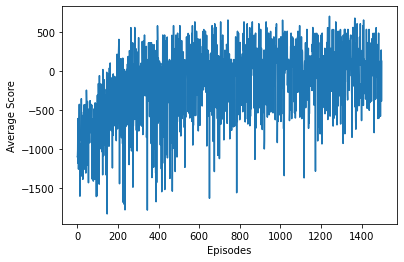

In [6]:
import matplotlib.pyplot as plt
import numpy as np
 #Plot the data\n

    
plt.plot(rewardstest)
# Show the plot\n",

plt.xlabel('Episodes')
plt.ylabel('Average Score')

plt.show()


In [7]:
print(np.mean(rewardstest))


-145.32933333333332


In [8]:
from itertools import product
# Create a list to store the results
results = []

gamma_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
learning_rate_values = [0.1, 0.2, 0.3, 0.4, 0.5]

# Perform grid search
for gamma, learning_rate in product(gamma_values, learning_rate_values):
    action_size = env.action_space.n
    state_size = env.observation_space.n
    qtable = np.zeros((state_size, action_size))    
    # Training loop
    rewards = train_model(gamma, learning_rate)
    # Evaluate the learned Q-table using a test set or simulations
    average_reward = np.average(rewards)  # Implement your evaluation metric
    
    # Store the results
    results.append({'gamma': gamma, 'learning_rate': learning_rate, 'average_reward': average_reward})

# Find the optimal combination of gamma and learning rate
optimal_result = max(results, key=lambda x: x['average_reward'])
optimal_gamma = optimal_result['gamma']
optimal_learning_rate = optimal_result['learning_rate']

# Print the optimal values
print("Optimal Gamma:", optimal_gamma)
print("Optimal Learning Rate:", optimal_learning_rate)

Episode  0 / 1500
Episode  1 / 1500
Episode  2 / 1500
Episode  3 / 1500
Episode  4 / 1500
Episode  5 / 1500
Episode  6 / 1500
Episode  7 / 1500
Episode  8 / 1500
Episode  9 / 1500
Episode  10 / 1500
Episode  11 / 1500
Episode  12 / 1500
Episode  13 / 1500
Episode  14 / 1500
Episode  15 / 1500
Episode  16 / 1500
Episode  17 / 1500
Episode  18 / 1500
Episode  19 / 1500
Episode  20 / 1500
Episode  21 / 1500
Episode  22 / 1500
Episode  23 / 1500
Episode  24 / 1500
Episode  25 / 1500
Episode  26 / 1500
Episode  27 / 1500
Episode  28 / 1500
Episode  29 / 1500
Episode  30 / 1500
Episode  31 / 1500
Episode  32 / 1500
Episode  33 / 1500
Episode  34 / 1500
Episode  35 / 1500
Episode  36 / 1500
Episode  37 / 1500
Episode  38 / 1500
Episode  39 / 1500
Episode  40 / 1500
Episode  41 / 1500
Episode  42 / 1500
Episode  43 / 1500
Episode  44 / 1500
Episode  45 / 1500
Episode  46 / 1500
Episode  47 / 1500
Episode  48 / 1500
Episode  49 / 1500
Episode  50 / 1500
Episode  51 / 1500
Episode  52 / 1500
Epi

Episode  423 / 1500
Episode  424 / 1500
Episode  425 / 1500
Episode  426 / 1500
Episode  427 / 1500
Episode  428 / 1500
Episode  429 / 1500
Episode  430 / 1500
Episode  431 / 1500
Episode  432 / 1500
Episode  433 / 1500
Episode  434 / 1500
Episode  435 / 1500
Episode  436 / 1500
Episode  437 / 1500
Episode  438 / 1500
Episode  439 / 1500
Episode  440 / 1500
Episode  441 / 1500
Episode  442 / 1500
Episode  443 / 1500
Episode  444 / 1500
Episode  445 / 1500
Episode  446 / 1500
Episode  447 / 1500
Episode  448 / 1500
Episode  449 / 1500
Episode  450 / 1500
Episode  451 / 1500
Episode  452 / 1500
Episode  453 / 1500
Episode  454 / 1500
Episode  455 / 1500
Episode  456 / 1500
Episode  457 / 1500
Episode  458 / 1500
Episode  459 / 1500
Episode  460 / 1500
Episode  461 / 1500
Episode  462 / 1500
Episode  463 / 1500
Episode  464 / 1500
Episode  465 / 1500
Episode  466 / 1500
Episode  467 / 1500
Episode  468 / 1500
Episode  469 / 1500
Episode  470 / 1500
Episode  471 / 1500
Episode  472 / 1500


Episode  842 / 1500
Episode  843 / 1500
Episode  844 / 1500
Episode  845 / 1500
Episode  846 / 1500
Episode  847 / 1500
Episode  848 / 1500
Episode  849 / 1500
Episode  850 / 1500
Episode  851 / 1500
Episode  852 / 1500
Episode  853 / 1500
Episode  854 / 1500
Episode  855 / 1500
Episode  856 / 1500
Episode  857 / 1500
Episode  858 / 1500
Episode  859 / 1500
Episode  860 / 1500
Episode  861 / 1500
Episode  862 / 1500
Episode  863 / 1500
Episode  864 / 1500
Episode  865 / 1500
Episode  866 / 1500
Episode  867 / 1500
Episode  868 / 1500
Episode  869 / 1500
Episode  870 / 1500
Episode  871 / 1500
Episode  872 / 1500
Episode  873 / 1500
Episode  874 / 1500
Episode  875 / 1500
Episode  876 / 1500
Episode  877 / 1500
Episode  878 / 1500
Episode  879 / 1500
Episode  880 / 1500
Episode  881 / 1500
Episode  882 / 1500
Episode  883 / 1500
Episode  884 / 1500
Episode  885 / 1500
Episode  886 / 1500
Episode  887 / 1500
Episode  888 / 1500
Episode  889 / 1500
Episode  890 / 1500
Episode  891 / 1500


Episode  1241 / 1500
Episode  1242 / 1500
Episode  1243 / 1500
Episode  1244 / 1500
Episode  1245 / 1500
Episode  1246 / 1500
Episode  1247 / 1500
Episode  1248 / 1500
Episode  1249 / 1500
Episode  1250 / 1500
Episode  1251 / 1500
Episode  1252 / 1500
Episode  1253 / 1500
Episode  1254 / 1500
Episode  1255 / 1500
Episode  1256 / 1500
Episode  1257 / 1500
Episode  1258 / 1500
Episode  1259 / 1500
Episode  1260 / 1500
Episode  1261 / 1500
Episode  1262 / 1500
Episode  1263 / 1500
Episode  1264 / 1500
Episode  1265 / 1500
Episode  1266 / 1500
Episode  1267 / 1500
Episode  1268 / 1500
Episode  1269 / 1500
Episode  1270 / 1500
Episode  1271 / 1500
Episode  1272 / 1500
Episode  1273 / 1500
Episode  1274 / 1500
Episode  1275 / 1500
Episode  1276 / 1500
Episode  1277 / 1500
Episode  1278 / 1500
Episode  1279 / 1500
Episode  1280 / 1500
Episode  1281 / 1500
Episode  1282 / 1500
Episode  1283 / 1500
Episode  1284 / 1500
Episode  1285 / 1500
Episode  1286 / 1500
Episode  1287 / 1500
Episode  1288

Episode  147 / 1500
Episode  148 / 1500
Episode  149 / 1500
Episode  150 / 1500
Episode  151 / 1500
Episode  152 / 1500
Episode  153 / 1500
Episode  154 / 1500
Episode  155 / 1500
Episode  156 / 1500
Episode  157 / 1500
Episode  158 / 1500
Episode  159 / 1500
Episode  160 / 1500
Episode  161 / 1500
Episode  162 / 1500
Episode  163 / 1500
Episode  164 / 1500
Episode  165 / 1500
Episode  166 / 1500
Episode  167 / 1500
Episode  168 / 1500
Episode  169 / 1500
Episode  170 / 1500
Episode  171 / 1500
Episode  172 / 1500
Episode  173 / 1500
Episode  174 / 1500
Episode  175 / 1500
Episode  176 / 1500
Episode  177 / 1500
Episode  178 / 1500
Episode  179 / 1500
Episode  180 / 1500
Episode  181 / 1500
Episode  182 / 1500
Episode  183 / 1500
Episode  184 / 1500
Episode  185 / 1500
Episode  186 / 1500
Episode  187 / 1500
Episode  188 / 1500
Episode  189 / 1500
Episode  190 / 1500
Episode  191 / 1500
Episode  192 / 1500
Episode  193 / 1500
Episode  194 / 1500
Episode  195 / 1500
Episode  196 / 1500


Episode  566 / 1500
Episode  567 / 1500
Episode  568 / 1500
Episode  569 / 1500
Episode  570 / 1500
Episode  571 / 1500
Episode  572 / 1500
Episode  573 / 1500
Episode  574 / 1500
Episode  575 / 1500
Episode  576 / 1500
Episode  577 / 1500
Episode  578 / 1500
Episode  579 / 1500
Episode  580 / 1500
Episode  581 / 1500
Episode  582 / 1500
Episode  583 / 1500
Episode  584 / 1500
Episode  585 / 1500
Episode  586 / 1500
Episode  587 / 1500
Episode  588 / 1500
Episode  589 / 1500
Episode  590 / 1500
Episode  591 / 1500
Episode  592 / 1500
Episode  593 / 1500
Episode  594 / 1500
Episode  595 / 1500
Episode  596 / 1500
Episode  597 / 1500
Episode  598 / 1500
Episode  599 / 1500
Episode  600 / 1500
Episode  601 / 1500
Episode  602 / 1500
Episode  603 / 1500
Episode  604 / 1500
Episode  605 / 1500
Episode  606 / 1500
Episode  607 / 1500
Episode  608 / 1500
Episode  609 / 1500
Episode  610 / 1500
Episode  611 / 1500
Episode  612 / 1500
Episode  613 / 1500
Episode  614 / 1500
Episode  615 / 1500


Episode  984 / 1500
Episode  985 / 1500
Episode  986 / 1500
Episode  987 / 1500
Episode  988 / 1500
Episode  989 / 1500
Episode  990 / 1500
Episode  991 / 1500
Episode  992 / 1500
Episode  993 / 1500
Episode  994 / 1500
Episode  995 / 1500
Episode  996 / 1500
Episode  997 / 1500
Episode  998 / 1500
Episode  999 / 1500
Episode  1000 / 1500
Episode  1001 / 1500
Episode  1002 / 1500
Episode  1003 / 1500
Episode  1004 / 1500
Episode  1005 / 1500
Episode  1006 / 1500
Episode  1007 / 1500
Episode  1008 / 1500
Episode  1009 / 1500
Episode  1010 / 1500
Episode  1011 / 1500
Episode  1012 / 1500
Episode  1013 / 1500
Episode  1014 / 1500
Episode  1015 / 1500
Episode  1016 / 1500
Episode  1017 / 1500
Episode  1018 / 1500
Episode  1019 / 1500
Episode  1020 / 1500
Episode  1021 / 1500
Episode  1022 / 1500
Episode  1023 / 1500
Episode  1024 / 1500
Episode  1025 / 1500
Episode  1026 / 1500
Episode  1027 / 1500
Episode  1028 / 1500
Episode  1029 / 1500
Episode  1030 / 1500
Episode  1031 / 1500
Episode 

Episode  1379 / 1500
Episode  1380 / 1500
Episode  1381 / 1500
Episode  1382 / 1500
Episode  1383 / 1500
Episode  1384 / 1500
Episode  1385 / 1500
Episode  1386 / 1500
Episode  1387 / 1500
Episode  1388 / 1500
Episode  1389 / 1500
Episode  1390 / 1500
Episode  1391 / 1500
Episode  1392 / 1500
Episode  1393 / 1500
Episode  1394 / 1500
Episode  1395 / 1500
Episode  1396 / 1500
Episode  1397 / 1500
Episode  1398 / 1500
Episode  1399 / 1500
Episode  1400 / 1500
Episode  1401 / 1500
Episode  1402 / 1500
Episode  1403 / 1500
Episode  1404 / 1500
Episode  1405 / 1500
Episode  1406 / 1500
Episode  1407 / 1500
Episode  1408 / 1500
Episode  1409 / 1500
Episode  1410 / 1500
Episode  1411 / 1500
Episode  1412 / 1500
Episode  1413 / 1500
Episode  1414 / 1500
Episode  1415 / 1500
Episode  1416 / 1500
Episode  1417 / 1500
Episode  1418 / 1500
Episode  1419 / 1500
Episode  1420 / 1500
Episode  1421 / 1500
Episode  1422 / 1500
Episode  1423 / 1500
Episode  1424 / 1500
Episode  1425 / 1500
Episode  1426

Episode  302 / 1500
Episode  303 / 1500
Episode  304 / 1500
Episode  305 / 1500
Episode  306 / 1500
Episode  307 / 1500
Episode  308 / 1500
Episode  309 / 1500
Episode  310 / 1500
Episode  311 / 1500
Episode  312 / 1500
Episode  313 / 1500
Episode  314 / 1500
Episode  315 / 1500
Episode  316 / 1500
Episode  317 / 1500
Episode  318 / 1500
Episode  319 / 1500
Episode  320 / 1500
Episode  321 / 1500
Episode  322 / 1500
Episode  323 / 1500
Episode  324 / 1500
Episode  325 / 1500
Episode  326 / 1500
Episode  327 / 1500
Episode  328 / 1500
Episode  329 / 1500
Episode  330 / 1500
Episode  331 / 1500
Episode  332 / 1500
Episode  333 / 1500
Episode  334 / 1500
Episode  335 / 1500
Episode  336 / 1500
Episode  337 / 1500
Episode  338 / 1500
Episode  339 / 1500
Episode  340 / 1500
Episode  341 / 1500
Episode  342 / 1500
Episode  343 / 1500
Episode  344 / 1500
Episode  345 / 1500
Episode  346 / 1500
Episode  347 / 1500
Episode  348 / 1500
Episode  349 / 1500
Episode  350 / 1500
Episode  351 / 1500


Episode  712 / 1500
Episode  713 / 1500
Episode  714 / 1500
Episode  715 / 1500
Episode  716 / 1500
Episode  717 / 1500
Episode  718 / 1500
Episode  719 / 1500
Episode  720 / 1500
Episode  721 / 1500
Episode  722 / 1500
Episode  723 / 1500
Episode  724 / 1500
Episode  725 / 1500
Episode  726 / 1500
Episode  727 / 1500
Episode  728 / 1500
Episode  729 / 1500
Episode  730 / 1500
Episode  731 / 1500
Episode  732 / 1500
Episode  733 / 1500
Episode  734 / 1500
Episode  735 / 1500
Episode  736 / 1500
Episode  737 / 1500
Episode  738 / 1500
Episode  739 / 1500
Episode  740 / 1500
Episode  741 / 1500
Episode  742 / 1500
Episode  743 / 1500
Episode  744 / 1500
Episode  745 / 1500
Episode  746 / 1500
Episode  747 / 1500
Episode  748 / 1500
Episode  749 / 1500
Episode  750 / 1500
Episode  751 / 1500
Episode  752 / 1500
Episode  753 / 1500
Episode  754 / 1500
Episode  755 / 1500
Episode  756 / 1500
Episode  757 / 1500
Episode  758 / 1500
Episode  759 / 1500
Episode  760 / 1500
Episode  761 / 1500


Episode  1116 / 1500
Episode  1117 / 1500
Episode  1118 / 1500
Episode  1119 / 1500
Episode  1120 / 1500
Episode  1121 / 1500
Episode  1122 / 1500
Episode  1123 / 1500
Episode  1124 / 1500
Episode  1125 / 1500
Episode  1126 / 1500
Episode  1127 / 1500
Episode  1128 / 1500
Episode  1129 / 1500
Episode  1130 / 1500
Episode  1131 / 1500
Episode  1132 / 1500
Episode  1133 / 1500
Episode  1134 / 1500
Episode  1135 / 1500
Episode  1136 / 1500
Episode  1137 / 1500
Episode  1138 / 1500
Episode  1139 / 1500
Episode  1140 / 1500
Episode  1141 / 1500
Episode  1142 / 1500
Episode  1143 / 1500
Episode  1144 / 1500
Episode  1145 / 1500
Episode  1146 / 1500
Episode  1147 / 1500
Episode  1148 / 1500
Episode  1149 / 1500
Episode  1150 / 1500
Episode  1151 / 1500
Episode  1152 / 1500
Episode  1153 / 1500
Episode  1154 / 1500
Episode  1155 / 1500
Episode  1156 / 1500
Episode  1157 / 1500
Episode  1158 / 1500
Episode  1159 / 1500
Episode  1160 / 1500
Episode  1161 / 1500
Episode  1162 / 1500
Episode  1163

Episode  14 / 1500
Episode  15 / 1500
Episode  16 / 1500
Episode  17 / 1500
Episode  18 / 1500
Episode  19 / 1500
Episode  20 / 1500
Episode  21 / 1500
Episode  22 / 1500
Episode  23 / 1500
Episode  24 / 1500
Episode  25 / 1500
Episode  26 / 1500
Episode  27 / 1500
Episode  28 / 1500
Episode  29 / 1500
Episode  30 / 1500
Episode  31 / 1500
Episode  32 / 1500
Episode  33 / 1500
Episode  34 / 1500
Episode  35 / 1500
Episode  36 / 1500
Episode  37 / 1500
Episode  38 / 1500
Episode  39 / 1500
Episode  40 / 1500
Episode  41 / 1500
Episode  42 / 1500
Episode  43 / 1500
Episode  44 / 1500
Episode  45 / 1500
Episode  46 / 1500
Episode  47 / 1500
Episode  48 / 1500
Episode  49 / 1500
Episode  50 / 1500
Episode  51 / 1500
Episode  52 / 1500
Episode  53 / 1500
Episode  54 / 1500
Episode  55 / 1500
Episode  56 / 1500
Episode  57 / 1500
Episode  58 / 1500
Episode  59 / 1500
Episode  60 / 1500
Episode  61 / 1500
Episode  62 / 1500
Episode  63 / 1500
Episode  64 / 1500
Episode  65 / 1500
Episode  66 

Episode  433 / 1500
Episode  434 / 1500
Episode  435 / 1500
Episode  436 / 1500
Episode  437 / 1500
Episode  438 / 1500
Episode  439 / 1500
Episode  440 / 1500
Episode  441 / 1500
Episode  442 / 1500
Episode  443 / 1500
Episode  444 / 1500
Episode  445 / 1500
Episode  446 / 1500
Episode  447 / 1500
Episode  448 / 1500
Episode  449 / 1500
Episode  450 / 1500
Episode  451 / 1500
Episode  452 / 1500
Episode  453 / 1500
Episode  454 / 1500
Episode  455 / 1500
Episode  456 / 1500
Episode  457 / 1500
Episode  458 / 1500
Episode  459 / 1500
Episode  460 / 1500
Episode  461 / 1500
Episode  462 / 1500
Episode  463 / 1500
Episode  464 / 1500
Episode  465 / 1500
Episode  466 / 1500
Episode  467 / 1500
Episode  468 / 1500
Episode  469 / 1500
Episode  470 / 1500
Episode  471 / 1500
Episode  472 / 1500
Episode  473 / 1500
Episode  474 / 1500
Episode  475 / 1500
Episode  476 / 1500
Episode  477 / 1500
Episode  478 / 1500
Episode  479 / 1500
Episode  480 / 1500
Episode  481 / 1500
Episode  482 / 1500


Episode  843 / 1500
Episode  844 / 1500
Episode  845 / 1500
Episode  846 / 1500
Episode  847 / 1500
Episode  848 / 1500
Episode  849 / 1500
Episode  850 / 1500
Episode  851 / 1500
Episode  852 / 1500
Episode  853 / 1500
Episode  854 / 1500
Episode  855 / 1500
Episode  856 / 1500
Episode  857 / 1500
Episode  858 / 1500
Episode  859 / 1500
Episode  860 / 1500
Episode  861 / 1500
Episode  862 / 1500
Episode  863 / 1500
Episode  864 / 1500
Episode  865 / 1500
Episode  866 / 1500
Episode  867 / 1500
Episode  868 / 1500
Episode  869 / 1500
Episode  870 / 1500
Episode  871 / 1500
Episode  872 / 1500
Episode  873 / 1500
Episode  874 / 1500
Episode  875 / 1500
Episode  876 / 1500
Episode  877 / 1500
Episode  878 / 1500
Episode  879 / 1500
Episode  880 / 1500
Episode  881 / 1500
Episode  882 / 1500
Episode  883 / 1500
Episode  884 / 1500
Episode  885 / 1500
Episode  886 / 1500
Episode  887 / 1500
Episode  888 / 1500
Episode  889 / 1500
Episode  890 / 1500
Episode  891 / 1500
Episode  892 / 1500


Episode  1242 / 1500
Episode  1243 / 1500
Episode  1244 / 1500
Episode  1245 / 1500
Episode  1246 / 1500
Episode  1247 / 1500
Episode  1248 / 1500
Episode  1249 / 1500
Episode  1250 / 1500
Episode  1251 / 1500
Episode  1252 / 1500
Episode  1253 / 1500
Episode  1254 / 1500
Episode  1255 / 1500
Episode  1256 / 1500
Episode  1257 / 1500
Episode  1258 / 1500
Episode  1259 / 1500
Episode  1260 / 1500
Episode  1261 / 1500
Episode  1262 / 1500
Episode  1263 / 1500
Episode  1264 / 1500
Episode  1265 / 1500
Episode  1266 / 1500
Episode  1267 / 1500
Episode  1268 / 1500
Episode  1269 / 1500
Episode  1270 / 1500
Episode  1271 / 1500
Episode  1272 / 1500
Episode  1273 / 1500
Episode  1274 / 1500
Episode  1275 / 1500
Episode  1276 / 1500
Episode  1277 / 1500
Episode  1278 / 1500
Episode  1279 / 1500
Episode  1280 / 1500
Episode  1281 / 1500
Episode  1282 / 1500
Episode  1283 / 1500
Episode  1284 / 1500
Episode  1285 / 1500
Episode  1286 / 1500
Episode  1287 / 1500
Episode  1288 / 1500
Episode  1289

Episode  151 / 1500
Episode  152 / 1500
Episode  153 / 1500
Episode  154 / 1500
Episode  155 / 1500
Episode  156 / 1500
Episode  157 / 1500
Episode  158 / 1500
Episode  159 / 1500
Episode  160 / 1500
Episode  161 / 1500
Episode  162 / 1500
Episode  163 / 1500
Episode  164 / 1500
Episode  165 / 1500
Episode  166 / 1500
Episode  167 / 1500
Episode  168 / 1500
Episode  169 / 1500
Episode  170 / 1500
Episode  171 / 1500
Episode  172 / 1500
Episode  173 / 1500
Episode  174 / 1500
Episode  175 / 1500
Episode  176 / 1500
Episode  177 / 1500
Episode  178 / 1500
Episode  179 / 1500
Episode  180 / 1500
Episode  181 / 1500
Episode  182 / 1500
Episode  183 / 1500
Episode  184 / 1500
Episode  185 / 1500
Episode  186 / 1500
Episode  187 / 1500
Episode  188 / 1500
Episode  189 / 1500
Episode  190 / 1500
Episode  191 / 1500
Episode  192 / 1500
Episode  193 / 1500
Episode  194 / 1500
Episode  195 / 1500
Episode  196 / 1500
Episode  197 / 1500
Episode  198 / 1500
Episode  199 / 1500
Episode  200 / 1500


Episode  574 / 1500
Episode  575 / 1500
Episode  576 / 1500
Episode  577 / 1500
Episode  578 / 1500
Episode  579 / 1500
Episode  580 / 1500
Episode  581 / 1500
Episode  582 / 1500
Episode  583 / 1500
Episode  584 / 1500
Episode  585 / 1500
Episode  586 / 1500
Episode  587 / 1500
Episode  588 / 1500
Episode  589 / 1500
Episode  590 / 1500
Episode  591 / 1500
Episode  592 / 1500
Episode  593 / 1500
Episode  594 / 1500
Episode  595 / 1500
Episode  596 / 1500
Episode  597 / 1500
Episode  598 / 1500
Episode  599 / 1500
Episode  600 / 1500
Episode  601 / 1500
Episode  602 / 1500
Episode  603 / 1500
Episode  604 / 1500
Episode  605 / 1500
Episode  606 / 1500
Episode  607 / 1500
Episode  608 / 1500
Episode  609 / 1500
Episode  610 / 1500
Episode  611 / 1500
Episode  612 / 1500
Episode  613 / 1500
Episode  614 / 1500
Episode  615 / 1500
Episode  616 / 1500
Episode  617 / 1500
Episode  618 / 1500
Episode  619 / 1500
Episode  620 / 1500
Episode  621 / 1500
Episode  622 / 1500
Episode  623 / 1500


Episode  992 / 1500
Episode  993 / 1500
Episode  994 / 1500
Episode  995 / 1500
Episode  996 / 1500
Episode  997 / 1500
Episode  998 / 1500
Episode  999 / 1500
Episode  1000 / 1500
Episode  1001 / 1500
Episode  1002 / 1500
Episode  1003 / 1500
Episode  1004 / 1500
Episode  1005 / 1500
Episode  1006 / 1500
Episode  1007 / 1500
Episode  1008 / 1500
Episode  1009 / 1500
Episode  1010 / 1500
Episode  1011 / 1500
Episode  1012 / 1500
Episode  1013 / 1500
Episode  1014 / 1500
Episode  1015 / 1500
Episode  1016 / 1500
Episode  1017 / 1500
Episode  1018 / 1500
Episode  1019 / 1500
Episode  1020 / 1500
Episode  1021 / 1500
Episode  1022 / 1500
Episode  1023 / 1500
Episode  1024 / 1500
Episode  1025 / 1500
Episode  1026 / 1500
Episode  1027 / 1500
Episode  1028 / 1500
Episode  1029 / 1500
Episode  1030 / 1500
Episode  1031 / 1500
Episode  1032 / 1500
Episode  1033 / 1500
Episode  1034 / 1500
Episode  1035 / 1500
Episode  1036 / 1500
Episode  1037 / 1500
Episode  1038 / 1500
Episode  1039 / 1500


Episode  1390 / 1500
Episode  1391 / 1500
Episode  1392 / 1500
Episode  1393 / 1500
Episode  1394 / 1500
Episode  1395 / 1500
Episode  1396 / 1500
Episode  1397 / 1500
Episode  1398 / 1500
Episode  1399 / 1500
Episode  1400 / 1500
Episode  1401 / 1500
Episode  1402 / 1500
Episode  1403 / 1500
Episode  1404 / 1500
Episode  1405 / 1500
Episode  1406 / 1500
Episode  1407 / 1500
Episode  1408 / 1500
Episode  1409 / 1500
Episode  1410 / 1500
Episode  1411 / 1500
Episode  1412 / 1500
Episode  1413 / 1500
Episode  1414 / 1500
Episode  1415 / 1500
Episode  1416 / 1500
Episode  1417 / 1500
Episode  1418 / 1500
Episode  1419 / 1500
Episode  1420 / 1500
Episode  1421 / 1500
Episode  1422 / 1500
Episode  1423 / 1500
Episode  1424 / 1500
Episode  1425 / 1500
Episode  1426 / 1500
Episode  1427 / 1500
Episode  1428 / 1500
Episode  1429 / 1500
Episode  1430 / 1500
Episode  1431 / 1500
Episode  1432 / 1500
Episode  1433 / 1500
Episode  1434 / 1500
Episode  1435 / 1500
Episode  1436 / 1500
Episode  1437

Episode  300 / 1500
Episode  301 / 1500
Episode  302 / 1500
Episode  303 / 1500
Episode  304 / 1500
Episode  305 / 1500
Episode  306 / 1500
Episode  307 / 1500
Episode  308 / 1500
Episode  309 / 1500
Episode  310 / 1500
Episode  311 / 1500
Episode  312 / 1500
Episode  313 / 1500
Episode  314 / 1500
Episode  315 / 1500
Episode  316 / 1500
Episode  317 / 1500
Episode  318 / 1500
Episode  319 / 1500
Episode  320 / 1500
Episode  321 / 1500
Episode  322 / 1500
Episode  323 / 1500
Episode  324 / 1500
Episode  325 / 1500
Episode  326 / 1500
Episode  327 / 1500
Episode  328 / 1500
Episode  329 / 1500
Episode  330 / 1500
Episode  331 / 1500
Episode  332 / 1500
Episode  333 / 1500
Episode  334 / 1500
Episode  335 / 1500
Episode  336 / 1500
Episode  337 / 1500
Episode  338 / 1500
Episode  339 / 1500
Episode  340 / 1500
Episode  341 / 1500
Episode  342 / 1500
Episode  343 / 1500
Episode  344 / 1500
Episode  345 / 1500
Episode  346 / 1500
Episode  347 / 1500
Episode  348 / 1500
Episode  349 / 1500


Episode  710 / 1500
Episode  711 / 1500
Episode  712 / 1500
Episode  713 / 1500
Episode  714 / 1500
Episode  715 / 1500
Episode  716 / 1500
Episode  717 / 1500
Episode  718 / 1500
Episode  719 / 1500
Episode  720 / 1500
Episode  721 / 1500
Episode  722 / 1500
Episode  723 / 1500
Episode  724 / 1500
Episode  725 / 1500
Episode  726 / 1500
Episode  727 / 1500
Episode  728 / 1500
Episode  729 / 1500
Episode  730 / 1500
Episode  731 / 1500
Episode  732 / 1500
Episode  733 / 1500
Episode  734 / 1500
Episode  735 / 1500
Episode  736 / 1500
Episode  737 / 1500
Episode  738 / 1500
Episode  739 / 1500
Episode  740 / 1500
Episode  741 / 1500
Episode  742 / 1500
Episode  743 / 1500
Episode  744 / 1500
Episode  745 / 1500
Episode  746 / 1500
Episode  747 / 1500
Episode  748 / 1500
Episode  749 / 1500
Episode  750 / 1500
Episode  751 / 1500
Episode  752 / 1500
Episode  753 / 1500
Episode  754 / 1500
Episode  755 / 1500
Episode  756 / 1500
Episode  757 / 1500
Episode  758 / 1500
Episode  759 / 1500


Episode  1114 / 1500
Episode  1115 / 1500
Episode  1116 / 1500
Episode  1117 / 1500
Episode  1118 / 1500
Episode  1119 / 1500
Episode  1120 / 1500
Episode  1121 / 1500
Episode  1122 / 1500
Episode  1123 / 1500
Episode  1124 / 1500
Episode  1125 / 1500
Episode  1126 / 1500
Episode  1127 / 1500
Episode  1128 / 1500
Episode  1129 / 1500
Episode  1130 / 1500
Episode  1131 / 1500
Episode  1132 / 1500
Episode  1133 / 1500
Episode  1134 / 1500
Episode  1135 / 1500
Episode  1136 / 1500
Episode  1137 / 1500
Episode  1138 / 1500
Episode  1139 / 1500
Episode  1140 / 1500
Episode  1141 / 1500
Episode  1142 / 1500
Episode  1143 / 1500
Episode  1144 / 1500
Episode  1145 / 1500
Episode  1146 / 1500
Episode  1147 / 1500
Episode  1148 / 1500
Episode  1149 / 1500
Episode  1150 / 1500
Episode  1151 / 1500
Episode  1152 / 1500
Episode  1153 / 1500
Episode  1154 / 1500
Episode  1155 / 1500
Episode  1156 / 1500
Episode  1157 / 1500
Episode  1158 / 1500
Episode  1159 / 1500
Episode  1160 / 1500
Episode  1161

Episode  20 / 1500
Episode  21 / 1500
Episode  22 / 1500
Episode  23 / 1500
Episode  24 / 1500
Episode  25 / 1500
Episode  26 / 1500
Episode  27 / 1500
Episode  28 / 1500
Episode  29 / 1500
Episode  30 / 1500
Episode  31 / 1500
Episode  32 / 1500
Episode  33 / 1500
Episode  34 / 1500
Episode  35 / 1500
Episode  36 / 1500
Episode  37 / 1500
Episode  38 / 1500
Episode  39 / 1500
Episode  40 / 1500
Episode  41 / 1500
Episode  42 / 1500
Episode  43 / 1500
Episode  44 / 1500
Episode  45 / 1500
Episode  46 / 1500
Episode  47 / 1500
Episode  48 / 1500
Episode  49 / 1500
Episode  50 / 1500
Episode  51 / 1500
Episode  52 / 1500
Episode  53 / 1500
Episode  54 / 1500
Episode  55 / 1500
Episode  56 / 1500
Episode  57 / 1500
Episode  58 / 1500
Episode  59 / 1500
Episode  60 / 1500
Episode  61 / 1500
Episode  62 / 1500
Episode  63 / 1500
Episode  64 / 1500
Episode  65 / 1500
Episode  66 / 1500
Episode  67 / 1500
Episode  68 / 1500
Episode  69 / 1500
Episode  70 / 1500
Episode  71 / 1500
Episode  72 

Episode  434 / 1500
Episode  435 / 1500
Episode  436 / 1500
Episode  437 / 1500
Episode  438 / 1500
Episode  439 / 1500
Episode  440 / 1500
Episode  441 / 1500
Episode  442 / 1500
Episode  443 / 1500
Episode  444 / 1500
Episode  445 / 1500
Episode  446 / 1500
Episode  447 / 1500
Episode  448 / 1500
Episode  449 / 1500
Episode  450 / 1500
Episode  451 / 1500
Episode  452 / 1500
Episode  453 / 1500
Episode  454 / 1500
Episode  455 / 1500
Episode  456 / 1500
Episode  457 / 1500
Episode  458 / 1500
Episode  459 / 1500
Episode  460 / 1500
Episode  461 / 1500
Episode  462 / 1500
Episode  463 / 1500
Episode  464 / 1500
Episode  465 / 1500
Episode  466 / 1500
Episode  467 / 1500
Episode  468 / 1500
Episode  469 / 1500
Episode  470 / 1500
Episode  471 / 1500
Episode  472 / 1500
Episode  473 / 1500
Episode  474 / 1500
Episode  475 / 1500
Episode  476 / 1500
Episode  477 / 1500
Episode  478 / 1500
Episode  479 / 1500
Episode  480 / 1500
Episode  481 / 1500
Episode  482 / 1500
Episode  483 / 1500


Episode  846 / 1500
Episode  847 / 1500
Episode  848 / 1500
Episode  849 / 1500
Episode  850 / 1500
Episode  851 / 1500
Episode  852 / 1500
Episode  853 / 1500
Episode  854 / 1500
Episode  855 / 1500
Episode  856 / 1500
Episode  857 / 1500
Episode  858 / 1500
Episode  859 / 1500
Episode  860 / 1500
Episode  861 / 1500
Episode  862 / 1500
Episode  863 / 1500
Episode  864 / 1500
Episode  865 / 1500
Episode  866 / 1500
Episode  867 / 1500
Episode  868 / 1500
Episode  869 / 1500
Episode  870 / 1500
Episode  871 / 1500
Episode  872 / 1500
Episode  873 / 1500
Episode  874 / 1500
Episode  875 / 1500
Episode  876 / 1500
Episode  877 / 1500
Episode  878 / 1500
Episode  879 / 1500
Episode  880 / 1500
Episode  881 / 1500
Episode  882 / 1500
Episode  883 / 1500
Episode  884 / 1500
Episode  885 / 1500
Episode  886 / 1500
Episode  887 / 1500
Episode  888 / 1500
Episode  889 / 1500
Episode  890 / 1500
Episode  891 / 1500
Episode  892 / 1500
Episode  893 / 1500
Episode  894 / 1500
Episode  895 / 1500


Episode  1251 / 1500
Episode  1252 / 1500
Episode  1253 / 1500
Episode  1254 / 1500
Episode  1255 / 1500
Episode  1256 / 1500
Episode  1257 / 1500
Episode  1258 / 1500
Episode  1259 / 1500
Episode  1260 / 1500
Episode  1261 / 1500
Episode  1262 / 1500
Episode  1263 / 1500
Episode  1264 / 1500
Episode  1265 / 1500
Episode  1266 / 1500
Episode  1267 / 1500
Episode  1268 / 1500
Episode  1269 / 1500
Episode  1270 / 1500
Episode  1271 / 1500
Episode  1272 / 1500
Episode  1273 / 1500
Episode  1274 / 1500
Episode  1275 / 1500
Episode  1276 / 1500
Episode  1277 / 1500
Episode  1278 / 1500
Episode  1279 / 1500
Episode  1280 / 1500
Episode  1281 / 1500
Episode  1282 / 1500
Episode  1283 / 1500
Episode  1284 / 1500
Episode  1285 / 1500
Episode  1286 / 1500
Episode  1287 / 1500
Episode  1288 / 1500
Episode  1289 / 1500
Episode  1290 / 1500
Episode  1291 / 1500
Episode  1292 / 1500
Episode  1293 / 1500
Episode  1294 / 1500
Episode  1295 / 1500
Episode  1296 / 1500
Episode  1297 / 1500
Episode  1298

Episode  155 / 1500
Episode  156 / 1500
Episode  157 / 1500
Episode  158 / 1500
Episode  159 / 1500
Episode  160 / 1500
Episode  161 / 1500
Episode  162 / 1500
Episode  163 / 1500
Episode  164 / 1500
Episode  165 / 1500
Episode  166 / 1500
Episode  167 / 1500
Episode  168 / 1500
Episode  169 / 1500
Episode  170 / 1500
Episode  171 / 1500
Episode  172 / 1500
Episode  173 / 1500
Episode  174 / 1500
Episode  175 / 1500
Episode  176 / 1500
Episode  177 / 1500
Episode  178 / 1500
Episode  179 / 1500
Episode  180 / 1500
Episode  181 / 1500
Episode  182 / 1500
Episode  183 / 1500
Episode  184 / 1500
Episode  185 / 1500
Episode  186 / 1500
Episode  187 / 1500
Episode  188 / 1500
Episode  189 / 1500
Episode  190 / 1500
Episode  191 / 1500
Episode  192 / 1500
Episode  193 / 1500
Episode  194 / 1500
Episode  195 / 1500
Episode  196 / 1500
Episode  197 / 1500
Episode  198 / 1500
Episode  199 / 1500
Episode  200 / 1500
Episode  201 / 1500
Episode  202 / 1500
Episode  203 / 1500
Episode  204 / 1500


Episode  565 / 1500
Episode  566 / 1500
Episode  567 / 1500
Episode  568 / 1500
Episode  569 / 1500
Episode  570 / 1500
Episode  571 / 1500
Episode  572 / 1500
Episode  573 / 1500
Episode  574 / 1500
Episode  575 / 1500
Episode  576 / 1500
Episode  577 / 1500
Episode  578 / 1500
Episode  579 / 1500
Episode  580 / 1500
Episode  581 / 1500
Episode  582 / 1500
Episode  583 / 1500
Episode  584 / 1500
Episode  585 / 1500
Episode  586 / 1500
Episode  587 / 1500
Episode  588 / 1500
Episode  589 / 1500
Episode  590 / 1500
Episode  591 / 1500
Episode  592 / 1500
Episode  593 / 1500
Episode  594 / 1500
Episode  595 / 1500
Episode  596 / 1500
Episode  597 / 1500
Episode  598 / 1500
Episode  599 / 1500
Episode  600 / 1500
Episode  601 / 1500
Episode  602 / 1500
Episode  603 / 1500
Episode  604 / 1500
Episode  605 / 1500
Episode  606 / 1500
Episode  607 / 1500
Episode  608 / 1500
Episode  609 / 1500
Episode  610 / 1500
Episode  611 / 1500
Episode  612 / 1500
Episode  613 / 1500
Episode  614 / 1500


Episode  980 / 1500
Episode  981 / 1500
Episode  982 / 1500
Episode  983 / 1500
Episode  984 / 1500
Episode  985 / 1500
Episode  986 / 1500
Episode  987 / 1500
Episode  988 / 1500
Episode  989 / 1500
Episode  990 / 1500
Episode  991 / 1500
Episode  992 / 1500
Episode  993 / 1500
Episode  994 / 1500
Episode  995 / 1500
Episode  996 / 1500
Episode  997 / 1500
Episode  998 / 1500
Episode  999 / 1500
Episode  1000 / 1500
Episode  1001 / 1500
Episode  1002 / 1500
Episode  1003 / 1500
Episode  1004 / 1500
Episode  1005 / 1500
Episode  1006 / 1500
Episode  1007 / 1500
Episode  1008 / 1500
Episode  1009 / 1500
Episode  1010 / 1500
Episode  1011 / 1500
Episode  1012 / 1500
Episode  1013 / 1500
Episode  1014 / 1500
Episode  1015 / 1500
Episode  1016 / 1500
Episode  1017 / 1500
Episode  1018 / 1500
Episode  1019 / 1500
Episode  1020 / 1500
Episode  1021 / 1500
Episode  1022 / 1500
Episode  1023 / 1500
Episode  1024 / 1500
Episode  1025 / 1500
Episode  1026 / 1500
Episode  1027 / 1500
Episode  102

Episode  1375 / 1500
Episode  1376 / 1500
Episode  1377 / 1500
Episode  1378 / 1500
Episode  1379 / 1500
Episode  1380 / 1500
Episode  1381 / 1500
Episode  1382 / 1500
Episode  1383 / 1500
Episode  1384 / 1500
Episode  1385 / 1500
Episode  1386 / 1500
Episode  1387 / 1500
Episode  1388 / 1500
Episode  1389 / 1500
Episode  1390 / 1500
Episode  1391 / 1500
Episode  1392 / 1500
Episode  1393 / 1500
Episode  1394 / 1500
Episode  1395 / 1500
Episode  1396 / 1500
Episode  1397 / 1500
Episode  1398 / 1500
Episode  1399 / 1500
Episode  1400 / 1500
Episode  1401 / 1500
Episode  1402 / 1500
Episode  1403 / 1500
Episode  1404 / 1500
Episode  1405 / 1500
Episode  1406 / 1500
Episode  1407 / 1500
Episode  1408 / 1500
Episode  1409 / 1500
Episode  1410 / 1500
Episode  1411 / 1500
Episode  1412 / 1500
Episode  1413 / 1500
Episode  1414 / 1500
Episode  1415 / 1500
Episode  1416 / 1500
Episode  1417 / 1500
Episode  1418 / 1500
Episode  1419 / 1500
Episode  1420 / 1500
Episode  1421 / 1500
Episode  1422

Episode  286 / 1500
Episode  287 / 1500
Episode  288 / 1500
Episode  289 / 1500
Episode  290 / 1500
Episode  291 / 1500
Episode  292 / 1500
Episode  293 / 1500
Episode  294 / 1500
Episode  295 / 1500
Episode  296 / 1500
Episode  297 / 1500
Episode  298 / 1500
Episode  299 / 1500
Episode  300 / 1500
Episode  301 / 1500
Episode  302 / 1500
Episode  303 / 1500
Episode  304 / 1500
Episode  305 / 1500
Episode  306 / 1500
Episode  307 / 1500
Episode  308 / 1500
Episode  309 / 1500
Episode  310 / 1500
Episode  311 / 1500
Episode  312 / 1500
Episode  313 / 1500
Episode  314 / 1500
Episode  315 / 1500
Episode  316 / 1500
Episode  317 / 1500
Episode  318 / 1500
Episode  319 / 1500
Episode  320 / 1500
Episode  321 / 1500
Episode  322 / 1500
Episode  323 / 1500
Episode  324 / 1500
Episode  325 / 1500
Episode  326 / 1500
Episode  327 / 1500
Episode  328 / 1500
Episode  329 / 1500
Episode  330 / 1500
Episode  331 / 1500
Episode  332 / 1500
Episode  333 / 1500
Episode  334 / 1500
Episode  335 / 1500


Episode  696 / 1500
Episode  697 / 1500
Episode  698 / 1500
Episode  699 / 1500
Episode  700 / 1500
Episode  701 / 1500
Episode  702 / 1500
Episode  703 / 1500
Episode  704 / 1500
Episode  705 / 1500
Episode  706 / 1500
Episode  707 / 1500
Episode  708 / 1500
Episode  709 / 1500
Episode  710 / 1500
Episode  711 / 1500
Episode  712 / 1500
Episode  713 / 1500
Episode  714 / 1500
Episode  715 / 1500
Episode  716 / 1500
Episode  717 / 1500
Episode  718 / 1500
Episode  719 / 1500
Episode  720 / 1500
Episode  721 / 1500
Episode  722 / 1500
Episode  723 / 1500
Episode  724 / 1500
Episode  725 / 1500
Episode  726 / 1500
Episode  727 / 1500
Episode  728 / 1500
Episode  729 / 1500
Episode  730 / 1500
Episode  731 / 1500
Episode  732 / 1500
Episode  733 / 1500
Episode  734 / 1500
Episode  735 / 1500
Episode  736 / 1500
Episode  737 / 1500
Episode  738 / 1500
Episode  739 / 1500
Episode  740 / 1500
Episode  741 / 1500
Episode  742 / 1500
Episode  743 / 1500
Episode  744 / 1500
Episode  745 / 1500


Episode  1110 / 1500
Episode  1111 / 1500
Episode  1112 / 1500
Episode  1113 / 1500
Episode  1114 / 1500
Episode  1115 / 1500
Episode  1116 / 1500
Episode  1117 / 1500
Episode  1118 / 1500
Episode  1119 / 1500
Episode  1120 / 1500
Episode  1121 / 1500
Episode  1122 / 1500
Episode  1123 / 1500
Episode  1124 / 1500
Episode  1125 / 1500
Episode  1126 / 1500
Episode  1127 / 1500
Episode  1128 / 1500
Episode  1129 / 1500
Episode  1130 / 1500
Episode  1131 / 1500
Episode  1132 / 1500
Episode  1133 / 1500
Episode  1134 / 1500
Episode  1135 / 1500
Episode  1136 / 1500
Episode  1137 / 1500
Episode  1138 / 1500
Episode  1139 / 1500
Episode  1140 / 1500
Episode  1141 / 1500
Episode  1142 / 1500
Episode  1143 / 1500
Episode  1144 / 1500
Episode  1145 / 1500
Episode  1146 / 1500
Episode  1147 / 1500
Episode  1148 / 1500
Episode  1149 / 1500
Episode  1150 / 1500
Episode  1151 / 1500
Episode  1152 / 1500
Episode  1153 / 1500
Episode  1154 / 1500
Episode  1155 / 1500
Episode  1156 / 1500
Episode  1157

Episode  5 / 1500
Episode  6 / 1500
Episode  7 / 1500
Episode  8 / 1500
Episode  9 / 1500
Episode  10 / 1500
Episode  11 / 1500
Episode  12 / 1500
Episode  13 / 1500
Episode  14 / 1500
Episode  15 / 1500
Episode  16 / 1500
Episode  17 / 1500
Episode  18 / 1500
Episode  19 / 1500
Episode  20 / 1500
Episode  21 / 1500
Episode  22 / 1500
Episode  23 / 1500
Episode  24 / 1500
Episode  25 / 1500
Episode  26 / 1500
Episode  27 / 1500
Episode  28 / 1500
Episode  29 / 1500
Episode  30 / 1500
Episode  31 / 1500
Episode  32 / 1500
Episode  33 / 1500
Episode  34 / 1500
Episode  35 / 1500
Episode  36 / 1500
Episode  37 / 1500
Episode  38 / 1500
Episode  39 / 1500
Episode  40 / 1500
Episode  41 / 1500
Episode  42 / 1500
Episode  43 / 1500
Episode  44 / 1500
Episode  45 / 1500
Episode  46 / 1500
Episode  47 / 1500
Episode  48 / 1500
Episode  49 / 1500
Episode  50 / 1500
Episode  51 / 1500
Episode  52 / 1500
Episode  53 / 1500
Episode  54 / 1500
Episode  55 / 1500
Episode  56 / 1500
Episode  57 / 150

Episode  426 / 1500
Episode  427 / 1500
Episode  428 / 1500
Episode  429 / 1500
Episode  430 / 1500
Episode  431 / 1500
Episode  432 / 1500
Episode  433 / 1500
Episode  434 / 1500
Episode  435 / 1500
Episode  436 / 1500
Episode  437 / 1500
Episode  438 / 1500
Episode  439 / 1500
Episode  440 / 1500
Episode  441 / 1500
Episode  442 / 1500
Episode  443 / 1500
Episode  444 / 1500
Episode  445 / 1500
Episode  446 / 1500
Episode  447 / 1500
Episode  448 / 1500
Episode  449 / 1500
Episode  450 / 1500
Episode  451 / 1500
Episode  452 / 1500
Episode  453 / 1500
Episode  454 / 1500
Episode  455 / 1500
Episode  456 / 1500
Episode  457 / 1500
Episode  458 / 1500
Episode  459 / 1500
Episode  460 / 1500
Episode  461 / 1500
Episode  462 / 1500
Episode  463 / 1500
Episode  464 / 1500
Episode  465 / 1500
Episode  466 / 1500
Episode  467 / 1500
Episode  468 / 1500
Episode  469 / 1500
Episode  470 / 1500
Episode  471 / 1500
Episode  472 / 1500
Episode  473 / 1500
Episode  474 / 1500
Episode  475 / 1500


Episode  842 / 1500
Episode  843 / 1500
Episode  844 / 1500
Episode  845 / 1500
Episode  846 / 1500
Episode  847 / 1500
Episode  848 / 1500
Episode  849 / 1500
Episode  850 / 1500
Episode  851 / 1500
Episode  852 / 1500
Episode  853 / 1500
Episode  854 / 1500
Episode  855 / 1500
Episode  856 / 1500
Episode  857 / 1500
Episode  858 / 1500
Episode  859 / 1500
Episode  860 / 1500
Episode  861 / 1500
Episode  862 / 1500
Episode  863 / 1500
Episode  864 / 1500
Episode  865 / 1500
Episode  866 / 1500
Episode  867 / 1500
Episode  868 / 1500
Episode  869 / 1500
Episode  870 / 1500
Episode  871 / 1500
Episode  872 / 1500
Episode  873 / 1500
Episode  874 / 1500
Episode  875 / 1500
Episode  876 / 1500
Episode  877 / 1500
Episode  878 / 1500
Episode  879 / 1500
Episode  880 / 1500
Episode  881 / 1500
Episode  882 / 1500
Episode  883 / 1500
Episode  884 / 1500
Episode  885 / 1500
Episode  886 / 1500
Episode  887 / 1500
Episode  888 / 1500
Episode  889 / 1500
Episode  890 / 1500
Episode  891 / 1500


Episode  1246 / 1500
Episode  1247 / 1500
Episode  1248 / 1500
Episode  1249 / 1500
Episode  1250 / 1500
Episode  1251 / 1500
Episode  1252 / 1500
Episode  1253 / 1500
Episode  1254 / 1500
Episode  1255 / 1500
Episode  1256 / 1500
Episode  1257 / 1500
Episode  1258 / 1500
Episode  1259 / 1500
Episode  1260 / 1500
Episode  1261 / 1500
Episode  1262 / 1500
Episode  1263 / 1500
Episode  1264 / 1500
Episode  1265 / 1500
Episode  1266 / 1500
Episode  1267 / 1500
Episode  1268 / 1500
Episode  1269 / 1500
Episode  1270 / 1500
Episode  1271 / 1500
Episode  1272 / 1500
Episode  1273 / 1500
Episode  1274 / 1500
Episode  1275 / 1500
Episode  1276 / 1500
Episode  1277 / 1500
Episode  1278 / 1500
Episode  1279 / 1500
Episode  1280 / 1500
Episode  1281 / 1500
Episode  1282 / 1500
Episode  1283 / 1500
Episode  1284 / 1500
Episode  1285 / 1500
Episode  1286 / 1500
Episode  1287 / 1500
Episode  1288 / 1500
Episode  1289 / 1500
Episode  1290 / 1500
Episode  1291 / 1500
Episode  1292 / 1500
Episode  1293

Episode  157 / 1500
Episode  158 / 1500
Episode  159 / 1500
Episode  160 / 1500
Episode  161 / 1500
Episode  162 / 1500
Episode  163 / 1500
Episode  164 / 1500
Episode  165 / 1500
Episode  166 / 1500
Episode  167 / 1500
Episode  168 / 1500
Episode  169 / 1500
Episode  170 / 1500
Episode  171 / 1500
Episode  172 / 1500
Episode  173 / 1500
Episode  174 / 1500
Episode  175 / 1500
Episode  176 / 1500
Episode  177 / 1500
Episode  178 / 1500
Episode  179 / 1500
Episode  180 / 1500
Episode  181 / 1500
Episode  182 / 1500
Episode  183 / 1500
Episode  184 / 1500
Episode  185 / 1500
Episode  186 / 1500
Episode  187 / 1500
Episode  188 / 1500
Episode  189 / 1500
Episode  190 / 1500
Episode  191 / 1500
Episode  192 / 1500
Episode  193 / 1500
Episode  194 / 1500
Episode  195 / 1500
Episode  196 / 1500
Episode  197 / 1500
Episode  198 / 1500
Episode  199 / 1500
Episode  200 / 1500
Episode  201 / 1500
Episode  202 / 1500
Episode  203 / 1500
Episode  204 / 1500
Episode  205 / 1500
Episode  206 / 1500


Episode  568 / 1500
Episode  569 / 1500
Episode  570 / 1500
Episode  571 / 1500
Episode  572 / 1500
Episode  573 / 1500
Episode  574 / 1500
Episode  575 / 1500
Episode  576 / 1500
Episode  577 / 1500
Episode  578 / 1500
Episode  579 / 1500
Episode  580 / 1500
Episode  581 / 1500
Episode  582 / 1500
Episode  583 / 1500
Episode  584 / 1500
Episode  585 / 1500
Episode  586 / 1500
Episode  587 / 1500
Episode  588 / 1500
Episode  589 / 1500
Episode  590 / 1500
Episode  591 / 1500
Episode  592 / 1500
Episode  593 / 1500
Episode  594 / 1500
Episode  595 / 1500
Episode  596 / 1500
Episode  597 / 1500
Episode  598 / 1500
Episode  599 / 1500
Episode  600 / 1500
Episode  601 / 1500
Episode  602 / 1500
Episode  603 / 1500
Episode  604 / 1500
Episode  605 / 1500
Episode  606 / 1500
Episode  607 / 1500
Episode  608 / 1500
Episode  609 / 1500
Episode  610 / 1500
Episode  611 / 1500
Episode  612 / 1500
Episode  613 / 1500
Episode  614 / 1500
Episode  615 / 1500
Episode  616 / 1500
Episode  617 / 1500


Episode  982 / 1500
Episode  983 / 1500
Episode  984 / 1500
Episode  985 / 1500
Episode  986 / 1500
Episode  987 / 1500
Episode  988 / 1500
Episode  989 / 1500
Episode  990 / 1500
Episode  991 / 1500
Episode  992 / 1500
Episode  993 / 1500
Episode  994 / 1500
Episode  995 / 1500
Episode  996 / 1500
Episode  997 / 1500
Episode  998 / 1500
Episode  999 / 1500
Episode  1000 / 1500
Episode  1001 / 1500
Episode  1002 / 1500
Episode  1003 / 1500
Episode  1004 / 1500
Episode  1005 / 1500
Episode  1006 / 1500
Episode  1007 / 1500
Episode  1008 / 1500
Episode  1009 / 1500
Episode  1010 / 1500
Episode  1011 / 1500
Episode  1012 / 1500
Episode  1013 / 1500
Episode  1014 / 1500
Episode  1015 / 1500
Episode  1016 / 1500
Episode  1017 / 1500
Episode  1018 / 1500
Episode  1019 / 1500
Episode  1020 / 1500
Episode  1021 / 1500
Episode  1022 / 1500
Episode  1023 / 1500
Episode  1024 / 1500
Episode  1025 / 1500
Episode  1026 / 1500
Episode  1027 / 1500
Episode  1028 / 1500
Episode  1029 / 1500
Episode  1

Episode  1374 / 1500
Episode  1375 / 1500
Episode  1376 / 1500
Episode  1377 / 1500
Episode  1378 / 1500
Episode  1379 / 1500
Episode  1380 / 1500
Episode  1381 / 1500
Episode  1382 / 1500
Episode  1383 / 1500
Episode  1384 / 1500
Episode  1385 / 1500
Episode  1386 / 1500
Episode  1387 / 1500
Episode  1388 / 1500
Episode  1389 / 1500
Episode  1390 / 1500
Episode  1391 / 1500
Episode  1392 / 1500
Episode  1393 / 1500
Episode  1394 / 1500
Episode  1395 / 1500
Episode  1396 / 1500
Episode  1397 / 1500
Episode  1398 / 1500
Episode  1399 / 1500
Episode  1400 / 1500
Episode  1401 / 1500
Episode  1402 / 1500
Episode  1403 / 1500
Episode  1404 / 1500
Episode  1405 / 1500
Episode  1406 / 1500
Episode  1407 / 1500
Episode  1408 / 1500
Episode  1409 / 1500
Episode  1410 / 1500
Episode  1411 / 1500
Episode  1412 / 1500
Episode  1413 / 1500
Episode  1414 / 1500
Episode  1415 / 1500
Episode  1416 / 1500
Episode  1417 / 1500
Episode  1418 / 1500
Episode  1419 / 1500
Episode  1420 / 1500
Episode  1421

Episode  289 / 1500
Episode  290 / 1500
Episode  291 / 1500
Episode  292 / 1500
Episode  293 / 1500
Episode  294 / 1500
Episode  295 / 1500
Episode  296 / 1500
Episode  297 / 1500
Episode  298 / 1500
Episode  299 / 1500
Episode  300 / 1500
Episode  301 / 1500
Episode  302 / 1500
Episode  303 / 1500
Episode  304 / 1500
Episode  305 / 1500
Episode  306 / 1500
Episode  307 / 1500
Episode  308 / 1500
Episode  309 / 1500
Episode  310 / 1500
Episode  311 / 1500
Episode  312 / 1500
Episode  313 / 1500
Episode  314 / 1500
Episode  315 / 1500
Episode  316 / 1500
Episode  317 / 1500
Episode  318 / 1500
Episode  319 / 1500
Episode  320 / 1500
Episode  321 / 1500
Episode  322 / 1500
Episode  323 / 1500
Episode  324 / 1500
Episode  325 / 1500
Episode  326 / 1500
Episode  327 / 1500
Episode  328 / 1500
Episode  329 / 1500
Episode  330 / 1500
Episode  331 / 1500
Episode  332 / 1500
Episode  333 / 1500
Episode  334 / 1500
Episode  335 / 1500
Episode  336 / 1500
Episode  337 / 1500
Episode  338 / 1500


Episode  706 / 1500
Episode  707 / 1500
Episode  708 / 1500
Episode  709 / 1500
Episode  710 / 1500
Episode  711 / 1500
Episode  712 / 1500
Episode  713 / 1500
Episode  714 / 1500
Episode  715 / 1500
Episode  716 / 1500
Episode  717 / 1500
Episode  718 / 1500
Episode  719 / 1500
Episode  720 / 1500
Episode  721 / 1500
Episode  722 / 1500
Episode  723 / 1500
Episode  724 / 1500
Episode  725 / 1500
Episode  726 / 1500
Episode  727 / 1500
Episode  728 / 1500
Episode  729 / 1500
Episode  730 / 1500
Episode  731 / 1500
Episode  732 / 1500
Episode  733 / 1500
Episode  734 / 1500
Episode  735 / 1500
Episode  736 / 1500
Episode  737 / 1500
Episode  738 / 1500
Episode  739 / 1500
Episode  740 / 1500
Episode  741 / 1500
Episode  742 / 1500
Episode  743 / 1500
Episode  744 / 1500
Episode  745 / 1500
Episode  746 / 1500
Episode  747 / 1500
Episode  748 / 1500
Episode  749 / 1500
Episode  750 / 1500
Episode  751 / 1500
Episode  752 / 1500
Episode  753 / 1500
Episode  754 / 1500
Episode  755 / 1500


Episode  1112 / 1500
Episode  1113 / 1500
Episode  1114 / 1500
Episode  1115 / 1500
Episode  1116 / 1500
Episode  1117 / 1500
Episode  1118 / 1500
Episode  1119 / 1500
Episode  1120 / 1500
Episode  1121 / 1500
Episode  1122 / 1500
Episode  1123 / 1500
Episode  1124 / 1500
Episode  1125 / 1500
Episode  1126 / 1500
Episode  1127 / 1500
Episode  1128 / 1500
Episode  1129 / 1500
Episode  1130 / 1500
Episode  1131 / 1500
Episode  1132 / 1500
Episode  1133 / 1500
Episode  1134 / 1500
Episode  1135 / 1500
Episode  1136 / 1500
Episode  1137 / 1500
Episode  1138 / 1500
Episode  1139 / 1500
Episode  1140 / 1500
Episode  1141 / 1500
Episode  1142 / 1500
Episode  1143 / 1500
Episode  1144 / 1500
Episode  1145 / 1500
Episode  1146 / 1500
Episode  1147 / 1500
Episode  1148 / 1500
Episode  1149 / 1500
Episode  1150 / 1500
Episode  1151 / 1500
Episode  1152 / 1500
Episode  1153 / 1500
Episode  1154 / 1500
Episode  1155 / 1500
Episode  1156 / 1500
Episode  1157 / 1500
Episode  1158 / 1500
Episode  1159

Episode  8 / 1500
Episode  9 / 1500
Episode  10 / 1500
Episode  11 / 1500
Episode  12 / 1500
Episode  13 / 1500
Episode  14 / 1500
Episode  15 / 1500
Episode  16 / 1500
Episode  17 / 1500
Episode  18 / 1500
Episode  19 / 1500
Episode  20 / 1500
Episode  21 / 1500
Episode  22 / 1500
Episode  23 / 1500
Episode  24 / 1500
Episode  25 / 1500
Episode  26 / 1500
Episode  27 / 1500
Episode  28 / 1500
Episode  29 / 1500
Episode  30 / 1500
Episode  31 / 1500
Episode  32 / 1500
Episode  33 / 1500
Episode  34 / 1500
Episode  35 / 1500
Episode  36 / 1500
Episode  37 / 1500
Episode  38 / 1500
Episode  39 / 1500
Episode  40 / 1500
Episode  41 / 1500
Episode  42 / 1500
Episode  43 / 1500
Episode  44 / 1500
Episode  45 / 1500
Episode  46 / 1500
Episode  47 / 1500
Episode  48 / 1500
Episode  49 / 1500
Episode  50 / 1500
Episode  51 / 1500
Episode  52 / 1500
Episode  53 / 1500
Episode  54 / 1500
Episode  55 / 1500
Episode  56 / 1500
Episode  57 / 1500
Episode  58 / 1500
Episode  59 / 1500
Episode  60 / 

Episode  430 / 1500
Episode  431 / 1500
Episode  432 / 1500
Episode  433 / 1500
Episode  434 / 1500
Episode  435 / 1500
Episode  436 / 1500
Episode  437 / 1500
Episode  438 / 1500
Episode  439 / 1500
Episode  440 / 1500
Episode  441 / 1500
Episode  442 / 1500
Episode  443 / 1500
Episode  444 / 1500
Episode  445 / 1500
Episode  446 / 1500
Episode  447 / 1500
Episode  448 / 1500
Episode  449 / 1500
Episode  450 / 1500
Episode  451 / 1500
Episode  452 / 1500
Episode  453 / 1500
Episode  454 / 1500
Episode  455 / 1500
Episode  456 / 1500
Episode  457 / 1500
Episode  458 / 1500
Episode  459 / 1500
Episode  460 / 1500
Episode  461 / 1500
Episode  462 / 1500
Episode  463 / 1500
Episode  464 / 1500
Episode  465 / 1500
Episode  466 / 1500
Episode  467 / 1500
Episode  468 / 1500
Episode  469 / 1500
Episode  470 / 1500
Episode  471 / 1500
Episode  472 / 1500
Episode  473 / 1500
Episode  474 / 1500
Episode  475 / 1500
Episode  476 / 1500
Episode  477 / 1500
Episode  478 / 1500
Episode  479 / 1500


Episode  851 / 1500
Episode  852 / 1500
Episode  853 / 1500
Episode  854 / 1500
Episode  855 / 1500
Episode  856 / 1500
Episode  857 / 1500
Episode  858 / 1500
Episode  859 / 1500
Episode  860 / 1500
Episode  861 / 1500
Episode  862 / 1500
Episode  863 / 1500
Episode  864 / 1500
Episode  865 / 1500
Episode  866 / 1500
Episode  867 / 1500
Episode  868 / 1500
Episode  869 / 1500
Episode  870 / 1500
Episode  871 / 1500
Episode  872 / 1500
Episode  873 / 1500
Episode  874 / 1500
Episode  875 / 1500
Episode  876 / 1500
Episode  877 / 1500
Episode  878 / 1500
Episode  879 / 1500
Episode  880 / 1500
Episode  881 / 1500
Episode  882 / 1500
Episode  883 / 1500
Episode  884 / 1500
Episode  885 / 1500
Episode  886 / 1500
Episode  887 / 1500
Episode  888 / 1500
Episode  889 / 1500
Episode  890 / 1500
Episode  891 / 1500
Episode  892 / 1500
Episode  893 / 1500
Episode  894 / 1500
Episode  895 / 1500
Episode  896 / 1500
Episode  897 / 1500
Episode  898 / 1500
Episode  899 / 1500
Episode  900 / 1500


Episode  1254 / 1500
Episode  1255 / 1500
Episode  1256 / 1500
Episode  1257 / 1500
Episode  1258 / 1500
Episode  1259 / 1500
Episode  1260 / 1500
Episode  1261 / 1500
Episode  1262 / 1500
Episode  1263 / 1500
Episode  1264 / 1500
Episode  1265 / 1500
Episode  1266 / 1500
Episode  1267 / 1500
Episode  1268 / 1500
Episode  1269 / 1500
Episode  1270 / 1500
Episode  1271 / 1500
Episode  1272 / 1500
Episode  1273 / 1500
Episode  1274 / 1500
Episode  1275 / 1500
Episode  1276 / 1500
Episode  1277 / 1500
Episode  1278 / 1500
Episode  1279 / 1500
Episode  1280 / 1500
Episode  1281 / 1500
Episode  1282 / 1500
Episode  1283 / 1500
Episode  1284 / 1500
Episode  1285 / 1500
Episode  1286 / 1500
Episode  1287 / 1500
Episode  1288 / 1500
Episode  1289 / 1500
Episode  1290 / 1500
Episode  1291 / 1500
Episode  1292 / 1500
Episode  1293 / 1500
Episode  1294 / 1500
Episode  1295 / 1500
Episode  1296 / 1500
Episode  1297 / 1500
Episode  1298 / 1500
Episode  1299 / 1500
Episode  1300 / 1500
Episode  1301

Episode  166 / 1500
Episode  167 / 1500
Episode  168 / 1500
Episode  169 / 1500
Episode  170 / 1500
Episode  171 / 1500
Episode  172 / 1500
Episode  173 / 1500
Episode  174 / 1500
Episode  175 / 1500
Episode  176 / 1500
Episode  177 / 1500
Episode  178 / 1500
Episode  179 / 1500
Episode  180 / 1500
Episode  181 / 1500
Episode  182 / 1500
Episode  183 / 1500
Episode  184 / 1500
Episode  185 / 1500
Episode  186 / 1500
Episode  187 / 1500
Episode  188 / 1500
Episode  189 / 1500
Episode  190 / 1500
Episode  191 / 1500
Episode  192 / 1500
Episode  193 / 1500
Episode  194 / 1500
Episode  195 / 1500
Episode  196 / 1500
Episode  197 / 1500
Episode  198 / 1500
Episode  199 / 1500
Episode  200 / 1500
Episode  201 / 1500
Episode  202 / 1500
Episode  203 / 1500
Episode  204 / 1500
Episode  205 / 1500
Episode  206 / 1500
Episode  207 / 1500
Episode  208 / 1500
Episode  209 / 1500
Episode  210 / 1500
Episode  211 / 1500
Episode  212 / 1500
Episode  213 / 1500
Episode  214 / 1500
Episode  215 / 1500


Episode  581 / 1500
Episode  582 / 1500
Episode  583 / 1500
Episode  584 / 1500
Episode  585 / 1500
Episode  586 / 1500
Episode  587 / 1500
Episode  588 / 1500
Episode  589 / 1500
Episode  590 / 1500
Episode  591 / 1500
Episode  592 / 1500
Episode  593 / 1500
Episode  594 / 1500
Episode  595 / 1500
Episode  596 / 1500
Episode  597 / 1500
Episode  598 / 1500
Episode  599 / 1500
Episode  600 / 1500
Episode  601 / 1500
Episode  602 / 1500
Episode  603 / 1500
Episode  604 / 1500
Episode  605 / 1500
Episode  606 / 1500
Episode  607 / 1500
Episode  608 / 1500
Episode  609 / 1500
Episode  610 / 1500
Episode  611 / 1500
Episode  612 / 1500
Episode  613 / 1500
Episode  614 / 1500
Episode  615 / 1500
Episode  616 / 1500
Episode  617 / 1500
Episode  618 / 1500
Episode  619 / 1500
Episode  620 / 1500
Episode  621 / 1500
Episode  622 / 1500
Episode  623 / 1500
Episode  624 / 1500
Episode  625 / 1500
Episode  626 / 1500
Episode  627 / 1500
Episode  628 / 1500
Episode  629 / 1500
Episode  630 / 1500


Episode  998 / 1500
Episode  999 / 1500
Episode  1000 / 1500
Episode  1001 / 1500
Episode  1002 / 1500
Episode  1003 / 1500
Episode  1004 / 1500
Episode  1005 / 1500
Episode  1006 / 1500
Episode  1007 / 1500
Episode  1008 / 1500
Episode  1009 / 1500
Episode  1010 / 1500
Episode  1011 / 1500
Episode  1012 / 1500
Episode  1013 / 1500
Episode  1014 / 1500
Episode  1015 / 1500
Episode  1016 / 1500
Episode  1017 / 1500
Episode  1018 / 1500
Episode  1019 / 1500
Episode  1020 / 1500
Episode  1021 / 1500
Episode  1022 / 1500
Episode  1023 / 1500
Episode  1024 / 1500
Episode  1025 / 1500
Episode  1026 / 1500
Episode  1027 / 1500
Episode  1028 / 1500
Episode  1029 / 1500
Episode  1030 / 1500
Episode  1031 / 1500
Episode  1032 / 1500
Episode  1033 / 1500
Episode  1034 / 1500
Episode  1035 / 1500
Episode  1036 / 1500
Episode  1037 / 1500
Episode  1038 / 1500
Episode  1039 / 1500
Episode  1040 / 1500
Episode  1041 / 1500
Episode  1042 / 1500
Episode  1043 / 1500
Episode  1044 / 1500
Episode  1045 /

Episode  1389 / 1500
Episode  1390 / 1500
Episode  1391 / 1500
Episode  1392 / 1500
Episode  1393 / 1500
Episode  1394 / 1500
Episode  1395 / 1500
Episode  1396 / 1500
Episode  1397 / 1500
Episode  1398 / 1500
Episode  1399 / 1500
Episode  1400 / 1500
Episode  1401 / 1500
Episode  1402 / 1500
Episode  1403 / 1500
Episode  1404 / 1500
Episode  1405 / 1500
Episode  1406 / 1500
Episode  1407 / 1500
Episode  1408 / 1500
Episode  1409 / 1500
Episode  1410 / 1500
Episode  1411 / 1500
Episode  1412 / 1500
Episode  1413 / 1500
Episode  1414 / 1500
Episode  1415 / 1500
Episode  1416 / 1500
Episode  1417 / 1500
Episode  1418 / 1500
Episode  1419 / 1500
Episode  1420 / 1500
Episode  1421 / 1500
Episode  1422 / 1500
Episode  1423 / 1500
Episode  1424 / 1500
Episode  1425 / 1500
Episode  1426 / 1500
Episode  1427 / 1500
Episode  1428 / 1500
Episode  1429 / 1500
Episode  1430 / 1500
Episode  1431 / 1500
Episode  1432 / 1500
Episode  1433 / 1500
Episode  1434 / 1500
Episode  1435 / 1500
Episode  1436

Episode  302 / 1500
Episode  303 / 1500
Episode  304 / 1500
Episode  305 / 1500
Episode  306 / 1500
Episode  307 / 1500
Episode  308 / 1500
Episode  309 / 1500
Episode  310 / 1500
Episode  311 / 1500
Episode  312 / 1500
Episode  313 / 1500
Episode  314 / 1500
Episode  315 / 1500
Episode  316 / 1500
Episode  317 / 1500
Episode  318 / 1500
Episode  319 / 1500
Episode  320 / 1500
Episode  321 / 1500
Episode  322 / 1500
Episode  323 / 1500
Episode  324 / 1500
Episode  325 / 1500
Episode  326 / 1500
Episode  327 / 1500
Episode  328 / 1500
Episode  329 / 1500
Episode  330 / 1500
Episode  331 / 1500
Episode  332 / 1500
Episode  333 / 1500
Episode  334 / 1500
Episode  335 / 1500
Episode  336 / 1500
Episode  337 / 1500
Episode  338 / 1500
Episode  339 / 1500
Episode  340 / 1500
Episode  341 / 1500
Episode  342 / 1500
Episode  343 / 1500
Episode  344 / 1500
Episode  345 / 1500
Episode  346 / 1500
Episode  347 / 1500
Episode  348 / 1500
Episode  349 / 1500
Episode  350 / 1500
Episode  351 / 1500


Episode  713 / 1500
Episode  714 / 1500
Episode  715 / 1500
Episode  716 / 1500
Episode  717 / 1500
Episode  718 / 1500
Episode  719 / 1500
Episode  720 / 1500
Episode  721 / 1500
Episode  722 / 1500
Episode  723 / 1500
Episode  724 / 1500
Episode  725 / 1500
Episode  726 / 1500
Episode  727 / 1500
Episode  728 / 1500
Episode  729 / 1500
Episode  730 / 1500
Episode  731 / 1500
Episode  732 / 1500
Episode  733 / 1500
Episode  734 / 1500
Episode  735 / 1500
Episode  736 / 1500
Episode  737 / 1500
Episode  738 / 1500
Episode  739 / 1500
Episode  740 / 1500
Episode  741 / 1500
Episode  742 / 1500
Episode  743 / 1500
Episode  744 / 1500
Episode  745 / 1500
Episode  746 / 1500
Episode  747 / 1500
Episode  748 / 1500
Episode  749 / 1500
Episode  750 / 1500
Episode  751 / 1500
Episode  752 / 1500
Episode  753 / 1500
Episode  754 / 1500
Episode  755 / 1500
Episode  756 / 1500
Episode  757 / 1500
Episode  758 / 1500
Episode  759 / 1500
Episode  760 / 1500
Episode  761 / 1500
Episode  762 / 1500


Episode  1120 / 1500
Episode  1121 / 1500
Episode  1122 / 1500
Episode  1123 / 1500
Episode  1124 / 1500
Episode  1125 / 1500
Episode  1126 / 1500
Episode  1127 / 1500
Episode  1128 / 1500
Episode  1129 / 1500
Episode  1130 / 1500
Episode  1131 / 1500
Episode  1132 / 1500
Episode  1133 / 1500
Episode  1134 / 1500
Episode  1135 / 1500
Episode  1136 / 1500
Episode  1137 / 1500
Episode  1138 / 1500
Episode  1139 / 1500
Episode  1140 / 1500
Episode  1141 / 1500
Episode  1142 / 1500
Episode  1143 / 1500
Episode  1144 / 1500
Episode  1145 / 1500
Episode  1146 / 1500
Episode  1147 / 1500
Episode  1148 / 1500
Episode  1149 / 1500
Episode  1150 / 1500
Episode  1151 / 1500
Episode  1152 / 1500
Episode  1153 / 1500
Episode  1154 / 1500
Episode  1155 / 1500
Episode  1156 / 1500
Episode  1157 / 1500
Episode  1158 / 1500
Episode  1159 / 1500
Episode  1160 / 1500
Episode  1161 / 1500
Episode  1162 / 1500
Episode  1163 / 1500
Episode  1164 / 1500
Episode  1165 / 1500
Episode  1166 / 1500
Episode  1167

Episode  22 / 1500
Episode  23 / 1500
Episode  24 / 1500
Episode  25 / 1500
Episode  26 / 1500
Episode  27 / 1500
Episode  28 / 1500
Episode  29 / 1500
Episode  30 / 1500
Episode  31 / 1500
Episode  32 / 1500
Episode  33 / 1500
Episode  34 / 1500
Episode  35 / 1500
Episode  36 / 1500
Episode  37 / 1500
Episode  38 / 1500
Episode  39 / 1500
Episode  40 / 1500
Episode  41 / 1500
Episode  42 / 1500
Episode  43 / 1500
Episode  44 / 1500
Episode  45 / 1500
Episode  46 / 1500
Episode  47 / 1500
Episode  48 / 1500
Episode  49 / 1500
Episode  50 / 1500
Episode  51 / 1500
Episode  52 / 1500
Episode  53 / 1500
Episode  54 / 1500
Episode  55 / 1500
Episode  56 / 1500
Episode  57 / 1500
Episode  58 / 1500
Episode  59 / 1500
Episode  60 / 1500
Episode  61 / 1500
Episode  62 / 1500
Episode  63 / 1500
Episode  64 / 1500
Episode  65 / 1500
Episode  66 / 1500
Episode  67 / 1500
Episode  68 / 1500
Episode  69 / 1500
Episode  70 / 1500
Episode  71 / 1500
Episode  72 / 1500
Episode  73 / 1500
Episode  74 

Episode  439 / 1500
Episode  440 / 1500
Episode  441 / 1500
Episode  442 / 1500
Episode  443 / 1500
Episode  444 / 1500
Episode  445 / 1500
Episode  446 / 1500
Episode  447 / 1500
Episode  448 / 1500
Episode  449 / 1500
Episode  450 / 1500
Episode  451 / 1500
Episode  452 / 1500
Episode  453 / 1500
Episode  454 / 1500
Episode  455 / 1500
Episode  456 / 1500
Episode  457 / 1500
Episode  458 / 1500
Episode  459 / 1500
Episode  460 / 1500
Episode  461 / 1500
Episode  462 / 1500
Episode  463 / 1500
Episode  464 / 1500
Episode  465 / 1500
Episode  466 / 1500
Episode  467 / 1500
Episode  468 / 1500
Episode  469 / 1500
Episode  470 / 1500
Episode  471 / 1500
Episode  472 / 1500
Episode  473 / 1500
Episode  474 / 1500
Episode  475 / 1500
Episode  476 / 1500
Episode  477 / 1500
Episode  478 / 1500
Episode  479 / 1500
Episode  480 / 1500
Episode  481 / 1500
Episode  482 / 1500
Episode  483 / 1500
Episode  484 / 1500
Episode  485 / 1500
Episode  486 / 1500
Episode  487 / 1500
Episode  488 / 1500


Episode  854 / 1500
Episode  855 / 1500
Episode  856 / 1500
Episode  857 / 1500
Episode  858 / 1500
Episode  859 / 1500
Episode  860 / 1500
Episode  861 / 1500
Episode  862 / 1500
Episode  863 / 1500
Episode  864 / 1500
Episode  865 / 1500
Episode  866 / 1500
Episode  867 / 1500
Episode  868 / 1500
Episode  869 / 1500
Episode  870 / 1500
Episode  871 / 1500
Episode  872 / 1500
Episode  873 / 1500
Episode  874 / 1500
Episode  875 / 1500
Episode  876 / 1500
Episode  877 / 1500
Episode  878 / 1500
Episode  879 / 1500
Episode  880 / 1500
Episode  881 / 1500
Episode  882 / 1500
Episode  883 / 1500
Episode  884 / 1500
Episode  885 / 1500
Episode  886 / 1500
Episode  887 / 1500
Episode  888 / 1500
Episode  889 / 1500
Episode  890 / 1500
Episode  891 / 1500
Episode  892 / 1500
Episode  893 / 1500
Episode  894 / 1500
Episode  895 / 1500
Episode  896 / 1500
Episode  897 / 1500
Episode  898 / 1500
Episode  899 / 1500
Episode  900 / 1500
Episode  901 / 1500
Episode  902 / 1500
Episode  903 / 1500


Episode  1262 / 1500
Episode  1263 / 1500
Episode  1264 / 1500
Episode  1265 / 1500
Episode  1266 / 1500
Episode  1267 / 1500
Episode  1268 / 1500
Episode  1269 / 1500
Episode  1270 / 1500
Episode  1271 / 1500
Episode  1272 / 1500
Episode  1273 / 1500
Episode  1274 / 1500
Episode  1275 / 1500
Episode  1276 / 1500
Episode  1277 / 1500
Episode  1278 / 1500
Episode  1279 / 1500
Episode  1280 / 1500
Episode  1281 / 1500
Episode  1282 / 1500
Episode  1283 / 1500
Episode  1284 / 1500
Episode  1285 / 1500
Episode  1286 / 1500
Episode  1287 / 1500
Episode  1288 / 1500
Episode  1289 / 1500
Episode  1290 / 1500
Episode  1291 / 1500
Episode  1292 / 1500
Episode  1293 / 1500
Episode  1294 / 1500
Episode  1295 / 1500
Episode  1296 / 1500
Episode  1297 / 1500
Episode  1298 / 1500
Episode  1299 / 1500
Episode  1300 / 1500
Episode  1301 / 1500
Episode  1302 / 1500
Episode  1303 / 1500
Episode  1304 / 1500
Episode  1305 / 1500
Episode  1306 / 1500
Episode  1307 / 1500
Episode  1308 / 1500
Episode  1309

Episode  169 / 1500
Episode  170 / 1500
Episode  171 / 1500
Episode  172 / 1500
Episode  173 / 1500
Episode  174 / 1500
Episode  175 / 1500
Episode  176 / 1500
Episode  177 / 1500
Episode  178 / 1500
Episode  179 / 1500
Episode  180 / 1500
Episode  181 / 1500
Episode  182 / 1500
Episode  183 / 1500
Episode  184 / 1500
Episode  185 / 1500
Episode  186 / 1500
Episode  187 / 1500
Episode  188 / 1500
Episode  189 / 1500
Episode  190 / 1500
Episode  191 / 1500
Episode  192 / 1500
Episode  193 / 1500
Episode  194 / 1500
Episode  195 / 1500
Episode  196 / 1500
Episode  197 / 1500
Episode  198 / 1500
Episode  199 / 1500
Episode  200 / 1500
Episode  201 / 1500
Episode  202 / 1500
Episode  203 / 1500
Episode  204 / 1500
Episode  205 / 1500
Episode  206 / 1500
Episode  207 / 1500
Episode  208 / 1500
Episode  209 / 1500
Episode  210 / 1500
Episode  211 / 1500
Episode  212 / 1500
Episode  213 / 1500
Episode  214 / 1500
Episode  215 / 1500
Episode  216 / 1500
Episode  217 / 1500
Episode  218 / 1500


Episode  590 / 1500
Episode  591 / 1500
Episode  592 / 1500
Episode  593 / 1500
Episode  594 / 1500
Episode  595 / 1500
Episode  596 / 1500
Episode  597 / 1500
Episode  598 / 1500
Episode  599 / 1500
Episode  600 / 1500
Episode  601 / 1500
Episode  602 / 1500
Episode  603 / 1500
Episode  604 / 1500
Episode  605 / 1500
Episode  606 / 1500
Episode  607 / 1500
Episode  608 / 1500
Episode  609 / 1500
Episode  610 / 1500
Episode  611 / 1500
Episode  612 / 1500
Episode  613 / 1500
Episode  614 / 1500
Episode  615 / 1500
Episode  616 / 1500
Episode  617 / 1500
Episode  618 / 1500
Episode  619 / 1500
Episode  620 / 1500
Episode  621 / 1500
Episode  622 / 1500
Episode  623 / 1500
Episode  624 / 1500
Episode  625 / 1500
Episode  626 / 1500
Episode  627 / 1500
Episode  628 / 1500
Episode  629 / 1500
Episode  630 / 1500
Episode  631 / 1500
Episode  632 / 1500
Episode  633 / 1500
Episode  634 / 1500
Episode  635 / 1500
Episode  636 / 1500
Episode  637 / 1500
Episode  638 / 1500
Episode  639 / 1500


Episode  1003 / 1500
Episode  1004 / 1500
Episode  1005 / 1500
Episode  1006 / 1500
Episode  1007 / 1500
Episode  1008 / 1500
Episode  1009 / 1500
Episode  1010 / 1500
Episode  1011 / 1500
Episode  1012 / 1500
Episode  1013 / 1500
Episode  1014 / 1500
Episode  1015 / 1500
Episode  1016 / 1500
Episode  1017 / 1500
Episode  1018 / 1500
Episode  1019 / 1500
Episode  1020 / 1500
Episode  1021 / 1500
Episode  1022 / 1500
Episode  1023 / 1500
Episode  1024 / 1500
Episode  1025 / 1500
Episode  1026 / 1500
Episode  1027 / 1500
Episode  1028 / 1500
Episode  1029 / 1500
Episode  1030 / 1500
Episode  1031 / 1500
Episode  1032 / 1500
Episode  1033 / 1500
Episode  1034 / 1500
Episode  1035 / 1500
Episode  1036 / 1500
Episode  1037 / 1500
Episode  1038 / 1500
Episode  1039 / 1500
Episode  1040 / 1500
Episode  1041 / 1500
Episode  1042 / 1500
Episode  1043 / 1500
Episode  1044 / 1500
Episode  1045 / 1500
Episode  1046 / 1500
Episode  1047 / 1500
Episode  1048 / 1500
Episode  1049 / 1500
Episode  1050

Episode  1397 / 1500
Episode  1398 / 1500
Episode  1399 / 1500
Episode  1400 / 1500
Episode  1401 / 1500
Episode  1402 / 1500
Episode  1403 / 1500
Episode  1404 / 1500
Episode  1405 / 1500
Episode  1406 / 1500
Episode  1407 / 1500
Episode  1408 / 1500
Episode  1409 / 1500
Episode  1410 / 1500
Episode  1411 / 1500
Episode  1412 / 1500
Episode  1413 / 1500
Episode  1414 / 1500
Episode  1415 / 1500
Episode  1416 / 1500
Episode  1417 / 1500
Episode  1418 / 1500
Episode  1419 / 1500
Episode  1420 / 1500
Episode  1421 / 1500
Episode  1422 / 1500
Episode  1423 / 1500
Episode  1424 / 1500
Episode  1425 / 1500
Episode  1426 / 1500
Episode  1427 / 1500
Episode  1428 / 1500
Episode  1429 / 1500
Episode  1430 / 1500
Episode  1431 / 1500
Episode  1432 / 1500
Episode  1433 / 1500
Episode  1434 / 1500
Episode  1435 / 1500
Episode  1436 / 1500
Episode  1437 / 1500
Episode  1438 / 1500
Episode  1439 / 1500
Episode  1440 / 1500
Episode  1441 / 1500
Episode  1442 / 1500
Episode  1443 / 1500
Episode  1444

Episode  314 / 1500
Episode  315 / 1500
Episode  316 / 1500
Episode  317 / 1500
Episode  318 / 1500
Episode  319 / 1500
Episode  320 / 1500
Episode  321 / 1500
Episode  322 / 1500
Episode  323 / 1500
Episode  324 / 1500
Episode  325 / 1500
Episode  326 / 1500
Episode  327 / 1500
Episode  328 / 1500
Episode  329 / 1500
Episode  330 / 1500
Episode  331 / 1500
Episode  332 / 1500
Episode  333 / 1500
Episode  334 / 1500
Episode  335 / 1500
Episode  336 / 1500
Episode  337 / 1500
Episode  338 / 1500
Episode  339 / 1500
Episode  340 / 1500
Episode  341 / 1500
Episode  342 / 1500
Episode  343 / 1500
Episode  344 / 1500
Episode  345 / 1500
Episode  346 / 1500
Episode  347 / 1500
Episode  348 / 1500
Episode  349 / 1500
Episode  350 / 1500
Episode  351 / 1500
Episode  352 / 1500
Episode  353 / 1500
Episode  354 / 1500
Episode  355 / 1500
Episode  356 / 1500
Episode  357 / 1500
Episode  358 / 1500
Episode  359 / 1500
Episode  360 / 1500
Episode  361 / 1500
Episode  362 / 1500
Episode  363 / 1500


Episode  731 / 1500
Episode  732 / 1500
Episode  733 / 1500
Episode  734 / 1500
Episode  735 / 1500
Episode  736 / 1500
Episode  737 / 1500
Episode  738 / 1500
Episode  739 / 1500
Episode  740 / 1500
Episode  741 / 1500
Episode  742 / 1500
Episode  743 / 1500
Episode  744 / 1500
Episode  745 / 1500
Episode  746 / 1500
Episode  747 / 1500
Episode  748 / 1500
Episode  749 / 1500
Episode  750 / 1500
Episode  751 / 1500
Episode  752 / 1500
Episode  753 / 1500
Episode  754 / 1500
Episode  755 / 1500
Episode  756 / 1500
Episode  757 / 1500
Episode  758 / 1500
Episode  759 / 1500
Episode  760 / 1500
Episode  761 / 1500
Episode  762 / 1500
Episode  763 / 1500
Episode  764 / 1500
Episode  765 / 1500
Episode  766 / 1500
Episode  767 / 1500
Episode  768 / 1500
Episode  769 / 1500
Episode  770 / 1500
Episode  771 / 1500
Episode  772 / 1500
Episode  773 / 1500
Episode  774 / 1500
Episode  775 / 1500
Episode  776 / 1500
Episode  777 / 1500
Episode  778 / 1500
Episode  779 / 1500
Episode  780 / 1500


Episode  1140 / 1500
Episode  1141 / 1500
Episode  1142 / 1500
Episode  1143 / 1500
Episode  1144 / 1500
Episode  1145 / 1500
Episode  1146 / 1500
Episode  1147 / 1500
Episode  1148 / 1500
Episode  1149 / 1500
Episode  1150 / 1500
Episode  1151 / 1500
Episode  1152 / 1500
Episode  1153 / 1500
Episode  1154 / 1500
Episode  1155 / 1500
Episode  1156 / 1500
Episode  1157 / 1500
Episode  1158 / 1500
Episode  1159 / 1500
Episode  1160 / 1500
Episode  1161 / 1500
Episode  1162 / 1500
Episode  1163 / 1500
Episode  1164 / 1500
Episode  1165 / 1500
Episode  1166 / 1500
Episode  1167 / 1500
Episode  1168 / 1500
Episode  1169 / 1500
Episode  1170 / 1500
Episode  1171 / 1500
Episode  1172 / 1500
Episode  1173 / 1500
Episode  1174 / 1500
Episode  1175 / 1500
Episode  1176 / 1500
Episode  1177 / 1500
Episode  1178 / 1500
Episode  1179 / 1500
Episode  1180 / 1500
Episode  1181 / 1500
Episode  1182 / 1500
Episode  1183 / 1500
Episode  1184 / 1500
Episode  1185 / 1500
Episode  1186 / 1500
Episode  1187

Episode  39 / 1500
Episode  40 / 1500
Episode  41 / 1500
Episode  42 / 1500
Episode  43 / 1500
Episode  44 / 1500
Episode  45 / 1500
Episode  46 / 1500
Episode  47 / 1500
Episode  48 / 1500
Episode  49 / 1500
Episode  50 / 1500
Episode  51 / 1500
Episode  52 / 1500
Episode  53 / 1500
Episode  54 / 1500
Episode  55 / 1500
Episode  56 / 1500
Episode  57 / 1500
Episode  58 / 1500
Episode  59 / 1500
Episode  60 / 1500
Episode  61 / 1500
Episode  62 / 1500
Episode  63 / 1500
Episode  64 / 1500
Episode  65 / 1500
Episode  66 / 1500
Episode  67 / 1500
Episode  68 / 1500
Episode  69 / 1500
Episode  70 / 1500
Episode  71 / 1500
Episode  72 / 1500
Episode  73 / 1500
Episode  74 / 1500
Episode  75 / 1500
Episode  76 / 1500
Episode  77 / 1500
Episode  78 / 1500
Episode  79 / 1500
Episode  80 / 1500
Episode  81 / 1500
Episode  82 / 1500
Episode  83 / 1500
Episode  84 / 1500
Episode  85 / 1500
Episode  86 / 1500
Episode  87 / 1500
Episode  88 / 1500
Episode  89 / 1500
Episode  90 / 1500
Episode  91 

Episode  464 / 1500
Episode  465 / 1500
Episode  466 / 1500
Episode  467 / 1500
Episode  468 / 1500
Episode  469 / 1500
Episode  470 / 1500
Episode  471 / 1500
Episode  472 / 1500
Episode  473 / 1500
Episode  474 / 1500
Episode  475 / 1500
Episode  476 / 1500
Episode  477 / 1500
Episode  478 / 1500
Episode  479 / 1500
Episode  480 / 1500
Episode  481 / 1500
Episode  482 / 1500
Episode  483 / 1500
Episode  484 / 1500
Episode  485 / 1500
Episode  486 / 1500
Episode  487 / 1500
Episode  488 / 1500
Episode  489 / 1500
Episode  490 / 1500
Episode  491 / 1500
Episode  492 / 1500
Episode  493 / 1500
Episode  494 / 1500
Episode  495 / 1500
Episode  496 / 1500
Episode  497 / 1500
Episode  498 / 1500
Episode  499 / 1500
Episode  500 / 1500
Episode  501 / 1500
Episode  502 / 1500
Episode  503 / 1500
Episode  504 / 1500
Episode  505 / 1500
Episode  506 / 1500
Episode  507 / 1500
Episode  508 / 1500
Episode  509 / 1500
Episode  510 / 1500
Episode  511 / 1500
Episode  512 / 1500
Episode  513 / 1500


Episode  882 / 1500
Episode  883 / 1500
Episode  884 / 1500
Episode  885 / 1500
Episode  886 / 1500
Episode  887 / 1500
Episode  888 / 1500
Episode  889 / 1500
Episode  890 / 1500
Episode  891 / 1500
Episode  892 / 1500
Episode  893 / 1500
Episode  894 / 1500
Episode  895 / 1500
Episode  896 / 1500
Episode  897 / 1500
Episode  898 / 1500
Episode  899 / 1500
Episode  900 / 1500
Episode  901 / 1500
Episode  902 / 1500
Episode  903 / 1500
Episode  904 / 1500
Episode  905 / 1500
Episode  906 / 1500
Episode  907 / 1500
Episode  908 / 1500
Episode  909 / 1500
Episode  910 / 1500
Episode  911 / 1500
Episode  912 / 1500
Episode  913 / 1500
Episode  914 / 1500
Episode  915 / 1500
Episode  916 / 1500
Episode  917 / 1500
Episode  918 / 1500
Episode  919 / 1500
Episode  920 / 1500
Episode  921 / 1500
Episode  922 / 1500
Episode  923 / 1500
Episode  924 / 1500
Episode  925 / 1500
Episode  926 / 1500
Episode  927 / 1500
Episode  928 / 1500
Episode  929 / 1500
Episode  930 / 1500
Episode  931 / 1500


Episode  1287 / 1500
Episode  1288 / 1500
Episode  1289 / 1500
Episode  1290 / 1500
Episode  1291 / 1500
Episode  1292 / 1500
Episode  1293 / 1500
Episode  1294 / 1500
Episode  1295 / 1500
Episode  1296 / 1500
Episode  1297 / 1500
Episode  1298 / 1500
Episode  1299 / 1500
Episode  1300 / 1500
Episode  1301 / 1500
Episode  1302 / 1500
Episode  1303 / 1500
Episode  1304 / 1500
Episode  1305 / 1500
Episode  1306 / 1500
Episode  1307 / 1500
Episode  1308 / 1500
Episode  1309 / 1500
Episode  1310 / 1500
Episode  1311 / 1500
Episode  1312 / 1500
Episode  1313 / 1500
Episode  1314 / 1500
Episode  1315 / 1500
Episode  1316 / 1500
Episode  1317 / 1500
Episode  1318 / 1500
Episode  1319 / 1500
Episode  1320 / 1500
Episode  1321 / 1500
Episode  1322 / 1500
Episode  1323 / 1500
Episode  1324 / 1500
Episode  1325 / 1500
Episode  1326 / 1500
Episode  1327 / 1500
Episode  1328 / 1500
Episode  1329 / 1500
Episode  1330 / 1500
Episode  1331 / 1500
Episode  1332 / 1500
Episode  1333 / 1500
Episode  1334

Episode  194 / 1500
Episode  195 / 1500
Episode  196 / 1500
Episode  197 / 1500
Episode  198 / 1500
Episode  199 / 1500
Episode  200 / 1500
Episode  201 / 1500
Episode  202 / 1500
Episode  203 / 1500
Episode  204 / 1500
Episode  205 / 1500
Episode  206 / 1500
Episode  207 / 1500
Episode  208 / 1500
Episode  209 / 1500
Episode  210 / 1500
Episode  211 / 1500
Episode  212 / 1500
Episode  213 / 1500
Episode  214 / 1500
Episode  215 / 1500
Episode  216 / 1500
Episode  217 / 1500
Episode  218 / 1500
Episode  219 / 1500
Episode  220 / 1500
Episode  221 / 1500
Episode  222 / 1500
Episode  223 / 1500
Episode  224 / 1500
Episode  225 / 1500
Episode  226 / 1500
Episode  227 / 1500
Episode  228 / 1500
Episode  229 / 1500
Episode  230 / 1500
Episode  231 / 1500
Episode  232 / 1500
Episode  233 / 1500
Episode  234 / 1500
Episode  235 / 1500
Episode  236 / 1500
Episode  237 / 1500
Episode  238 / 1500
Episode  239 / 1500
Episode  240 / 1500
Episode  241 / 1500
Episode  242 / 1500
Episode  243 / 1500


Episode  611 / 1500
Episode  612 / 1500
Episode  613 / 1500
Episode  614 / 1500
Episode  615 / 1500
Episode  616 / 1500
Episode  617 / 1500
Episode  618 / 1500
Episode  619 / 1500
Episode  620 / 1500
Episode  621 / 1500
Episode  622 / 1500
Episode  623 / 1500
Episode  624 / 1500
Episode  625 / 1500
Episode  626 / 1500
Episode  627 / 1500
Episode  628 / 1500
Episode  629 / 1500
Episode  630 / 1500
Episode  631 / 1500
Episode  632 / 1500
Episode  633 / 1500
Episode  634 / 1500
Episode  635 / 1500
Episode  636 / 1500
Episode  637 / 1500
Episode  638 / 1500
Episode  639 / 1500
Episode  640 / 1500
Episode  641 / 1500
Episode  642 / 1500
Episode  643 / 1500
Episode  644 / 1500
Episode  645 / 1500
Episode  646 / 1500
Episode  647 / 1500
Episode  648 / 1500
Episode  649 / 1500
Episode  650 / 1500
Episode  651 / 1500
Episode  652 / 1500
Episode  653 / 1500
Episode  654 / 1500
Episode  655 / 1500
Episode  656 / 1500
Episode  657 / 1500
Episode  658 / 1500
Episode  659 / 1500
Episode  660 / 1500


Episode  1030 / 1500
Episode  1031 / 1500
Episode  1032 / 1500
Episode  1033 / 1500
Episode  1034 / 1500
Episode  1035 / 1500
Episode  1036 / 1500
Episode  1037 / 1500
Episode  1038 / 1500
Episode  1039 / 1500
Episode  1040 / 1500
Episode  1041 / 1500
Episode  1042 / 1500
Episode  1043 / 1500
Episode  1044 / 1500
Episode  1045 / 1500
Episode  1046 / 1500
Episode  1047 / 1500
Episode  1048 / 1500
Episode  1049 / 1500
Episode  1050 / 1500
Episode  1051 / 1500
Episode  1052 / 1500
Episode  1053 / 1500
Episode  1054 / 1500
Episode  1055 / 1500
Episode  1056 / 1500
Episode  1057 / 1500
Episode  1058 / 1500
Episode  1059 / 1500
Episode  1060 / 1500
Episode  1061 / 1500
Episode  1062 / 1500
Episode  1063 / 1500
Episode  1064 / 1500
Episode  1065 / 1500
Episode  1066 / 1500
Episode  1067 / 1500
Episode  1068 / 1500
Episode  1069 / 1500
Episode  1070 / 1500
Episode  1071 / 1500
Episode  1072 / 1500
Episode  1073 / 1500
Episode  1074 / 1500
Episode  1075 / 1500
Episode  1076 / 1500
Episode  1077

Episode  1429 / 1500
Episode  1430 / 1500
Episode  1431 / 1500
Episode  1432 / 1500
Episode  1433 / 1500
Episode  1434 / 1500
Episode  1435 / 1500
Episode  1436 / 1500
Episode  1437 / 1500
Episode  1438 / 1500
Episode  1439 / 1500
Episode  1440 / 1500
Episode  1441 / 1500
Episode  1442 / 1500
Episode  1443 / 1500
Episode  1444 / 1500
Episode  1445 / 1500
Episode  1446 / 1500
Episode  1447 / 1500
Episode  1448 / 1500
Episode  1449 / 1500
Episode  1450 / 1500
Episode  1451 / 1500
Episode  1452 / 1500
Episode  1453 / 1500
Episode  1454 / 1500
Episode  1455 / 1500
Episode  1456 / 1500
Episode  1457 / 1500
Episode  1458 / 1500
Episode  1459 / 1500
Episode  1460 / 1500
Episode  1461 / 1500
Episode  1462 / 1500
Episode  1463 / 1500
Episode  1464 / 1500
Episode  1465 / 1500
Episode  1466 / 1500
Episode  1467 / 1500
Episode  1468 / 1500
Episode  1469 / 1500
Episode  1470 / 1500
Episode  1471 / 1500
Episode  1472 / 1500
Episode  1473 / 1500
Episode  1474 / 1500
Episode  1475 / 1500
Episode  1476

Episode  346 / 1500
Episode  347 / 1500
Episode  348 / 1500
Episode  349 / 1500
Episode  350 / 1500
Episode  351 / 1500
Episode  352 / 1500
Episode  353 / 1500
Episode  354 / 1500
Episode  355 / 1500
Episode  356 / 1500
Episode  357 / 1500
Episode  358 / 1500
Episode  359 / 1500
Episode  360 / 1500
Episode  361 / 1500
Episode  362 / 1500
Episode  363 / 1500
Episode  364 / 1500
Episode  365 / 1500
Episode  366 / 1500
Episode  367 / 1500
Episode  368 / 1500
Episode  369 / 1500
Episode  370 / 1500
Episode  371 / 1500
Episode  372 / 1500
Episode  373 / 1500
Episode  374 / 1500
Episode  375 / 1500
Episode  376 / 1500
Episode  377 / 1500
Episode  378 / 1500
Episode  379 / 1500
Episode  380 / 1500
Episode  381 / 1500
Episode  382 / 1500
Episode  383 / 1500
Episode  384 / 1500
Episode  385 / 1500
Episode  386 / 1500
Episode  387 / 1500
Episode  388 / 1500
Episode  389 / 1500
Episode  390 / 1500
Episode  391 / 1500
Episode  392 / 1500
Episode  393 / 1500
Episode  394 / 1500
Episode  395 / 1500


Episode  767 / 1500
Episode  768 / 1500
Episode  769 / 1500
Episode  770 / 1500
Episode  771 / 1500
Episode  772 / 1500
Episode  773 / 1500
Episode  774 / 1500
Episode  775 / 1500
Episode  776 / 1500
Episode  777 / 1500
Episode  778 / 1500
Episode  779 / 1500
Episode  780 / 1500
Episode  781 / 1500
Episode  782 / 1500
Episode  783 / 1500
Episode  784 / 1500
Episode  785 / 1500
Episode  786 / 1500
Episode  787 / 1500
Episode  788 / 1500
Episode  789 / 1500
Episode  790 / 1500
Episode  791 / 1500
Episode  792 / 1500
Episode  793 / 1500
Episode  794 / 1500
Episode  795 / 1500
Episode  796 / 1500
Episode  797 / 1500
Episode  798 / 1500
Episode  799 / 1500
Episode  800 / 1500
Episode  801 / 1500
Episode  802 / 1500
Episode  803 / 1500
Episode  804 / 1500
Episode  805 / 1500
Episode  806 / 1500
Episode  807 / 1500
Episode  808 / 1500
Episode  809 / 1500
Episode  810 / 1500
Episode  811 / 1500
Episode  812 / 1500
Episode  813 / 1500
Episode  814 / 1500
Episode  815 / 1500
Episode  816 / 1500


Episode  1175 / 1500
Episode  1176 / 1500
Episode  1177 / 1500
Episode  1178 / 1500
Episode  1179 / 1500
Episode  1180 / 1500
Episode  1181 / 1500
Episode  1182 / 1500
Episode  1183 / 1500
Episode  1184 / 1500
Episode  1185 / 1500
Episode  1186 / 1500
Episode  1187 / 1500
Episode  1188 / 1500
Episode  1189 / 1500
Episode  1190 / 1500
Episode  1191 / 1500
Episode  1192 / 1500
Episode  1193 / 1500
Episode  1194 / 1500
Episode  1195 / 1500
Episode  1196 / 1500
Episode  1197 / 1500
Episode  1198 / 1500
Episode  1199 / 1500
Episode  1200 / 1500
Episode  1201 / 1500
Episode  1202 / 1500
Episode  1203 / 1500
Episode  1204 / 1500
Episode  1205 / 1500
Episode  1206 / 1500
Episode  1207 / 1500
Episode  1208 / 1500
Episode  1209 / 1500
Episode  1210 / 1500
Episode  1211 / 1500
Episode  1212 / 1500
Episode  1213 / 1500
Episode  1214 / 1500
Episode  1215 / 1500
Episode  1216 / 1500
Episode  1217 / 1500
Episode  1218 / 1500
Episode  1219 / 1500
Episode  1220 / 1500
Episode  1221 / 1500
Episode  1222

Episode  82 / 1500
Episode  83 / 1500
Episode  84 / 1500
Episode  85 / 1500
Episode  86 / 1500
Episode  87 / 1500
Episode  88 / 1500
Episode  89 / 1500
Episode  90 / 1500
Episode  91 / 1500
Episode  92 / 1500
Episode  93 / 1500
Episode  94 / 1500
Episode  95 / 1500
Episode  96 / 1500
Episode  97 / 1500
Episode  98 / 1500
Episode  99 / 1500
Episode  100 / 1500
Episode  101 / 1500
Episode  102 / 1500
Episode  103 / 1500
Episode  104 / 1500
Episode  105 / 1500
Episode  106 / 1500
Episode  107 / 1500
Episode  108 / 1500
Episode  109 / 1500
Episode  110 / 1500
Episode  111 / 1500
Episode  112 / 1500
Episode  113 / 1500
Episode  114 / 1500
Episode  115 / 1500
Episode  116 / 1500
Episode  117 / 1500
Episode  118 / 1500
Episode  119 / 1500
Episode  120 / 1500
Episode  121 / 1500
Episode  122 / 1500
Episode  123 / 1500
Episode  124 / 1500
Episode  125 / 1500
Episode  126 / 1500
Episode  127 / 1500
Episode  128 / 1500
Episode  129 / 1500
Episode  130 / 1500
Episode  131 / 1500
Episode  132 / 150

Episode  497 / 1500
Episode  498 / 1500
Episode  499 / 1500
Episode  500 / 1500
Episode  501 / 1500
Episode  502 / 1500
Episode  503 / 1500
Episode  504 / 1500
Episode  505 / 1500
Episode  506 / 1500
Episode  507 / 1500
Episode  508 / 1500
Episode  509 / 1500
Episode  510 / 1500
Episode  511 / 1500
Episode  512 / 1500
Episode  513 / 1500
Episode  514 / 1500
Episode  515 / 1500
Episode  516 / 1500
Episode  517 / 1500
Episode  518 / 1500
Episode  519 / 1500
Episode  520 / 1500
Episode  521 / 1500
Episode  522 / 1500
Episode  523 / 1500
Episode  524 / 1500
Episode  525 / 1500
Episode  526 / 1500
Episode  527 / 1500
Episode  528 / 1500
Episode  529 / 1500
Episode  530 / 1500
Episode  531 / 1500
Episode  532 / 1500
Episode  533 / 1500
Episode  534 / 1500
Episode  535 / 1500
Episode  536 / 1500
Episode  537 / 1500
Episode  538 / 1500
Episode  539 / 1500
Episode  540 / 1500
Episode  541 / 1500
Episode  542 / 1500
Episode  543 / 1500
Episode  544 / 1500
Episode  545 / 1500
Episode  546 / 1500


Episode  915 / 1500
Episode  916 / 1500
Episode  917 / 1500
Episode  918 / 1500
Episode  919 / 1500
Episode  920 / 1500
Episode  921 / 1500
Episode  922 / 1500
Episode  923 / 1500
Episode  924 / 1500
Episode  925 / 1500
Episode  926 / 1500
Episode  927 / 1500
Episode  928 / 1500
Episode  929 / 1500
Episode  930 / 1500
Episode  931 / 1500
Episode  932 / 1500
Episode  933 / 1500
Episode  934 / 1500
Episode  935 / 1500
Episode  936 / 1500
Episode  937 / 1500
Episode  938 / 1500
Episode  939 / 1500
Episode  940 / 1500
Episode  941 / 1500
Episode  942 / 1500
Episode  943 / 1500
Episode  944 / 1500
Episode  945 / 1500
Episode  946 / 1500
Episode  947 / 1500
Episode  948 / 1500
Episode  949 / 1500
Episode  950 / 1500
Episode  951 / 1500
Episode  952 / 1500
Episode  953 / 1500
Episode  954 / 1500
Episode  955 / 1500
Episode  956 / 1500
Episode  957 / 1500
Episode  958 / 1500
Episode  959 / 1500
Episode  960 / 1500
Episode  961 / 1500
Episode  962 / 1500
Episode  963 / 1500
Episode  964 / 1500


Episode  1314 / 1500
Episode  1315 / 1500
Episode  1316 / 1500
Episode  1317 / 1500
Episode  1318 / 1500
Episode  1319 / 1500
Episode  1320 / 1500
Episode  1321 / 1500
Episode  1322 / 1500
Episode  1323 / 1500
Episode  1324 / 1500
Episode  1325 / 1500
Episode  1326 / 1500
Episode  1327 / 1500
Episode  1328 / 1500
Episode  1329 / 1500
Episode  1330 / 1500
Episode  1331 / 1500
Episode  1332 / 1500
Episode  1333 / 1500
Episode  1334 / 1500
Episode  1335 / 1500
Episode  1336 / 1500
Episode  1337 / 1500
Episode  1338 / 1500
Episode  1339 / 1500
Episode  1340 / 1500
Episode  1341 / 1500
Episode  1342 / 1500
Episode  1343 / 1500
Episode  1344 / 1500
Episode  1345 / 1500
Episode  1346 / 1500
Episode  1347 / 1500
Episode  1348 / 1500
Episode  1349 / 1500
Episode  1350 / 1500
Episode  1351 / 1500
Episode  1352 / 1500
Episode  1353 / 1500
Episode  1354 / 1500
Episode  1355 / 1500
Episode  1356 / 1500
Episode  1357 / 1500
Episode  1358 / 1500
Episode  1359 / 1500
Episode  1360 / 1500
Episode  1361

Episode  224 / 1500
Episode  225 / 1500
Episode  226 / 1500
Episode  227 / 1500
Episode  228 / 1500
Episode  229 / 1500
Episode  230 / 1500
Episode  231 / 1500
Episode  232 / 1500
Episode  233 / 1500
Episode  234 / 1500
Episode  235 / 1500
Episode  236 / 1500
Episode  237 / 1500
Episode  238 / 1500
Episode  239 / 1500
Episode  240 / 1500
Episode  241 / 1500
Episode  242 / 1500
Episode  243 / 1500
Episode  244 / 1500
Episode  245 / 1500
Episode  246 / 1500
Episode  247 / 1500
Episode  248 / 1500
Episode  249 / 1500
Episode  250 / 1500
Episode  251 / 1500
Episode  252 / 1500
Episode  253 / 1500
Episode  254 / 1500
Episode  255 / 1500
Episode  256 / 1500
Episode  257 / 1500
Episode  258 / 1500
Episode  259 / 1500
Episode  260 / 1500
Episode  261 / 1500
Episode  262 / 1500
Episode  263 / 1500
Episode  264 / 1500
Episode  265 / 1500
Episode  266 / 1500
Episode  267 / 1500
Episode  268 / 1500
Episode  269 / 1500
Episode  270 / 1500
Episode  271 / 1500
Episode  272 / 1500
Episode  273 / 1500


Episode  637 / 1500
Episode  638 / 1500
Episode  639 / 1500
Episode  640 / 1500
Episode  641 / 1500
Episode  642 / 1500
Episode  643 / 1500
Episode  644 / 1500
Episode  645 / 1500
Episode  646 / 1500
Episode  647 / 1500
Episode  648 / 1500
Episode  649 / 1500
Episode  650 / 1500
Episode  651 / 1500
Episode  652 / 1500
Episode  653 / 1500
Episode  654 / 1500
Episode  655 / 1500
Episode  656 / 1500
Episode  657 / 1500
Episode  658 / 1500
Episode  659 / 1500
Episode  660 / 1500
Episode  661 / 1500
Episode  662 / 1500
Episode  663 / 1500
Episode  664 / 1500
Episode  665 / 1500
Episode  666 / 1500
Episode  667 / 1500
Episode  668 / 1500
Episode  669 / 1500
Episode  670 / 1500
Episode  671 / 1500
Episode  672 / 1500
Episode  673 / 1500
Episode  674 / 1500
Episode  675 / 1500
Episode  676 / 1500
Episode  677 / 1500
Episode  678 / 1500
Episode  679 / 1500
Episode  680 / 1500
Episode  681 / 1500
Episode  682 / 1500
Episode  683 / 1500
Episode  684 / 1500
Episode  685 / 1500
Episode  686 / 1500


Episode  1046 / 1500
Episode  1047 / 1500
Episode  1048 / 1500
Episode  1049 / 1500
Episode  1050 / 1500
Episode  1051 / 1500
Episode  1052 / 1500
Episode  1053 / 1500
Episode  1054 / 1500
Episode  1055 / 1500
Episode  1056 / 1500
Episode  1057 / 1500
Episode  1058 / 1500
Episode  1059 / 1500
Episode  1060 / 1500
Episode  1061 / 1500
Episode  1062 / 1500
Episode  1063 / 1500
Episode  1064 / 1500
Episode  1065 / 1500
Episode  1066 / 1500
Episode  1067 / 1500
Episode  1068 / 1500
Episode  1069 / 1500
Episode  1070 / 1500
Episode  1071 / 1500
Episode  1072 / 1500
Episode  1073 / 1500
Episode  1074 / 1500
Episode  1075 / 1500
Episode  1076 / 1500
Episode  1077 / 1500
Episode  1078 / 1500
Episode  1079 / 1500
Episode  1080 / 1500
Episode  1081 / 1500
Episode  1082 / 1500
Episode  1083 / 1500
Episode  1084 / 1500
Episode  1085 / 1500
Episode  1086 / 1500
Episode  1087 / 1500
Episode  1088 / 1500
Episode  1089 / 1500
Episode  1090 / 1500
Episode  1091 / 1500
Episode  1092 / 1500
Episode  1093

Episode  1437 / 1500
Episode  1438 / 1500
Episode  1439 / 1500
Episode  1440 / 1500
Episode  1441 / 1500
Episode  1442 / 1500
Episode  1443 / 1500
Episode  1444 / 1500
Episode  1445 / 1500
Episode  1446 / 1500
Episode  1447 / 1500
Episode  1448 / 1500
Episode  1449 / 1500
Episode  1450 / 1500
Episode  1451 / 1500
Episode  1452 / 1500
Episode  1453 / 1500
Episode  1454 / 1500
Episode  1455 / 1500
Episode  1456 / 1500
Episode  1457 / 1500
Episode  1458 / 1500
Episode  1459 / 1500
Episode  1460 / 1500
Episode  1461 / 1500
Episode  1462 / 1500
Episode  1463 / 1500
Episode  1464 / 1500
Episode  1465 / 1500
Episode  1466 / 1500
Episode  1467 / 1500
Episode  1468 / 1500
Episode  1469 / 1500
Episode  1470 / 1500
Episode  1471 / 1500
Episode  1472 / 1500
Episode  1473 / 1500
Episode  1474 / 1500
Episode  1475 / 1500
Episode  1476 / 1500
Episode  1477 / 1500
Episode  1478 / 1500
Episode  1479 / 1500
Episode  1480 / 1500
Episode  1481 / 1500
Episode  1482 / 1500
Episode  1483 / 1500
Episode  1484

Episode  352 / 1500
Episode  353 / 1500
Episode  354 / 1500
Episode  355 / 1500
Episode  356 / 1500
Episode  357 / 1500
Episode  358 / 1500
Episode  359 / 1500
Episode  360 / 1500
Episode  361 / 1500
Episode  362 / 1500
Episode  363 / 1500
Episode  364 / 1500
Episode  365 / 1500
Episode  366 / 1500
Episode  367 / 1500
Episode  368 / 1500
Episode  369 / 1500
Episode  370 / 1500
Episode  371 / 1500
Episode  372 / 1500
Episode  373 / 1500
Episode  374 / 1500
Episode  375 / 1500
Episode  376 / 1500
Episode  377 / 1500
Episode  378 / 1500
Episode  379 / 1500
Episode  380 / 1500
Episode  381 / 1500
Episode  382 / 1500
Episode  383 / 1500
Episode  384 / 1500
Episode  385 / 1500
Episode  386 / 1500
Episode  387 / 1500
Episode  388 / 1500
Episode  389 / 1500
Episode  390 / 1500
Episode  391 / 1500
Episode  392 / 1500
Episode  393 / 1500
Episode  394 / 1500
Episode  395 / 1500
Episode  396 / 1500
Episode  397 / 1500
Episode  398 / 1500
Episode  399 / 1500
Episode  400 / 1500
Episode  401 / 1500


Episode  764 / 1500
Episode  765 / 1500
Episode  766 / 1500
Episode  767 / 1500
Episode  768 / 1500
Episode  769 / 1500
Episode  770 / 1500
Episode  771 / 1500
Episode  772 / 1500
Episode  773 / 1500
Episode  774 / 1500
Episode  775 / 1500
Episode  776 / 1500
Episode  777 / 1500
Episode  778 / 1500
Episode  779 / 1500
Episode  780 / 1500
Episode  781 / 1500
Episode  782 / 1500
Episode  783 / 1500
Episode  784 / 1500
Episode  785 / 1500
Episode  786 / 1500
Episode  787 / 1500
Episode  788 / 1500
Episode  789 / 1500
Episode  790 / 1500
Episode  791 / 1500
Episode  792 / 1500
Episode  793 / 1500
Episode  794 / 1500
Episode  795 / 1500
Episode  796 / 1500
Episode  797 / 1500
Episode  798 / 1500
Episode  799 / 1500
Episode  800 / 1500
Episode  801 / 1500
Episode  802 / 1500
Episode  803 / 1500
Episode  804 / 1500
Episode  805 / 1500
Episode  806 / 1500
Episode  807 / 1500
Episode  808 / 1500
Episode  809 / 1500
Episode  810 / 1500
Episode  811 / 1500
Episode  812 / 1500
Episode  813 / 1500


Episode  1177 / 1500
Episode  1178 / 1500
Episode  1179 / 1500
Episode  1180 / 1500
Episode  1181 / 1500
Episode  1182 / 1500
Episode  1183 / 1500
Episode  1184 / 1500
Episode  1185 / 1500
Episode  1186 / 1500
Episode  1187 / 1500
Episode  1188 / 1500
Episode  1189 / 1500
Episode  1190 / 1500
Episode  1191 / 1500
Episode  1192 / 1500
Episode  1193 / 1500
Episode  1194 / 1500
Episode  1195 / 1500
Episode  1196 / 1500
Episode  1197 / 1500
Episode  1198 / 1500
Episode  1199 / 1500
Episode  1200 / 1500
Episode  1201 / 1500
Episode  1202 / 1500
Episode  1203 / 1500
Episode  1204 / 1500
Episode  1205 / 1500
Episode  1206 / 1500
Episode  1207 / 1500
Episode  1208 / 1500
Episode  1209 / 1500
Episode  1210 / 1500
Episode  1211 / 1500
Episode  1212 / 1500
Episode  1213 / 1500
Episode  1214 / 1500
Episode  1215 / 1500
Episode  1216 / 1500
Episode  1217 / 1500
Episode  1218 / 1500
Episode  1219 / 1500
Episode  1220 / 1500
Episode  1221 / 1500
Episode  1222 / 1500
Episode  1223 / 1500
Episode  1224

Episode  79 / 1500
Episode  80 / 1500
Episode  81 / 1500
Episode  82 / 1500
Episode  83 / 1500
Episode  84 / 1500
Episode  85 / 1500
Episode  86 / 1500
Episode  87 / 1500
Episode  88 / 1500
Episode  89 / 1500
Episode  90 / 1500
Episode  91 / 1500
Episode  92 / 1500
Episode  93 / 1500
Episode  94 / 1500
Episode  95 / 1500
Episode  96 / 1500
Episode  97 / 1500
Episode  98 / 1500
Episode  99 / 1500
Episode  100 / 1500
Episode  101 / 1500
Episode  102 / 1500
Episode  103 / 1500
Episode  104 / 1500
Episode  105 / 1500
Episode  106 / 1500
Episode  107 / 1500
Episode  108 / 1500
Episode  109 / 1500
Episode  110 / 1500
Episode  111 / 1500
Episode  112 / 1500
Episode  113 / 1500
Episode  114 / 1500
Episode  115 / 1500
Episode  116 / 1500
Episode  117 / 1500
Episode  118 / 1500
Episode  119 / 1500
Episode  120 / 1500
Episode  121 / 1500
Episode  122 / 1500
Episode  123 / 1500
Episode  124 / 1500
Episode  125 / 1500
Episode  126 / 1500
Episode  127 / 1500
Episode  128 / 1500
Episode  129 / 1500
E

Episode  499 / 1500
Episode  500 / 1500
Episode  501 / 1500
Episode  502 / 1500
Episode  503 / 1500
Episode  504 / 1500
Episode  505 / 1500
Episode  506 / 1500
Episode  507 / 1500
Episode  508 / 1500
Episode  509 / 1500
Episode  510 / 1500
Episode  511 / 1500
Episode  512 / 1500
Episode  513 / 1500
Episode  514 / 1500
Episode  515 / 1500
Episode  516 / 1500
Episode  517 / 1500
Episode  518 / 1500
Episode  519 / 1500
Episode  520 / 1500
Episode  521 / 1500
Episode  522 / 1500
Episode  523 / 1500
Episode  524 / 1500
Episode  525 / 1500
Episode  526 / 1500
Episode  527 / 1500
Episode  528 / 1500
Episode  529 / 1500
Episode  530 / 1500
Episode  531 / 1500
Episode  532 / 1500
Episode  533 / 1500
Episode  534 / 1500
Episode  535 / 1500
Episode  536 / 1500
Episode  537 / 1500
Episode  538 / 1500
Episode  539 / 1500
Episode  540 / 1500
Episode  541 / 1500
Episode  542 / 1500
Episode  543 / 1500
Episode  544 / 1500
Episode  545 / 1500
Episode  546 / 1500
Episode  547 / 1500
Episode  548 / 1500


Episode  909 / 1500
Episode  910 / 1500
Episode  911 / 1500
Episode  912 / 1500
Episode  913 / 1500
Episode  914 / 1500
Episode  915 / 1500
Episode  916 / 1500
Episode  917 / 1500
Episode  918 / 1500
Episode  919 / 1500
Episode  920 / 1500
Episode  921 / 1500
Episode  922 / 1500
Episode  923 / 1500
Episode  924 / 1500
Episode  925 / 1500
Episode  926 / 1500
Episode  927 / 1500
Episode  928 / 1500
Episode  929 / 1500
Episode  930 / 1500
Episode  931 / 1500
Episode  932 / 1500
Episode  933 / 1500
Episode  934 / 1500
Episode  935 / 1500
Episode  936 / 1500
Episode  937 / 1500
Episode  938 / 1500
Episode  939 / 1500
Episode  940 / 1500
Episode  941 / 1500
Episode  942 / 1500
Episode  943 / 1500
Episode  944 / 1500
Episode  945 / 1500
Episode  946 / 1500
Episode  947 / 1500
Episode  948 / 1500
Episode  949 / 1500
Episode  950 / 1500
Episode  951 / 1500
Episode  952 / 1500
Episode  953 / 1500
Episode  954 / 1500
Episode  955 / 1500
Episode  956 / 1500
Episode  957 / 1500
Episode  958 / 1500


Episode  1314 / 1500
Episode  1315 / 1500
Episode  1316 / 1500
Episode  1317 / 1500
Episode  1318 / 1500
Episode  1319 / 1500
Episode  1320 / 1500
Episode  1321 / 1500
Episode  1322 / 1500
Episode  1323 / 1500
Episode  1324 / 1500
Episode  1325 / 1500
Episode  1326 / 1500
Episode  1327 / 1500
Episode  1328 / 1500
Episode  1329 / 1500
Episode  1330 / 1500
Episode  1331 / 1500
Episode  1332 / 1500
Episode  1333 / 1500
Episode  1334 / 1500
Episode  1335 / 1500
Episode  1336 / 1500
Episode  1337 / 1500
Episode  1338 / 1500
Episode  1339 / 1500
Episode  1340 / 1500
Episode  1341 / 1500
Episode  1342 / 1500
Episode  1343 / 1500
Episode  1344 / 1500
Episode  1345 / 1500
Episode  1346 / 1500
Episode  1347 / 1500
Episode  1348 / 1500
Episode  1349 / 1500
Episode  1350 / 1500
Episode  1351 / 1500
Episode  1352 / 1500
Episode  1353 / 1500
Episode  1354 / 1500
Episode  1355 / 1500
Episode  1356 / 1500
Episode  1357 / 1500
Episode  1358 / 1500
Episode  1359 / 1500
Episode  1360 / 1500
Episode  1361

Episode  226 / 1500
Episode  227 / 1500
Episode  228 / 1500
Episode  229 / 1500
Episode  230 / 1500
Episode  231 / 1500
Episode  232 / 1500
Episode  233 / 1500
Episode  234 / 1500
Episode  235 / 1500
Episode  236 / 1500
Episode  237 / 1500
Episode  238 / 1500
Episode  239 / 1500
Episode  240 / 1500
Episode  241 / 1500
Episode  242 / 1500
Episode  243 / 1500
Episode  244 / 1500
Episode  245 / 1500
Episode  246 / 1500
Episode  247 / 1500
Episode  248 / 1500
Episode  249 / 1500
Episode  250 / 1500
Episode  251 / 1500
Episode  252 / 1500
Episode  253 / 1500
Episode  254 / 1500
Episode  255 / 1500
Episode  256 / 1500
Episode  257 / 1500
Episode  258 / 1500
Episode  259 / 1500
Episode  260 / 1500
Episode  261 / 1500
Episode  262 / 1500
Episode  263 / 1500
Episode  264 / 1500
Episode  265 / 1500
Episode  266 / 1500
Episode  267 / 1500
Episode  268 / 1500
Episode  269 / 1500
Episode  270 / 1500
Episode  271 / 1500
Episode  272 / 1500
Episode  273 / 1500
Episode  274 / 1500
Episode  275 / 1500


Episode  647 / 1500
Episode  648 / 1500
Episode  649 / 1500
Episode  650 / 1500
Episode  651 / 1500
Episode  652 / 1500
Episode  653 / 1500
Episode  654 / 1500
Episode  655 / 1500
Episode  656 / 1500
Episode  657 / 1500
Episode  658 / 1500
Episode  659 / 1500
Episode  660 / 1500
Episode  661 / 1500
Episode  662 / 1500
Episode  663 / 1500
Episode  664 / 1500
Episode  665 / 1500
Episode  666 / 1500
Episode  667 / 1500
Episode  668 / 1500
Episode  669 / 1500
Episode  670 / 1500
Episode  671 / 1500
Episode  672 / 1500
Episode  673 / 1500
Episode  674 / 1500
Episode  675 / 1500
Episode  676 / 1500
Episode  677 / 1500
Episode  678 / 1500
Episode  679 / 1500
Episode  680 / 1500
Episode  681 / 1500
Episode  682 / 1500
Episode  683 / 1500
Episode  684 / 1500
Episode  685 / 1500
Episode  686 / 1500
Episode  687 / 1500
Episode  688 / 1500
Episode  689 / 1500
Episode  690 / 1500
Episode  691 / 1500
Episode  692 / 1500
Episode  693 / 1500
Episode  694 / 1500
Episode  695 / 1500
Episode  696 / 1500


Episode  1059 / 1500
Episode  1060 / 1500
Episode  1061 / 1500
Episode  1062 / 1500
Episode  1063 / 1500
Episode  1064 / 1500
Episode  1065 / 1500
Episode  1066 / 1500
Episode  1067 / 1500
Episode  1068 / 1500
Episode  1069 / 1500
Episode  1070 / 1500
Episode  1071 / 1500
Episode  1072 / 1500
Episode  1073 / 1500
Episode  1074 / 1500
Episode  1075 / 1500
Episode  1076 / 1500
Episode  1077 / 1500
Episode  1078 / 1500
Episode  1079 / 1500
Episode  1080 / 1500
Episode  1081 / 1500
Episode  1082 / 1500
Episode  1083 / 1500
Episode  1084 / 1500
Episode  1085 / 1500
Episode  1086 / 1500
Episode  1087 / 1500
Episode  1088 / 1500
Episode  1089 / 1500
Episode  1090 / 1500
Episode  1091 / 1500
Episode  1092 / 1500
Episode  1093 / 1500
Episode  1094 / 1500
Episode  1095 / 1500
Episode  1096 / 1500
Episode  1097 / 1500
Episode  1098 / 1500
Episode  1099 / 1500
Episode  1100 / 1500
Episode  1101 / 1500
Episode  1102 / 1500
Episode  1103 / 1500
Episode  1104 / 1500
Episode  1105 / 1500
Episode  1106

Episode  1456 / 1500
Episode  1457 / 1500
Episode  1458 / 1500
Episode  1459 / 1500
Episode  1460 / 1500
Episode  1461 / 1500
Episode  1462 / 1500
Episode  1463 / 1500
Episode  1464 / 1500
Episode  1465 / 1500
Episode  1466 / 1500
Episode  1467 / 1500
Episode  1468 / 1500
Episode  1469 / 1500
Episode  1470 / 1500
Episode  1471 / 1500
Episode  1472 / 1500
Episode  1473 / 1500
Episode  1474 / 1500
Episode  1475 / 1500
Episode  1476 / 1500
Episode  1477 / 1500
Episode  1478 / 1500
Episode  1479 / 1500
Episode  1480 / 1500
Episode  1481 / 1500
Episode  1482 / 1500
Episode  1483 / 1500
Episode  1484 / 1500
Episode  1485 / 1500
Episode  1486 / 1500
Episode  1487 / 1500
Episode  1488 / 1500
Episode  1489 / 1500
Episode  1490 / 1500
Episode  1491 / 1500
Episode  1492 / 1500
Episode  1493 / 1500
Episode  1494 / 1500
Episode  1495 / 1500
Episode  1496 / 1500
Episode  1497 / 1500
Episode  1498 / 1500
Episode  1499 / 1500
Episode  0 / 1500
Episode  1 / 1500
Episode  2 / 1500
Episode  3 / 1500
Epis

Episode  371 / 1500
Episode  372 / 1500
Episode  373 / 1500
Episode  374 / 1500
Episode  375 / 1500
Episode  376 / 1500
Episode  377 / 1500
Episode  378 / 1500
Episode  379 / 1500
Episode  380 / 1500
Episode  381 / 1500
Episode  382 / 1500
Episode  383 / 1500
Episode  384 / 1500
Episode  385 / 1500
Episode  386 / 1500
Episode  387 / 1500
Episode  388 / 1500
Episode  389 / 1500
Episode  390 / 1500
Episode  391 / 1500
Episode  392 / 1500
Episode  393 / 1500
Episode  394 / 1500
Episode  395 / 1500
Episode  396 / 1500
Episode  397 / 1500
Episode  398 / 1500
Episode  399 / 1500
Episode  400 / 1500
Episode  401 / 1500
Episode  402 / 1500
Episode  403 / 1500
Episode  404 / 1500
Episode  405 / 1500
Episode  406 / 1500
Episode  407 / 1500
Episode  408 / 1500
Episode  409 / 1500
Episode  410 / 1500
Episode  411 / 1500
Episode  412 / 1500
Episode  413 / 1500
Episode  414 / 1500
Episode  415 / 1500
Episode  416 / 1500
Episode  417 / 1500
Episode  418 / 1500
Episode  419 / 1500
Episode  420 / 1500


Episode  783 / 1500
Episode  784 / 1500
Episode  785 / 1500
Episode  786 / 1500
Episode  787 / 1500
Episode  788 / 1500
Episode  789 / 1500
Episode  790 / 1500
Episode  791 / 1500
Episode  792 / 1500
Episode  793 / 1500
Episode  794 / 1500
Episode  795 / 1500
Episode  796 / 1500
Episode  797 / 1500
Episode  798 / 1500
Episode  799 / 1500
Episode  800 / 1500
Episode  801 / 1500
Episode  802 / 1500
Episode  803 / 1500
Episode  804 / 1500
Episode  805 / 1500
Episode  806 / 1500
Episode  807 / 1500
Episode  808 / 1500
Episode  809 / 1500
Episode  810 / 1500
Episode  811 / 1500
Episode  812 / 1500
Episode  813 / 1500
Episode  814 / 1500
Episode  815 / 1500
Episode  816 / 1500
Episode  817 / 1500
Episode  818 / 1500
Episode  819 / 1500
Episode  820 / 1500
Episode  821 / 1500
Episode  822 / 1500
Episode  823 / 1500
Episode  824 / 1500
Episode  825 / 1500
Episode  826 / 1500
Episode  827 / 1500
Episode  828 / 1500
Episode  829 / 1500
Episode  830 / 1500
Episode  831 / 1500
Episode  832 / 1500


Episode  1187 / 1500
Episode  1188 / 1500
Episode  1189 / 1500
Episode  1190 / 1500
Episode  1191 / 1500
Episode  1192 / 1500
Episode  1193 / 1500
Episode  1194 / 1500
Episode  1195 / 1500
Episode  1196 / 1500
Episode  1197 / 1500
Episode  1198 / 1500
Episode  1199 / 1500
Episode  1200 / 1500
Episode  1201 / 1500
Episode  1202 / 1500
Episode  1203 / 1500
Episode  1204 / 1500
Episode  1205 / 1500
Episode  1206 / 1500
Episode  1207 / 1500
Episode  1208 / 1500
Episode  1209 / 1500
Episode  1210 / 1500
Episode  1211 / 1500
Episode  1212 / 1500
Episode  1213 / 1500
Episode  1214 / 1500
Episode  1215 / 1500
Episode  1216 / 1500
Episode  1217 / 1500
Episode  1218 / 1500
Episode  1219 / 1500
Episode  1220 / 1500
Episode  1221 / 1500
Episode  1222 / 1500
Episode  1223 / 1500
Episode  1224 / 1500
Episode  1225 / 1500
Episode  1226 / 1500
Episode  1227 / 1500
Episode  1228 / 1500
Episode  1229 / 1500
Episode  1230 / 1500
Episode  1231 / 1500
Episode  1232 / 1500
Episode  1233 / 1500
Episode  1234

Episode  87 / 1500
Episode  88 / 1500
Episode  89 / 1500
Episode  90 / 1500
Episode  91 / 1500
Episode  92 / 1500
Episode  93 / 1500
Episode  94 / 1500
Episode  95 / 1500
Episode  96 / 1500
Episode  97 / 1500
Episode  98 / 1500
Episode  99 / 1500
Episode  100 / 1500
Episode  101 / 1500
Episode  102 / 1500
Episode  103 / 1500
Episode  104 / 1500
Episode  105 / 1500
Episode  106 / 1500
Episode  107 / 1500
Episode  108 / 1500
Episode  109 / 1500
Episode  110 / 1500
Episode  111 / 1500
Episode  112 / 1500
Episode  113 / 1500
Episode  114 / 1500
Episode  115 / 1500
Episode  116 / 1500
Episode  117 / 1500
Episode  118 / 1500
Episode  119 / 1500
Episode  120 / 1500
Episode  121 / 1500
Episode  122 / 1500
Episode  123 / 1500
Episode  124 / 1500
Episode  125 / 1500
Episode  126 / 1500
Episode  127 / 1500
Episode  128 / 1500
Episode  129 / 1500
Episode  130 / 1500
Episode  131 / 1500
Episode  132 / 1500
Episode  133 / 1500
Episode  134 / 1500
Episode  135 / 1500
Episode  136 / 1500
Episode  137 

Episode  500 / 1500
Episode  501 / 1500
Episode  502 / 1500
Episode  503 / 1500
Episode  504 / 1500
Episode  505 / 1500
Episode  506 / 1500
Episode  507 / 1500
Episode  508 / 1500
Episode  509 / 1500
Episode  510 / 1500
Episode  511 / 1500
Episode  512 / 1500
Episode  513 / 1500
Episode  514 / 1500
Episode  515 / 1500
Episode  516 / 1500
Episode  517 / 1500
Episode  518 / 1500
Episode  519 / 1500
Episode  520 / 1500
Episode  521 / 1500
Episode  522 / 1500
Episode  523 / 1500
Episode  524 / 1500
Episode  525 / 1500
Episode  526 / 1500
Episode  527 / 1500
Episode  528 / 1500
Episode  529 / 1500
Episode  530 / 1500
Episode  531 / 1500
Episode  532 / 1500
Episode  533 / 1500
Episode  534 / 1500
Episode  535 / 1500
Episode  536 / 1500
Episode  537 / 1500
Episode  538 / 1500
Episode  539 / 1500
Episode  540 / 1500
Episode  541 / 1500
Episode  542 / 1500
Episode  543 / 1500
Episode  544 / 1500
Episode  545 / 1500
Episode  546 / 1500
Episode  547 / 1500
Episode  548 / 1500
Episode  549 / 1500


Episode  911 / 1500
Episode  912 / 1500
Episode  913 / 1500
Episode  914 / 1500
Episode  915 / 1500
Episode  916 / 1500
Episode  917 / 1500
Episode  918 / 1500
Episode  919 / 1500
Episode  920 / 1500
Episode  921 / 1500
Episode  922 / 1500
Episode  923 / 1500
Episode  924 / 1500
Episode  925 / 1500
Episode  926 / 1500
Episode  927 / 1500
Episode  928 / 1500
Episode  929 / 1500
Episode  930 / 1500
Episode  931 / 1500
Episode  932 / 1500
Episode  933 / 1500
Episode  934 / 1500
Episode  935 / 1500
Episode  936 / 1500
Episode  937 / 1500
Episode  938 / 1500
Episode  939 / 1500
Episode  940 / 1500
Episode  941 / 1500
Episode  942 / 1500
Episode  943 / 1500
Episode  944 / 1500
Episode  945 / 1500
Episode  946 / 1500
Episode  947 / 1500
Episode  948 / 1500
Episode  949 / 1500
Episode  950 / 1500
Episode  951 / 1500
Episode  952 / 1500
Episode  953 / 1500
Episode  954 / 1500
Episode  955 / 1500
Episode  956 / 1500
Episode  957 / 1500
Episode  958 / 1500
Episode  959 / 1500
Episode  960 / 1500


Episode  1306 / 1500
Episode  1307 / 1500
Episode  1308 / 1500
Episode  1309 / 1500
Episode  1310 / 1500
Episode  1311 / 1500
Episode  1312 / 1500
Episode  1313 / 1500
Episode  1314 / 1500
Episode  1315 / 1500
Episode  1316 / 1500
Episode  1317 / 1500
Episode  1318 / 1500
Episode  1319 / 1500
Episode  1320 / 1500
Episode  1321 / 1500
Episode  1322 / 1500
Episode  1323 / 1500
Episode  1324 / 1500
Episode  1325 / 1500
Episode  1326 / 1500
Episode  1327 / 1500
Episode  1328 / 1500
Episode  1329 / 1500
Episode  1330 / 1500
Episode  1331 / 1500
Episode  1332 / 1500
Episode  1333 / 1500
Episode  1334 / 1500
Episode  1335 / 1500
Episode  1336 / 1500
Episode  1337 / 1500
Episode  1338 / 1500
Episode  1339 / 1500
Episode  1340 / 1500
Episode  1341 / 1500
Episode  1342 / 1500
Episode  1343 / 1500
Episode  1344 / 1500
Episode  1345 / 1500
Episode  1346 / 1500
Episode  1347 / 1500
Episode  1348 / 1500
Episode  1349 / 1500
Episode  1350 / 1500
Episode  1351 / 1500
Episode  1352 / 1500
Episode  1353

Episode  223 / 1500
Episode  224 / 1500
Episode  225 / 1500
Episode  226 / 1500
Episode  227 / 1500
Episode  228 / 1500
Episode  229 / 1500
Episode  230 / 1500
Episode  231 / 1500
Episode  232 / 1500
Episode  233 / 1500
Episode  234 / 1500
Episode  235 / 1500
Episode  236 / 1500
Episode  237 / 1500
Episode  238 / 1500
Episode  239 / 1500
Episode  240 / 1500
Episode  241 / 1500
Episode  242 / 1500
Episode  243 / 1500
Episode  244 / 1500
Episode  245 / 1500
Episode  246 / 1500
Episode  247 / 1500
Episode  248 / 1500
Episode  249 / 1500
Episode  250 / 1500
Episode  251 / 1500
Episode  252 / 1500
Episode  253 / 1500
Episode  254 / 1500
Episode  255 / 1500
Episode  256 / 1500
Episode  257 / 1500
Episode  258 / 1500
Episode  259 / 1500
Episode  260 / 1500
Episode  261 / 1500
Episode  262 / 1500
Episode  263 / 1500
Episode  264 / 1500
Episode  265 / 1500
Episode  266 / 1500
Episode  267 / 1500
Episode  268 / 1500
Episode  269 / 1500
Episode  270 / 1500
Episode  271 / 1500
Episode  272 / 1500


Episode  634 / 1500
Episode  635 / 1500
Episode  636 / 1500
Episode  637 / 1500
Episode  638 / 1500
Episode  639 / 1500
Episode  640 / 1500
Episode  641 / 1500
Episode  642 / 1500
Episode  643 / 1500
Episode  644 / 1500
Episode  645 / 1500
Episode  646 / 1500
Episode  647 / 1500
Episode  648 / 1500
Episode  649 / 1500
Episode  650 / 1500
Episode  651 / 1500
Episode  652 / 1500
Episode  653 / 1500
Episode  654 / 1500
Episode  655 / 1500
Episode  656 / 1500
Episode  657 / 1500
Episode  658 / 1500
Episode  659 / 1500
Episode  660 / 1500
Episode  661 / 1500
Episode  662 / 1500
Episode  663 / 1500
Episode  664 / 1500
Episode  665 / 1500
Episode  666 / 1500
Episode  667 / 1500
Episode  668 / 1500
Episode  669 / 1500
Episode  670 / 1500
Episode  671 / 1500
Episode  672 / 1500
Episode  673 / 1500
Episode  674 / 1500
Episode  675 / 1500
Episode  676 / 1500
Episode  677 / 1500
Episode  678 / 1500
Episode  679 / 1500
Episode  680 / 1500
Episode  681 / 1500
Episode  682 / 1500
Episode  683 / 1500


Episode  1052 / 1500
Episode  1053 / 1500
Episode  1054 / 1500
Episode  1055 / 1500
Episode  1056 / 1500
Episode  1057 / 1500
Episode  1058 / 1500
Episode  1059 / 1500
Episode  1060 / 1500
Episode  1061 / 1500
Episode  1062 / 1500
Episode  1063 / 1500
Episode  1064 / 1500
Episode  1065 / 1500
Episode  1066 / 1500
Episode  1067 / 1500
Episode  1068 / 1500
Episode  1069 / 1500
Episode  1070 / 1500
Episode  1071 / 1500
Episode  1072 / 1500
Episode  1073 / 1500
Episode  1074 / 1500
Episode  1075 / 1500
Episode  1076 / 1500
Episode  1077 / 1500
Episode  1078 / 1500
Episode  1079 / 1500
Episode  1080 / 1500
Episode  1081 / 1500
Episode  1082 / 1500
Episode  1083 / 1500
Episode  1084 / 1500
Episode  1085 / 1500
Episode  1086 / 1500
Episode  1087 / 1500
Episode  1088 / 1500
Episode  1089 / 1500
Episode  1090 / 1500
Episode  1091 / 1500
Episode  1092 / 1500
Episode  1093 / 1500
Episode  1094 / 1500
Episode  1095 / 1500
Episode  1096 / 1500
Episode  1097 / 1500
Episode  1098 / 1500
Episode  1099

Episode  1451 / 1500
Episode  1452 / 1500
Episode  1453 / 1500
Episode  1454 / 1500
Episode  1455 / 1500
Episode  1456 / 1500
Episode  1457 / 1500
Episode  1458 / 1500
Episode  1459 / 1500
Episode  1460 / 1500
Episode  1461 / 1500
Episode  1462 / 1500
Episode  1463 / 1500
Episode  1464 / 1500
Episode  1465 / 1500
Episode  1466 / 1500
Episode  1467 / 1500
Episode  1468 / 1500
Episode  1469 / 1500
Episode  1470 / 1500
Episode  1471 / 1500
Episode  1472 / 1500
Episode  1473 / 1500
Episode  1474 / 1500
Episode  1475 / 1500
Episode  1476 / 1500
Episode  1477 / 1500
Episode  1478 / 1500
Episode  1479 / 1500
Episode  1480 / 1500
Episode  1481 / 1500
Episode  1482 / 1500
Episode  1483 / 1500
Episode  1484 / 1500
Episode  1485 / 1500
Episode  1486 / 1500
Episode  1487 / 1500
Episode  1488 / 1500
Episode  1489 / 1500
Episode  1490 / 1500
Episode  1491 / 1500
Episode  1492 / 1500
Episode  1493 / 1500
Episode  1494 / 1500
Episode  1495 / 1500
Episode  1496 / 1500
Episode  1497 / 1500
Episode  1498

Episode  373 / 1500
Episode  374 / 1500
Episode  375 / 1500
Episode  376 / 1500
Episode  377 / 1500
Episode  378 / 1500
Episode  379 / 1500
Episode  380 / 1500
Episode  381 / 1500
Episode  382 / 1500
Episode  383 / 1500
Episode  384 / 1500
Episode  385 / 1500
Episode  386 / 1500
Episode  387 / 1500
Episode  388 / 1500
Episode  389 / 1500
Episode  390 / 1500
Episode  391 / 1500
Episode  392 / 1500
Episode  393 / 1500
Episode  394 / 1500
Episode  395 / 1500
Episode  396 / 1500
Episode  397 / 1500
Episode  398 / 1500
Episode  399 / 1500
Episode  400 / 1500
Episode  401 / 1500
Episode  402 / 1500
Episode  403 / 1500
Episode  404 / 1500
Episode  405 / 1500
Episode  406 / 1500
Episode  407 / 1500
Episode  408 / 1500
Episode  409 / 1500
Episode  410 / 1500
Episode  411 / 1500
Episode  412 / 1500
Episode  413 / 1500
Episode  414 / 1500
Episode  415 / 1500
Episode  416 / 1500
Episode  417 / 1500
Episode  418 / 1500
Episode  419 / 1500
Episode  420 / 1500
Episode  421 / 1500
Episode  422 / 1500


Episode  796 / 1500
Episode  797 / 1500
Episode  798 / 1500
Episode  799 / 1500
Episode  800 / 1500
Episode  801 / 1500
Episode  802 / 1500
Episode  803 / 1500
Episode  804 / 1500
Episode  805 / 1500
Episode  806 / 1500
Episode  807 / 1500
Episode  808 / 1500
Episode  809 / 1500
Episode  810 / 1500
Episode  811 / 1500
Episode  812 / 1500
Episode  813 / 1500
Episode  814 / 1500
Episode  815 / 1500
Episode  816 / 1500
Episode  817 / 1500
Episode  818 / 1500
Episode  819 / 1500
Episode  820 / 1500
Episode  821 / 1500
Episode  822 / 1500
Episode  823 / 1500
Episode  824 / 1500
Episode  825 / 1500
Episode  826 / 1500
Episode  827 / 1500
Episode  828 / 1500
Episode  829 / 1500
Episode  830 / 1500
Episode  831 / 1500
Episode  832 / 1500
Episode  833 / 1500
Episode  834 / 1500
Episode  835 / 1500
Episode  836 / 1500
Episode  837 / 1500
Episode  838 / 1500
Episode  839 / 1500
Episode  840 / 1500
Episode  841 / 1500
Episode  842 / 1500
Episode  843 / 1500
Episode  844 / 1500
Episode  845 / 1500


Episode  1200 / 1500
Episode  1201 / 1500
Episode  1202 / 1500
Episode  1203 / 1500
Episode  1204 / 1500
Episode  1205 / 1500
Episode  1206 / 1500
Episode  1207 / 1500
Episode  1208 / 1500
Episode  1209 / 1500
Episode  1210 / 1500
Episode  1211 / 1500
Episode  1212 / 1500
Episode  1213 / 1500
Episode  1214 / 1500
Episode  1215 / 1500
Episode  1216 / 1500
Episode  1217 / 1500
Episode  1218 / 1500
Episode  1219 / 1500
Episode  1220 / 1500
Episode  1221 / 1500
Episode  1222 / 1500
Episode  1223 / 1500
Episode  1224 / 1500
Episode  1225 / 1500
Episode  1226 / 1500
Episode  1227 / 1500
Episode  1228 / 1500
Episode  1229 / 1500
Episode  1230 / 1500
Episode  1231 / 1500
Episode  1232 / 1500
Episode  1233 / 1500
Episode  1234 / 1500
Episode  1235 / 1500
Episode  1236 / 1500
Episode  1237 / 1500
Episode  1238 / 1500
Episode  1239 / 1500
Episode  1240 / 1500
Episode  1241 / 1500
Episode  1242 / 1500
Episode  1243 / 1500
Episode  1244 / 1500
Episode  1245 / 1500
Episode  1246 / 1500
Episode  1247

Episode  106 / 1500
Episode  107 / 1500
Episode  108 / 1500
Episode  109 / 1500
Episode  110 / 1500
Episode  111 / 1500
Episode  112 / 1500
Episode  113 / 1500
Episode  114 / 1500
Episode  115 / 1500
Episode  116 / 1500
Episode  117 / 1500
Episode  118 / 1500
Episode  119 / 1500
Episode  120 / 1500
Episode  121 / 1500
Episode  122 / 1500
Episode  123 / 1500
Episode  124 / 1500
Episode  125 / 1500
Episode  126 / 1500
Episode  127 / 1500
Episode  128 / 1500
Episode  129 / 1500
Episode  130 / 1500
Episode  131 / 1500
Episode  132 / 1500
Episode  133 / 1500
Episode  134 / 1500
Episode  135 / 1500
Episode  136 / 1500
Episode  137 / 1500
Episode  138 / 1500
Episode  139 / 1500
Episode  140 / 1500
Episode  141 / 1500
Episode  142 / 1500
Episode  143 / 1500
Episode  144 / 1500
Episode  145 / 1500
Episode  146 / 1500
Episode  147 / 1500
Episode  148 / 1500
Episode  149 / 1500
Episode  150 / 1500
Episode  151 / 1500
Episode  152 / 1500
Episode  153 / 1500
Episode  154 / 1500
Episode  155 / 1500


Episode  519 / 1500
Episode  520 / 1500
Episode  521 / 1500
Episode  522 / 1500
Episode  523 / 1500
Episode  524 / 1500
Episode  525 / 1500
Episode  526 / 1500
Episode  527 / 1500
Episode  528 / 1500
Episode  529 / 1500
Episode  530 / 1500
Episode  531 / 1500
Episode  532 / 1500
Episode  533 / 1500
Episode  534 / 1500
Episode  535 / 1500
Episode  536 / 1500
Episode  537 / 1500
Episode  538 / 1500
Episode  539 / 1500
Episode  540 / 1500
Episode  541 / 1500
Episode  542 / 1500
Episode  543 / 1500
Episode  544 / 1500
Episode  545 / 1500
Episode  546 / 1500
Episode  547 / 1500
Episode  548 / 1500
Episode  549 / 1500
Episode  550 / 1500
Episode  551 / 1500
Episode  552 / 1500
Episode  553 / 1500
Episode  554 / 1500
Episode  555 / 1500
Episode  556 / 1500
Episode  557 / 1500
Episode  558 / 1500
Episode  559 / 1500
Episode  560 / 1500
Episode  561 / 1500
Episode  562 / 1500
Episode  563 / 1500
Episode  564 / 1500
Episode  565 / 1500
Episode  566 / 1500
Episode  567 / 1500
Episode  568 / 1500


Episode  937 / 1500
Episode  938 / 1500
Episode  939 / 1500
Episode  940 / 1500
Episode  941 / 1500
Episode  942 / 1500
Episode  943 / 1500
Episode  944 / 1500
Episode  945 / 1500
Episode  946 / 1500
Episode  947 / 1500
Episode  948 / 1500
Episode  949 / 1500
Episode  950 / 1500
Episode  951 / 1500
Episode  952 / 1500
Episode  953 / 1500
Episode  954 / 1500
Episode  955 / 1500
Episode  956 / 1500
Episode  957 / 1500
Episode  958 / 1500
Episode  959 / 1500
Episode  960 / 1500
Episode  961 / 1500
Episode  962 / 1500
Episode  963 / 1500
Episode  964 / 1500
Episode  965 / 1500
Episode  966 / 1500
Episode  967 / 1500
Episode  968 / 1500
Episode  969 / 1500
Episode  970 / 1500
Episode  971 / 1500
Episode  972 / 1500
Episode  973 / 1500
Episode  974 / 1500
Episode  975 / 1500
Episode  976 / 1500
Episode  977 / 1500
Episode  978 / 1500
Episode  979 / 1500
Episode  980 / 1500
Episode  981 / 1500
Episode  982 / 1500
Episode  983 / 1500
Episode  984 / 1500
Episode  985 / 1500
Episode  986 / 1500


Episode  1340 / 1500
Episode  1341 / 1500
Episode  1342 / 1500
Episode  1343 / 1500
Episode  1344 / 1500
Episode  1345 / 1500
Episode  1346 / 1500
Episode  1347 / 1500
Episode  1348 / 1500
Episode  1349 / 1500
Episode  1350 / 1500
Episode  1351 / 1500
Episode  1352 / 1500
Episode  1353 / 1500
Episode  1354 / 1500
Episode  1355 / 1500
Episode  1356 / 1500
Episode  1357 / 1500
Episode  1358 / 1500
Episode  1359 / 1500
Episode  1360 / 1500
Episode  1361 / 1500
Episode  1362 / 1500
Episode  1363 / 1500
Episode  1364 / 1500
Episode  1365 / 1500
Episode  1366 / 1500
Episode  1367 / 1500
Episode  1368 / 1500
Episode  1369 / 1500
Episode  1370 / 1500
Episode  1371 / 1500
Episode  1372 / 1500
Episode  1373 / 1500
Episode  1374 / 1500
Episode  1375 / 1500
Episode  1376 / 1500
Episode  1377 / 1500
Episode  1378 / 1500
Episode  1379 / 1500
Episode  1380 / 1500
Episode  1381 / 1500
Episode  1382 / 1500
Episode  1383 / 1500
Episode  1384 / 1500
Episode  1385 / 1500
Episode  1386 / 1500
Episode  1387

Episode  252 / 1500
Episode  253 / 1500
Episode  254 / 1500
Episode  255 / 1500
Episode  256 / 1500
Episode  257 / 1500
Episode  258 / 1500
Episode  259 / 1500
Episode  260 / 1500
Episode  261 / 1500
Episode  262 / 1500
Episode  263 / 1500
Episode  264 / 1500
Episode  265 / 1500
Episode  266 / 1500
Episode  267 / 1500
Episode  268 / 1500
Episode  269 / 1500
Episode  270 / 1500
Episode  271 / 1500
Episode  272 / 1500
Episode  273 / 1500
Episode  274 / 1500
Episode  275 / 1500
Episode  276 / 1500
Episode  277 / 1500
Episode  278 / 1500
Episode  279 / 1500
Episode  280 / 1500
Episode  281 / 1500
Episode  282 / 1500
Episode  283 / 1500
Episode  284 / 1500
Episode  285 / 1500
Episode  286 / 1500
Episode  287 / 1500
Episode  288 / 1500
Episode  289 / 1500
Episode  290 / 1500
Episode  291 / 1500
Episode  292 / 1500
Episode  293 / 1500
Episode  294 / 1500
Episode  295 / 1500
Episode  296 / 1500
Episode  297 / 1500
Episode  298 / 1500
Episode  299 / 1500
Episode  300 / 1500
Episode  301 / 1500


Episode  670 / 1500
Episode  671 / 1500
Episode  672 / 1500
Episode  673 / 1500
Episode  674 / 1500
Episode  675 / 1500
Episode  676 / 1500
Episode  677 / 1500
Episode  678 / 1500
Episode  679 / 1500
Episode  680 / 1500
Episode  681 / 1500
Episode  682 / 1500
Episode  683 / 1500
Episode  684 / 1500
Episode  685 / 1500
Episode  686 / 1500
Episode  687 / 1500
Episode  688 / 1500
Episode  689 / 1500
Episode  690 / 1500
Episode  691 / 1500
Episode  692 / 1500
Episode  693 / 1500
Episode  694 / 1500
Episode  695 / 1500
Episode  696 / 1500
Episode  697 / 1500
Episode  698 / 1500
Episode  699 / 1500
Episode  700 / 1500
Episode  701 / 1500
Episode  702 / 1500
Episode  703 / 1500
Episode  704 / 1500
Episode  705 / 1500
Episode  706 / 1500
Episode  707 / 1500
Episode  708 / 1500
Episode  709 / 1500
Episode  710 / 1500
Episode  711 / 1500
Episode  712 / 1500
Episode  713 / 1500
Episode  714 / 1500
Episode  715 / 1500
Episode  716 / 1500
Episode  717 / 1500
Episode  718 / 1500
Episode  719 / 1500


Episode  1079 / 1500
Episode  1080 / 1500
Episode  1081 / 1500
Episode  1082 / 1500
Episode  1083 / 1500
Episode  1084 / 1500
Episode  1085 / 1500
Episode  1086 / 1500
Episode  1087 / 1500
Episode  1088 / 1500
Episode  1089 / 1500
Episode  1090 / 1500
Episode  1091 / 1500
Episode  1092 / 1500
Episode  1093 / 1500
Episode  1094 / 1500
Episode  1095 / 1500
Episode  1096 / 1500
Episode  1097 / 1500
Episode  1098 / 1500
Episode  1099 / 1500
Episode  1100 / 1500
Episode  1101 / 1500
Episode  1102 / 1500
Episode  1103 / 1500
Episode  1104 / 1500
Episode  1105 / 1500
Episode  1106 / 1500
Episode  1107 / 1500
Episode  1108 / 1500
Episode  1109 / 1500
Episode  1110 / 1500
Episode  1111 / 1500
Episode  1112 / 1500
Episode  1113 / 1500
Episode  1114 / 1500
Episode  1115 / 1500
Episode  1116 / 1500
Episode  1117 / 1500
Episode  1118 / 1500
Episode  1119 / 1500
Episode  1120 / 1500
Episode  1121 / 1500
Episode  1122 / 1500
Episode  1123 / 1500
Episode  1124 / 1500
Episode  1125 / 1500
Episode  1126

Episode  1470 / 1500
Episode  1471 / 1500
Episode  1472 / 1500
Episode  1473 / 1500
Episode  1474 / 1500
Episode  1475 / 1500
Episode  1476 / 1500
Episode  1477 / 1500
Episode  1478 / 1500
Episode  1479 / 1500
Episode  1480 / 1500
Episode  1481 / 1500
Episode  1482 / 1500
Episode  1483 / 1500
Episode  1484 / 1500
Episode  1485 / 1500
Episode  1486 / 1500
Episode  1487 / 1500
Episode  1488 / 1500
Episode  1489 / 1500
Episode  1490 / 1500
Episode  1491 / 1500
Episode  1492 / 1500
Episode  1493 / 1500
Episode  1494 / 1500
Episode  1495 / 1500
Episode  1496 / 1500
Episode  1497 / 1500
Episode  1498 / 1500
Episode  1499 / 1500
Episode  0 / 1500
Episode  1 / 1500
Episode  2 / 1500
Episode  3 / 1500
Episode  4 / 1500
Episode  5 / 1500
Episode  6 / 1500
Episode  7 / 1500
Episode  8 / 1500
Episode  9 / 1500
Episode  10 / 1500
Episode  11 / 1500
Episode  12 / 1500
Episode  13 / 1500
Episode  14 / 1500
Episode  15 / 1500
Episode  16 / 1500
Episode  17 / 1500
Episode  18 / 1500
Episode  19 / 1500


Episode  388 / 1500
Episode  389 / 1500
Episode  390 / 1500
Episode  391 / 1500
Episode  392 / 1500
Episode  393 / 1500
Episode  394 / 1500
Episode  395 / 1500
Episode  396 / 1500
Episode  397 / 1500
Episode  398 / 1500
Episode  399 / 1500
Episode  400 / 1500
Episode  401 / 1500
Episode  402 / 1500
Episode  403 / 1500
Episode  404 / 1500
Episode  405 / 1500
Episode  406 / 1500
Episode  407 / 1500
Episode  408 / 1500
Episode  409 / 1500
Episode  410 / 1500
Episode  411 / 1500
Episode  412 / 1500
Episode  413 / 1500
Episode  414 / 1500
Episode  415 / 1500
Episode  416 / 1500
Episode  417 / 1500
Episode  418 / 1500
Episode  419 / 1500
Episode  420 / 1500
Episode  421 / 1500
Episode  422 / 1500
Episode  423 / 1500
Episode  424 / 1500
Episode  425 / 1500
Episode  426 / 1500
Episode  427 / 1500
Episode  428 / 1500
Episode  429 / 1500
Episode  430 / 1500
Episode  431 / 1500
Episode  432 / 1500
Episode  433 / 1500
Episode  434 / 1500
Episode  435 / 1500
Episode  436 / 1500
Episode  437 / 1500


Episode  804 / 1500
Episode  805 / 1500
Episode  806 / 1500
Episode  807 / 1500
Episode  808 / 1500
Episode  809 / 1500
Episode  810 / 1500
Episode  811 / 1500
Episode  812 / 1500
Episode  813 / 1500
Episode  814 / 1500
Episode  815 / 1500
Episode  816 / 1500
Episode  817 / 1500
Episode  818 / 1500
Episode  819 / 1500
Episode  820 / 1500
Episode  821 / 1500
Episode  822 / 1500
Episode  823 / 1500
Episode  824 / 1500
Episode  825 / 1500
Episode  826 / 1500
Episode  827 / 1500
Episode  828 / 1500
Episode  829 / 1500
Episode  830 / 1500
Episode  831 / 1500
Episode  832 / 1500
Episode  833 / 1500
Episode  834 / 1500
Episode  835 / 1500
Episode  836 / 1500
Episode  837 / 1500
Episode  838 / 1500
Episode  839 / 1500
Episode  840 / 1500
Episode  841 / 1500
Episode  842 / 1500
Episode  843 / 1500
Episode  844 / 1500
Episode  845 / 1500
Episode  846 / 1500
Episode  847 / 1500
Episode  848 / 1500
Episode  849 / 1500
Episode  850 / 1500
Episode  851 / 1500
Episode  852 / 1500
Episode  853 / 1500


Episode  1211 / 1500
Episode  1212 / 1500
Episode  1213 / 1500
Episode  1214 / 1500
Episode  1215 / 1500
Episode  1216 / 1500
Episode  1217 / 1500
Episode  1218 / 1500
Episode  1219 / 1500
Episode  1220 / 1500
Episode  1221 / 1500
Episode  1222 / 1500
Episode  1223 / 1500
Episode  1224 / 1500
Episode  1225 / 1500
Episode  1226 / 1500
Episode  1227 / 1500
Episode  1228 / 1500
Episode  1229 / 1500
Episode  1230 / 1500
Episode  1231 / 1500
Episode  1232 / 1500
Episode  1233 / 1500
Episode  1234 / 1500
Episode  1235 / 1500
Episode  1236 / 1500
Episode  1237 / 1500
Episode  1238 / 1500
Episode  1239 / 1500
Episode  1240 / 1500
Episode  1241 / 1500
Episode  1242 / 1500
Episode  1243 / 1500
Episode  1244 / 1500
Episode  1245 / 1500
Episode  1246 / 1500
Episode  1247 / 1500
Episode  1248 / 1500
Episode  1249 / 1500
Episode  1250 / 1500
Episode  1251 / 1500
Episode  1252 / 1500
Episode  1253 / 1500
Episode  1254 / 1500
Episode  1255 / 1500
Episode  1256 / 1500
Episode  1257 / 1500
Episode  1258

Episode  114 / 1500
Episode  115 / 1500
Episode  116 / 1500
Episode  117 / 1500
Episode  118 / 1500
Episode  119 / 1500
Episode  120 / 1500
Episode  121 / 1500
Episode  122 / 1500
Episode  123 / 1500
Episode  124 / 1500
Episode  125 / 1500
Episode  126 / 1500
Episode  127 / 1500
Episode  128 / 1500
Episode  129 / 1500
Episode  130 / 1500
Episode  131 / 1500
Episode  132 / 1500
Episode  133 / 1500
Episode  134 / 1500
Episode  135 / 1500
Episode  136 / 1500
Episode  137 / 1500
Episode  138 / 1500
Episode  139 / 1500
Episode  140 / 1500
Episode  141 / 1500
Episode  142 / 1500
Episode  143 / 1500
Episode  144 / 1500
Episode  145 / 1500
Episode  146 / 1500
Episode  147 / 1500
Episode  148 / 1500
Episode  149 / 1500
Episode  150 / 1500
Episode  151 / 1500
Episode  152 / 1500
Episode  153 / 1500
Episode  154 / 1500
Episode  155 / 1500
Episode  156 / 1500
Episode  157 / 1500
Episode  158 / 1500
Episode  159 / 1500
Episode  160 / 1500
Episode  161 / 1500
Episode  162 / 1500
Episode  163 / 1500


Episode  535 / 1500
Episode  536 / 1500
Episode  537 / 1500
Episode  538 / 1500
Episode  539 / 1500
Episode  540 / 1500
Episode  541 / 1500
Episode  542 / 1500
Episode  543 / 1500
Episode  544 / 1500
Episode  545 / 1500
Episode  546 / 1500
Episode  547 / 1500
Episode  548 / 1500
Episode  549 / 1500
Episode  550 / 1500
Episode  551 / 1500
Episode  552 / 1500
Episode  553 / 1500
Episode  554 / 1500
Episode  555 / 1500
Episode  556 / 1500
Episode  557 / 1500
Episode  558 / 1500
Episode  559 / 1500
Episode  560 / 1500
Episode  561 / 1500
Episode  562 / 1500
Episode  563 / 1500
Episode  564 / 1500
Episode  565 / 1500
Episode  566 / 1500
Episode  567 / 1500
Episode  568 / 1500
Episode  569 / 1500
Episode  570 / 1500
Episode  571 / 1500
Episode  572 / 1500
Episode  573 / 1500
Episode  574 / 1500
Episode  575 / 1500
Episode  576 / 1500
Episode  577 / 1500
Episode  578 / 1500
Episode  579 / 1500
Episode  580 / 1500
Episode  581 / 1500
Episode  582 / 1500
Episode  583 / 1500
Episode  584 / 1500


Episode  953 / 1500
Episode  954 / 1500
Episode  955 / 1500
Episode  956 / 1500
Episode  957 / 1500
Episode  958 / 1500
Episode  959 / 1500
Episode  960 / 1500
Episode  961 / 1500
Episode  962 / 1500
Episode  963 / 1500
Episode  964 / 1500
Episode  965 / 1500
Episode  966 / 1500
Episode  967 / 1500
Episode  968 / 1500
Episode  969 / 1500
Episode  970 / 1500
Episode  971 / 1500
Episode  972 / 1500
Episode  973 / 1500
Episode  974 / 1500
Episode  975 / 1500
Episode  976 / 1500
Episode  977 / 1500
Episode  978 / 1500
Episode  979 / 1500
Episode  980 / 1500
Episode  981 / 1500
Episode  982 / 1500
Episode  983 / 1500
Episode  984 / 1500
Episode  985 / 1500
Episode  986 / 1500
Episode  987 / 1500
Episode  988 / 1500
Episode  989 / 1500
Episode  990 / 1500
Episode  991 / 1500
Episode  992 / 1500
Episode  993 / 1500
Episode  994 / 1500
Episode  995 / 1500
Episode  996 / 1500
Episode  997 / 1500
Episode  998 / 1500
Episode  999 / 1500
Episode  1000 / 1500
Episode  1001 / 1500
Episode  1002 / 15

Episode  1354 / 1500
Episode  1355 / 1500
Episode  1356 / 1500
Episode  1357 / 1500
Episode  1358 / 1500
Episode  1359 / 1500
Episode  1360 / 1500
Episode  1361 / 1500
Episode  1362 / 1500
Episode  1363 / 1500
Episode  1364 / 1500
Episode  1365 / 1500
Episode  1366 / 1500
Episode  1367 / 1500
Episode  1368 / 1500
Episode  1369 / 1500
Episode  1370 / 1500
Episode  1371 / 1500
Episode  1372 / 1500
Episode  1373 / 1500
Episode  1374 / 1500
Episode  1375 / 1500
Episode  1376 / 1500
Episode  1377 / 1500
Episode  1378 / 1500
Episode  1379 / 1500
Episode  1380 / 1500
Episode  1381 / 1500
Episode  1382 / 1500
Episode  1383 / 1500
Episode  1384 / 1500
Episode  1385 / 1500
Episode  1386 / 1500
Episode  1387 / 1500
Episode  1388 / 1500
Episode  1389 / 1500
Episode  1390 / 1500
Episode  1391 / 1500
Episode  1392 / 1500
Episode  1393 / 1500
Episode  1394 / 1500
Episode  1395 / 1500
Episode  1396 / 1500
Episode  1397 / 1500
Episode  1398 / 1500
Episode  1399 / 1500
Episode  1400 / 1500
Episode  1401

Episode  265 / 1500
Episode  266 / 1500
Episode  267 / 1500
Episode  268 / 1500
Episode  269 / 1500
Episode  270 / 1500
Episode  271 / 1500
Episode  272 / 1500
Episode  273 / 1500
Episode  274 / 1500
Episode  275 / 1500
Episode  276 / 1500
Episode  277 / 1500
Episode  278 / 1500
Episode  279 / 1500
Episode  280 / 1500
Episode  281 / 1500
Episode  282 / 1500
Episode  283 / 1500
Episode  284 / 1500
Episode  285 / 1500
Episode  286 / 1500
Episode  287 / 1500
Episode  288 / 1500
Episode  289 / 1500
Episode  290 / 1500
Episode  291 / 1500
Episode  292 / 1500
Episode  293 / 1500
Episode  294 / 1500
Episode  295 / 1500
Episode  296 / 1500
Episode  297 / 1500
Episode  298 / 1500
Episode  299 / 1500
Episode  300 / 1500
Episode  301 / 1500
Episode  302 / 1500
Episode  303 / 1500
Episode  304 / 1500
Episode  305 / 1500
Episode  306 / 1500
Episode  307 / 1500
Episode  308 / 1500
Episode  309 / 1500
Episode  310 / 1500
Episode  311 / 1500
Episode  312 / 1500
Episode  313 / 1500
Episode  314 / 1500


Episode  685 / 1500
Episode  686 / 1500
Episode  687 / 1500
Episode  688 / 1500
Episode  689 / 1500
Episode  690 / 1500
Episode  691 / 1500
Episode  692 / 1500
Episode  693 / 1500
Episode  694 / 1500
Episode  695 / 1500
Episode  696 / 1500
Episode  697 / 1500
Episode  698 / 1500
Episode  699 / 1500
Episode  700 / 1500
Episode  701 / 1500
Episode  702 / 1500
Episode  703 / 1500
Episode  704 / 1500
Episode  705 / 1500
Episode  706 / 1500
Episode  707 / 1500
Episode  708 / 1500
Episode  709 / 1500
Episode  710 / 1500
Episode  711 / 1500
Episode  712 / 1500
Episode  713 / 1500
Episode  714 / 1500
Episode  715 / 1500
Episode  716 / 1500
Episode  717 / 1500
Episode  718 / 1500
Episode  719 / 1500
Episode  720 / 1500
Episode  721 / 1500
Episode  722 / 1500
Episode  723 / 1500
Episode  724 / 1500
Episode  725 / 1500
Episode  726 / 1500
Episode  727 / 1500
Episode  728 / 1500
Episode  729 / 1500
Episode  730 / 1500
Episode  731 / 1500
Episode  732 / 1500
Episode  733 / 1500
Episode  734 / 1500


Episode  1098 / 1500
Episode  1099 / 1500
Episode  1100 / 1500
Episode  1101 / 1500
Episode  1102 / 1500
Episode  1103 / 1500
Episode  1104 / 1500
Episode  1105 / 1500
Episode  1106 / 1500
Episode  1107 / 1500
Episode  1108 / 1500
Episode  1109 / 1500
Episode  1110 / 1500
Episode  1111 / 1500
Episode  1112 / 1500
Episode  1113 / 1500
Episode  1114 / 1500
Episode  1115 / 1500
Episode  1116 / 1500
Episode  1117 / 1500
Episode  1118 / 1500
Episode  1119 / 1500
Episode  1120 / 1500
Episode  1121 / 1500
Episode  1122 / 1500
Episode  1123 / 1500
Episode  1124 / 1500
Episode  1125 / 1500
Episode  1126 / 1500
Episode  1127 / 1500
Episode  1128 / 1500
Episode  1129 / 1500
Episode  1130 / 1500
Episode  1131 / 1500
Episode  1132 / 1500
Episode  1133 / 1500
Episode  1134 / 1500
Episode  1135 / 1500
Episode  1136 / 1500
Episode  1137 / 1500
Episode  1138 / 1500
Episode  1139 / 1500
Episode  1140 / 1500
Episode  1141 / 1500
Episode  1142 / 1500
Episode  1143 / 1500
Episode  1144 / 1500
Episode  1145

Episode  1492 / 1500
Episode  1493 / 1500
Episode  1494 / 1500
Episode  1495 / 1500
Episode  1496 / 1500
Episode  1497 / 1500
Episode  1498 / 1500
Episode  1499 / 1500
Episode  0 / 1500
Episode  1 / 1500
Episode  2 / 1500
Episode  3 / 1500
Episode  4 / 1500
Episode  5 / 1500
Episode  6 / 1500
Episode  7 / 1500
Episode  8 / 1500
Episode  9 / 1500
Episode  10 / 1500
Episode  11 / 1500
Episode  12 / 1500
Episode  13 / 1500
Episode  14 / 1500
Episode  15 / 1500
Episode  16 / 1500
Episode  17 / 1500
Episode  18 / 1500
Episode  19 / 1500
Episode  20 / 1500
Episode  21 / 1500
Episode  22 / 1500
Episode  23 / 1500
Episode  24 / 1500
Episode  25 / 1500
Episode  26 / 1500
Episode  27 / 1500
Episode  28 / 1500
Episode  29 / 1500
Episode  30 / 1500
Episode  31 / 1500
Episode  32 / 1500
Episode  33 / 1500
Episode  34 / 1500
Episode  35 / 1500
Episode  36 / 1500
Episode  37 / 1500
Episode  38 / 1500
Episode  39 / 1500
Episode  40 / 1500
Episode  41 / 1500
Episode  42 / 1500
Episode  43 / 1500
Episod

Episode  407 / 1500
Episode  408 / 1500
Episode  409 / 1500
Episode  410 / 1500
Episode  411 / 1500
Episode  412 / 1500
Episode  413 / 1500
Episode  414 / 1500
Episode  415 / 1500
Episode  416 / 1500
Episode  417 / 1500
Episode  418 / 1500
Episode  419 / 1500
Episode  420 / 1500
Episode  421 / 1500
Episode  422 / 1500
Episode  423 / 1500
Episode  424 / 1500
Episode  425 / 1500
Episode  426 / 1500
Episode  427 / 1500
Episode  428 / 1500
Episode  429 / 1500
Episode  430 / 1500
Episode  431 / 1500
Episode  432 / 1500
Episode  433 / 1500
Episode  434 / 1500
Episode  435 / 1500
Episode  436 / 1500
Episode  437 / 1500
Episode  438 / 1500
Episode  439 / 1500
Episode  440 / 1500
Episode  441 / 1500
Episode  442 / 1500
Episode  443 / 1500
Episode  444 / 1500
Episode  445 / 1500
Episode  446 / 1500
Episode  447 / 1500
Episode  448 / 1500
Episode  449 / 1500
Episode  450 / 1500
Episode  451 / 1500
Episode  452 / 1500
Episode  453 / 1500
Episode  454 / 1500
Episode  455 / 1500
Episode  456 / 1500


Episode  822 / 1500
Episode  823 / 1500
Episode  824 / 1500
Episode  825 / 1500
Episode  826 / 1500
Episode  827 / 1500
Episode  828 / 1500
Episode  829 / 1500
Episode  830 / 1500
Episode  831 / 1500
Episode  832 / 1500
Episode  833 / 1500
Episode  834 / 1500
Episode  835 / 1500
Episode  836 / 1500
Episode  837 / 1500
Episode  838 / 1500
Episode  839 / 1500
Episode  840 / 1500
Episode  841 / 1500
Episode  842 / 1500
Episode  843 / 1500
Episode  844 / 1500
Episode  845 / 1500
Episode  846 / 1500
Episode  847 / 1500
Episode  848 / 1500
Episode  849 / 1500
Episode  850 / 1500
Episode  851 / 1500
Episode  852 / 1500
Episode  853 / 1500
Episode  854 / 1500
Episode  855 / 1500
Episode  856 / 1500
Episode  857 / 1500
Episode  858 / 1500
Episode  859 / 1500
Episode  860 / 1500
Episode  861 / 1500
Episode  862 / 1500
Episode  863 / 1500
Episode  864 / 1500
Episode  865 / 1500
Episode  866 / 1500
Episode  867 / 1500
Episode  868 / 1500
Episode  869 / 1500
Episode  870 / 1500
Episode  871 / 1500


Episode  1231 / 1500
Episode  1232 / 1500
Episode  1233 / 1500
Episode  1234 / 1500
Episode  1235 / 1500
Episode  1236 / 1500
Episode  1237 / 1500
Episode  1238 / 1500
Episode  1239 / 1500
Episode  1240 / 1500
Episode  1241 / 1500
Episode  1242 / 1500
Episode  1243 / 1500
Episode  1244 / 1500
Episode  1245 / 1500
Episode  1246 / 1500
Episode  1247 / 1500
Episode  1248 / 1500
Episode  1249 / 1500
Episode  1250 / 1500
Episode  1251 / 1500
Episode  1252 / 1500
Episode  1253 / 1500
Episode  1254 / 1500
Episode  1255 / 1500
Episode  1256 / 1500
Episode  1257 / 1500
Episode  1258 / 1500
Episode  1259 / 1500
Episode  1260 / 1500
Episode  1261 / 1500
Episode  1262 / 1500
Episode  1263 / 1500
Episode  1264 / 1500
Episode  1265 / 1500
Episode  1266 / 1500
Episode  1267 / 1500
Episode  1268 / 1500
Episode  1269 / 1500
Episode  1270 / 1500
Episode  1271 / 1500
Episode  1272 / 1500
Episode  1273 / 1500
Episode  1274 / 1500
Episode  1275 / 1500
Episode  1276 / 1500
Episode  1277 / 1500
Episode  1278

Episode  135 / 1500
Episode  136 / 1500
Episode  137 / 1500
Episode  138 / 1500
Episode  139 / 1500
Episode  140 / 1500
Episode  141 / 1500
Episode  142 / 1500
Episode  143 / 1500
Episode  144 / 1500
Episode  145 / 1500
Episode  146 / 1500
Episode  147 / 1500
Episode  148 / 1500
Episode  149 / 1500
Episode  150 / 1500
Episode  151 / 1500
Episode  152 / 1500
Episode  153 / 1500
Episode  154 / 1500
Episode  155 / 1500
Episode  156 / 1500
Episode  157 / 1500
Episode  158 / 1500
Episode  159 / 1500
Episode  160 / 1500
Episode  161 / 1500
Episode  162 / 1500
Episode  163 / 1500
Episode  164 / 1500
Episode  165 / 1500
Episode  166 / 1500
Episode  167 / 1500
Episode  168 / 1500
Episode  169 / 1500
Episode  170 / 1500
Episode  171 / 1500
Episode  172 / 1500
Episode  173 / 1500
Episode  174 / 1500
Episode  175 / 1500
Episode  176 / 1500
Episode  177 / 1500
Episode  178 / 1500
Episode  179 / 1500
Episode  180 / 1500
Episode  181 / 1500
Episode  182 / 1500
Episode  183 / 1500
Episode  184 / 1500


Episode  555 / 1500
Episode  556 / 1500
Episode  557 / 1500
Episode  558 / 1500
Episode  559 / 1500
Episode  560 / 1500
Episode  561 / 1500
Episode  562 / 1500
Episode  563 / 1500
Episode  564 / 1500
Episode  565 / 1500
Episode  566 / 1500
Episode  567 / 1500
Episode  568 / 1500
Episode  569 / 1500
Episode  570 / 1500
Episode  571 / 1500
Episode  572 / 1500
Episode  573 / 1500
Episode  574 / 1500
Episode  575 / 1500
Episode  576 / 1500
Episode  577 / 1500
Episode  578 / 1500
Episode  579 / 1500
Episode  580 / 1500
Episode  581 / 1500
Episode  582 / 1500
Episode  583 / 1500
Episode  584 / 1500
Episode  585 / 1500
Episode  586 / 1500
Episode  587 / 1500
Episode  588 / 1500
Episode  589 / 1500
Episode  590 / 1500
Episode  591 / 1500
Episode  592 / 1500
Episode  593 / 1500
Episode  594 / 1500
Episode  595 / 1500
Episode  596 / 1500
Episode  597 / 1500
Episode  598 / 1500
Episode  599 / 1500
Episode  600 / 1500
Episode  601 / 1500
Episode  602 / 1500
Episode  603 / 1500
Episode  604 / 1500


Episode  972 / 1500
Episode  973 / 1500
Episode  974 / 1500
Episode  975 / 1500
Episode  976 / 1500
Episode  977 / 1500
Episode  978 / 1500
Episode  979 / 1500
Episode  980 / 1500
Episode  981 / 1500
Episode  982 / 1500
Episode  983 / 1500
Episode  984 / 1500
Episode  985 / 1500
Episode  986 / 1500
Episode  987 / 1500
Episode  988 / 1500
Episode  989 / 1500
Episode  990 / 1500
Episode  991 / 1500
Episode  992 / 1500
Episode  993 / 1500
Episode  994 / 1500
Episode  995 / 1500
Episode  996 / 1500
Episode  997 / 1500
Episode  998 / 1500
Episode  999 / 1500
Episode  1000 / 1500
Episode  1001 / 1500
Episode  1002 / 1500
Episode  1003 / 1500
Episode  1004 / 1500
Episode  1005 / 1500
Episode  1006 / 1500
Episode  1007 / 1500
Episode  1008 / 1500
Episode  1009 / 1500
Episode  1010 / 1500
Episode  1011 / 1500
Episode  1012 / 1500
Episode  1013 / 1500
Episode  1014 / 1500
Episode  1015 / 1500
Episode  1016 / 1500
Episode  1017 / 1500
Episode  1018 / 1500
Episode  1019 / 1500
Episode  1020 / 1500

Episode  1364 / 1500
Episode  1365 / 1500
Episode  1366 / 1500
Episode  1367 / 1500
Episode  1368 / 1500
Episode  1369 / 1500
Episode  1370 / 1500
Episode  1371 / 1500
Episode  1372 / 1500
Episode  1373 / 1500
Episode  1374 / 1500
Episode  1375 / 1500
Episode  1376 / 1500
Episode  1377 / 1500
Episode  1378 / 1500
Episode  1379 / 1500
Episode  1380 / 1500
Episode  1381 / 1500
Episode  1382 / 1500
Episode  1383 / 1500
Episode  1384 / 1500
Episode  1385 / 1500
Episode  1386 / 1500
Episode  1387 / 1500
Episode  1388 / 1500
Episode  1389 / 1500
Episode  1390 / 1500
Episode  1391 / 1500
Episode  1392 / 1500
Episode  1393 / 1500
Episode  1394 / 1500
Episode  1395 / 1500
Episode  1396 / 1500
Episode  1397 / 1500
Episode  1398 / 1500
Episode  1399 / 1500
Episode  1400 / 1500
Episode  1401 / 1500
Episode  1402 / 1500
Episode  1403 / 1500
Episode  1404 / 1500
Episode  1405 / 1500
Episode  1406 / 1500
Episode  1407 / 1500
Episode  1408 / 1500
Episode  1409 / 1500
Episode  1410 / 1500
Episode  1411

Episode  277 / 1500
Episode  278 / 1500
Episode  279 / 1500
Episode  280 / 1500
Episode  281 / 1500
Episode  282 / 1500
Episode  283 / 1500
Episode  284 / 1500
Episode  285 / 1500
Episode  286 / 1500
Episode  287 / 1500
Episode  288 / 1500
Episode  289 / 1500
Episode  290 / 1500
Episode  291 / 1500
Episode  292 / 1500
Episode  293 / 1500
Episode  294 / 1500
Episode  295 / 1500
Episode  296 / 1500
Episode  297 / 1500
Episode  298 / 1500
Episode  299 / 1500
Episode  300 / 1500
Episode  301 / 1500
Episode  302 / 1500
Episode  303 / 1500
Episode  304 / 1500
Episode  305 / 1500
Episode  306 / 1500
Episode  307 / 1500
Episode  308 / 1500
Episode  309 / 1500
Episode  310 / 1500
Episode  311 / 1500
Episode  312 / 1500
Episode  313 / 1500
Episode  314 / 1500
Episode  315 / 1500
Episode  316 / 1500
Episode  317 / 1500
Episode  318 / 1500
Episode  319 / 1500
Episode  320 / 1500
Episode  321 / 1500
Episode  322 / 1500
Episode  323 / 1500
Episode  324 / 1500
Episode  325 / 1500
Episode  326 / 1500


Episode  695 / 1500
Episode  696 / 1500
Episode  697 / 1500
Episode  698 / 1500
Episode  699 / 1500
Episode  700 / 1500
Episode  701 / 1500
Episode  702 / 1500
Episode  703 / 1500
Episode  704 / 1500
Episode  705 / 1500
Episode  706 / 1500
Episode  707 / 1500
Episode  708 / 1500
Episode  709 / 1500
Episode  710 / 1500
Episode  711 / 1500
Episode  712 / 1500
Episode  713 / 1500
Episode  714 / 1500
Episode  715 / 1500
Episode  716 / 1500
Episode  717 / 1500
Episode  718 / 1500
Episode  719 / 1500
Episode  720 / 1500
Episode  721 / 1500
Episode  722 / 1500
Episode  723 / 1500
Episode  724 / 1500
Episode  725 / 1500
Episode  726 / 1500
Episode  727 / 1500
Episode  728 / 1500
Episode  729 / 1500
Episode  730 / 1500
Episode  731 / 1500
Episode  732 / 1500
Episode  733 / 1500
Episode  734 / 1500
Episode  735 / 1500
Episode  736 / 1500
Episode  737 / 1500
Episode  738 / 1500
Episode  739 / 1500
Episode  740 / 1500
Episode  741 / 1500
Episode  742 / 1500
Episode  743 / 1500
Episode  744 / 1500


Episode  1105 / 1500
Episode  1106 / 1500
Episode  1107 / 1500
Episode  1108 / 1500
Episode  1109 / 1500
Episode  1110 / 1500
Episode  1111 / 1500
Episode  1112 / 1500
Episode  1113 / 1500
Episode  1114 / 1500
Episode  1115 / 1500
Episode  1116 / 1500
Episode  1117 / 1500
Episode  1118 / 1500
Episode  1119 / 1500
Episode  1120 / 1500
Episode  1121 / 1500
Episode  1122 / 1500
Episode  1123 / 1500
Episode  1124 / 1500
Episode  1125 / 1500
Episode  1126 / 1500
Episode  1127 / 1500
Episode  1128 / 1500
Episode  1129 / 1500
Episode  1130 / 1500
Episode  1131 / 1500
Episode  1132 / 1500
Episode  1133 / 1500
Episode  1134 / 1500
Episode  1135 / 1500
Episode  1136 / 1500
Episode  1137 / 1500
Episode  1138 / 1500
Episode  1139 / 1500
Episode  1140 / 1500
Episode  1141 / 1500
Episode  1142 / 1500
Episode  1143 / 1500
Episode  1144 / 1500
Episode  1145 / 1500
Episode  1146 / 1500
Episode  1147 / 1500
Episode  1148 / 1500
Episode  1149 / 1500
Episode  1150 / 1500
Episode  1151 / 1500
Episode  1152

Episode  0 / 1500
Episode  1 / 1500
Episode  2 / 1500
Episode  3 / 1500
Episode  4 / 1500
Episode  5 / 1500
Episode  6 / 1500
Episode  7 / 1500
Episode  8 / 1500
Episode  9 / 1500
Episode  10 / 1500
Episode  11 / 1500
Episode  12 / 1500
Episode  13 / 1500
Episode  14 / 1500
Episode  15 / 1500
Episode  16 / 1500
Episode  17 / 1500
Episode  18 / 1500
Episode  19 / 1500
Episode  20 / 1500
Episode  21 / 1500
Episode  22 / 1500
Episode  23 / 1500
Episode  24 / 1500
Episode  25 / 1500
Episode  26 / 1500
Episode  27 / 1500
Episode  28 / 1500
Episode  29 / 1500
Episode  30 / 1500
Episode  31 / 1500
Episode  32 / 1500
Episode  33 / 1500
Episode  34 / 1500
Episode  35 / 1500
Episode  36 / 1500
Episode  37 / 1500
Episode  38 / 1500
Episode  39 / 1500
Episode  40 / 1500
Episode  41 / 1500
Episode  42 / 1500
Episode  43 / 1500
Episode  44 / 1500
Episode  45 / 1500
Episode  46 / 1500
Episode  47 / 1500
Episode  48 / 1500
Episode  49 / 1500
Episode  50 / 1500
Episode  51 / 1500
Episode  52 / 1500
Epi

Episode  422 / 1500
Episode  423 / 1500
Episode  424 / 1500
Episode  425 / 1500
Episode  426 / 1500
Episode  427 / 1500
Episode  428 / 1500
Episode  429 / 1500
Episode  430 / 1500
Episode  431 / 1500
Episode  432 / 1500
Episode  433 / 1500
Episode  434 / 1500
Episode  435 / 1500
Episode  436 / 1500
Episode  437 / 1500
Episode  438 / 1500
Episode  439 / 1500
Episode  440 / 1500
Episode  441 / 1500
Episode  442 / 1500
Episode  443 / 1500
Episode  444 / 1500
Episode  445 / 1500
Episode  446 / 1500
Episode  447 / 1500
Episode  448 / 1500
Episode  449 / 1500
Episode  450 / 1500
Episode  451 / 1500
Episode  452 / 1500
Episode  453 / 1500
Episode  454 / 1500
Episode  455 / 1500
Episode  456 / 1500
Episode  457 / 1500
Episode  458 / 1500
Episode  459 / 1500
Episode  460 / 1500
Episode  461 / 1500
Episode  462 / 1500
Episode  463 / 1500
Episode  464 / 1500
Episode  465 / 1500
Episode  466 / 1500
Episode  467 / 1500
Episode  468 / 1500
Episode  469 / 1500
Episode  470 / 1500
Episode  471 / 1500


Episode  839 / 1500
Episode  840 / 1500
Episode  841 / 1500
Episode  842 / 1500
Episode  843 / 1500
Episode  844 / 1500
Episode  845 / 1500
Episode  846 / 1500
Episode  847 / 1500
Episode  848 / 1500
Episode  849 / 1500
Episode  850 / 1500
Episode  851 / 1500
Episode  852 / 1500
Episode  853 / 1500
Episode  854 / 1500
Episode  855 / 1500
Episode  856 / 1500
Episode  857 / 1500
Episode  858 / 1500
Episode  859 / 1500
Episode  860 / 1500
Episode  861 / 1500
Episode  862 / 1500
Episode  863 / 1500
Episode  864 / 1500
Episode  865 / 1500
Episode  866 / 1500
Episode  867 / 1500
Episode  868 / 1500
Episode  869 / 1500
Episode  870 / 1500
Episode  871 / 1500
Episode  872 / 1500
Episode  873 / 1500
Episode  874 / 1500
Episode  875 / 1500
Episode  876 / 1500
Episode  877 / 1500
Episode  878 / 1500
Episode  879 / 1500
Episode  880 / 1500
Episode  881 / 1500
Episode  882 / 1500
Episode  883 / 1500
Episode  884 / 1500
Episode  885 / 1500
Episode  886 / 1500
Episode  887 / 1500
Episode  888 / 1500


Episode  1238 / 1500
Episode  1239 / 1500
Episode  1240 / 1500
Episode  1241 / 1500
Episode  1242 / 1500
Episode  1243 / 1500
Episode  1244 / 1500
Episode  1245 / 1500
Episode  1246 / 1500
Episode  1247 / 1500
Episode  1248 / 1500
Episode  1249 / 1500
Episode  1250 / 1500
Episode  1251 / 1500
Episode  1252 / 1500
Episode  1253 / 1500
Episode  1254 / 1500
Episode  1255 / 1500
Episode  1256 / 1500
Episode  1257 / 1500
Episode  1258 / 1500
Episode  1259 / 1500
Episode  1260 / 1500
Episode  1261 / 1500
Episode  1262 / 1500
Episode  1263 / 1500
Episode  1264 / 1500
Episode  1265 / 1500
Episode  1266 / 1500
Episode  1267 / 1500
Episode  1268 / 1500
Episode  1269 / 1500
Episode  1270 / 1500
Episode  1271 / 1500
Episode  1272 / 1500
Episode  1273 / 1500
Episode  1274 / 1500
Episode  1275 / 1500
Episode  1276 / 1500
Episode  1277 / 1500
Episode  1278 / 1500
Episode  1279 / 1500
Episode  1280 / 1500
Episode  1281 / 1500
Episode  1282 / 1500
Episode  1283 / 1500
Episode  1284 / 1500
Episode  1285

Episode  144 / 1500
Episode  145 / 1500
Episode  146 / 1500
Episode  147 / 1500
Episode  148 / 1500
Episode  149 / 1500
Episode  150 / 1500
Episode  151 / 1500
Episode  152 / 1500
Episode  153 / 1500
Episode  154 / 1500
Episode  155 / 1500
Episode  156 / 1500
Episode  157 / 1500
Episode  158 / 1500
Episode  159 / 1500
Episode  160 / 1500
Episode  161 / 1500
Episode  162 / 1500
Episode  163 / 1500
Episode  164 / 1500
Episode  165 / 1500
Episode  166 / 1500
Episode  167 / 1500
Episode  168 / 1500
Episode  169 / 1500
Episode  170 / 1500
Episode  171 / 1500
Episode  172 / 1500
Episode  173 / 1500
Episode  174 / 1500
Episode  175 / 1500
Episode  176 / 1500
Episode  177 / 1500
Episode  178 / 1500
Episode  179 / 1500
Episode  180 / 1500
Episode  181 / 1500
Episode  182 / 1500
Episode  183 / 1500
Episode  184 / 1500
Episode  185 / 1500
Episode  186 / 1500
Episode  187 / 1500
Episode  188 / 1500
Episode  189 / 1500
Episode  190 / 1500
Episode  191 / 1500
Episode  192 / 1500
Episode  193 / 1500


Episode  563 / 1500
Episode  564 / 1500
Episode  565 / 1500
Episode  566 / 1500
Episode  567 / 1500
Episode  568 / 1500
Episode  569 / 1500
Episode  570 / 1500
Episode  571 / 1500
Episode  572 / 1500
Episode  573 / 1500
Episode  574 / 1500
Episode  575 / 1500
Episode  576 / 1500
Episode  577 / 1500
Episode  578 / 1500
Episode  579 / 1500
Episode  580 / 1500
Episode  581 / 1500
Episode  582 / 1500
Episode  583 / 1500
Episode  584 / 1500
Episode  585 / 1500
Episode  586 / 1500
Episode  587 / 1500
Episode  588 / 1500
Episode  589 / 1500
Episode  590 / 1500
Episode  591 / 1500
Episode  592 / 1500
Episode  593 / 1500
Episode  594 / 1500
Episode  595 / 1500
Episode  596 / 1500
Episode  597 / 1500
Episode  598 / 1500
Episode  599 / 1500
Episode  600 / 1500
Episode  601 / 1500
Episode  602 / 1500
Episode  603 / 1500
Episode  604 / 1500
Episode  605 / 1500
Episode  606 / 1500
Episode  607 / 1500
Episode  608 / 1500
Episode  609 / 1500
Episode  610 / 1500
Episode  611 / 1500
Episode  612 / 1500


Episode  985 / 1500
Episode  986 / 1500
Episode  987 / 1500
Episode  988 / 1500
Episode  989 / 1500
Episode  990 / 1500
Episode  991 / 1500
Episode  992 / 1500
Episode  993 / 1500
Episode  994 / 1500
Episode  995 / 1500
Episode  996 / 1500
Episode  997 / 1500
Episode  998 / 1500
Episode  999 / 1500
Episode  1000 / 1500
Episode  1001 / 1500
Episode  1002 / 1500
Episode  1003 / 1500
Episode  1004 / 1500
Episode  1005 / 1500
Episode  1006 / 1500
Episode  1007 / 1500
Episode  1008 / 1500
Episode  1009 / 1500
Episode  1010 / 1500
Episode  1011 / 1500
Episode  1012 / 1500
Episode  1013 / 1500
Episode  1014 / 1500
Episode  1015 / 1500
Episode  1016 / 1500
Episode  1017 / 1500
Episode  1018 / 1500
Episode  1019 / 1500
Episode  1020 / 1500
Episode  1021 / 1500
Episode  1022 / 1500
Episode  1023 / 1500
Episode  1024 / 1500
Episode  1025 / 1500
Episode  1026 / 1500
Episode  1027 / 1500
Episode  1028 / 1500
Episode  1029 / 1500
Episode  1030 / 1500
Episode  1031 / 1500
Episode  1032 / 1500
Episode

Episode  1380 / 1500
Episode  1381 / 1500
Episode  1382 / 1500
Episode  1383 / 1500
Episode  1384 / 1500
Episode  1385 / 1500
Episode  1386 / 1500
Episode  1387 / 1500
Episode  1388 / 1500
Episode  1389 / 1500
Episode  1390 / 1500
Episode  1391 / 1500
Episode  1392 / 1500
Episode  1393 / 1500
Episode  1394 / 1500
Episode  1395 / 1500
Episode  1396 / 1500
Episode  1397 / 1500
Episode  1398 / 1500
Episode  1399 / 1500
Episode  1400 / 1500
Episode  1401 / 1500
Episode  1402 / 1500
Episode  1403 / 1500
Episode  1404 / 1500
Episode  1405 / 1500
Episode  1406 / 1500
Episode  1407 / 1500
Episode  1408 / 1500
Episode  1409 / 1500
Episode  1410 / 1500
Episode  1411 / 1500
Episode  1412 / 1500
Episode  1413 / 1500
Episode  1414 / 1500
Episode  1415 / 1500
Episode  1416 / 1500
Episode  1417 / 1500
Episode  1418 / 1500
Episode  1419 / 1500
Episode  1420 / 1500
Episode  1421 / 1500
Episode  1422 / 1500
Episode  1423 / 1500
Episode  1424 / 1500
Episode  1425 / 1500
Episode  1426 / 1500
Episode  1427

Episode  290 / 1500
Episode  291 / 1500
Episode  292 / 1500
Episode  293 / 1500
Episode  294 / 1500
Episode  295 / 1500
Episode  296 / 1500
Episode  297 / 1500
Episode  298 / 1500
Episode  299 / 1500
Episode  300 / 1500
Episode  301 / 1500
Episode  302 / 1500
Episode  303 / 1500
Episode  304 / 1500
Episode  305 / 1500
Episode  306 / 1500
Episode  307 / 1500
Episode  308 / 1500
Episode  309 / 1500
Episode  310 / 1500
Episode  311 / 1500
Episode  312 / 1500
Episode  313 / 1500
Episode  314 / 1500
Episode  315 / 1500
Episode  316 / 1500
Episode  317 / 1500
Episode  318 / 1500
Episode  319 / 1500
Episode  320 / 1500
Episode  321 / 1500
Episode  322 / 1500
Episode  323 / 1500
Episode  324 / 1500
Episode  325 / 1500
Episode  326 / 1500
Episode  327 / 1500
Episode  328 / 1500
Episode  329 / 1500
Episode  330 / 1500
Episode  331 / 1500
Episode  332 / 1500
Episode  333 / 1500
Episode  334 / 1500
Episode  335 / 1500
Episode  336 / 1500
Episode  337 / 1500
Episode  338 / 1500
Episode  339 / 1500


Episode  700 / 1500
Episode  701 / 1500
Episode  702 / 1500
Episode  703 / 1500
Episode  704 / 1500
Episode  705 / 1500
Episode  706 / 1500
Episode  707 / 1500
Episode  708 / 1500
Episode  709 / 1500
Episode  710 / 1500
Episode  711 / 1500
Episode  712 / 1500
Episode  713 / 1500
Episode  714 / 1500
Episode  715 / 1500
Episode  716 / 1500
Episode  717 / 1500
Episode  718 / 1500
Episode  719 / 1500
Episode  720 / 1500
Episode  721 / 1500
Episode  722 / 1500
Episode  723 / 1500
Episode  724 / 1500
Episode  725 / 1500
Episode  726 / 1500
Episode  727 / 1500
Episode  728 / 1500
Episode  729 / 1500
Episode  730 / 1500
Episode  731 / 1500
Episode  732 / 1500
Episode  733 / 1500
Episode  734 / 1500
Episode  735 / 1500
Episode  736 / 1500
Episode  737 / 1500
Episode  738 / 1500
Episode  739 / 1500
Episode  740 / 1500
Episode  741 / 1500
Episode  742 / 1500
Episode  743 / 1500
Episode  744 / 1500
Episode  745 / 1500
Episode  746 / 1500
Episode  747 / 1500
Episode  748 / 1500
Episode  749 / 1500


Episode  1108 / 1500
Episode  1109 / 1500
Episode  1110 / 1500
Episode  1111 / 1500
Episode  1112 / 1500
Episode  1113 / 1500
Episode  1114 / 1500
Episode  1115 / 1500
Episode  1116 / 1500
Episode  1117 / 1500
Episode  1118 / 1500
Episode  1119 / 1500
Episode  1120 / 1500
Episode  1121 / 1500
Episode  1122 / 1500
Episode  1123 / 1500
Episode  1124 / 1500
Episode  1125 / 1500
Episode  1126 / 1500
Episode  1127 / 1500
Episode  1128 / 1500
Episode  1129 / 1500
Episode  1130 / 1500
Episode  1131 / 1500
Episode  1132 / 1500
Episode  1133 / 1500
Episode  1134 / 1500
Episode  1135 / 1500
Episode  1136 / 1500
Episode  1137 / 1500
Episode  1138 / 1500
Episode  1139 / 1500
Episode  1140 / 1500
Episode  1141 / 1500
Episode  1142 / 1500
Episode  1143 / 1500
Episode  1144 / 1500
Episode  1145 / 1500
Episode  1146 / 1500
Episode  1147 / 1500
Episode  1148 / 1500
Episode  1149 / 1500
Episode  1150 / 1500
Episode  1151 / 1500
Episode  1152 / 1500
Episode  1153 / 1500
Episode  1154 / 1500
Episode  1155

Episode  6 / 1500
Episode  7 / 1500
Episode  8 / 1500
Episode  9 / 1500
Episode  10 / 1500
Episode  11 / 1500
Episode  12 / 1500
Episode  13 / 1500
Episode  14 / 1500
Episode  15 / 1500
Episode  16 / 1500
Episode  17 / 1500
Episode  18 / 1500
Episode  19 / 1500
Episode  20 / 1500
Episode  21 / 1500
Episode  22 / 1500
Episode  23 / 1500
Episode  24 / 1500
Episode  25 / 1500
Episode  26 / 1500
Episode  27 / 1500
Episode  28 / 1500
Episode  29 / 1500
Episode  30 / 1500
Episode  31 / 1500
Episode  32 / 1500
Episode  33 / 1500
Episode  34 / 1500
Episode  35 / 1500
Episode  36 / 1500
Episode  37 / 1500
Episode  38 / 1500
Episode  39 / 1500
Episode  40 / 1500
Episode  41 / 1500
Episode  42 / 1500
Episode  43 / 1500
Episode  44 / 1500
Episode  45 / 1500
Episode  46 / 1500
Episode  47 / 1500
Episode  48 / 1500
Episode  49 / 1500
Episode  50 / 1500
Episode  51 / 1500
Episode  52 / 1500
Episode  53 / 1500
Episode  54 / 1500
Episode  55 / 1500
Episode  56 / 1500
Episode  57 / 1500
Episode  58 / 15

Episode  426 / 1500
Episode  427 / 1500
Episode  428 / 1500
Episode  429 / 1500
Episode  430 / 1500
Episode  431 / 1500
Episode  432 / 1500
Episode  433 / 1500
Episode  434 / 1500
Episode  435 / 1500
Episode  436 / 1500
Episode  437 / 1500
Episode  438 / 1500
Episode  439 / 1500
Episode  440 / 1500
Episode  441 / 1500
Episode  442 / 1500
Episode  443 / 1500
Episode  444 / 1500
Episode  445 / 1500
Episode  446 / 1500
Episode  447 / 1500
Episode  448 / 1500
Episode  449 / 1500
Episode  450 / 1500
Episode  451 / 1500
Episode  452 / 1500
Episode  453 / 1500
Episode  454 / 1500
Episode  455 / 1500
Episode  456 / 1500
Episode  457 / 1500
Episode  458 / 1500
Episode  459 / 1500
Episode  460 / 1500
Episode  461 / 1500
Episode  462 / 1500
Episode  463 / 1500
Episode  464 / 1500
Episode  465 / 1500
Episode  466 / 1500
Episode  467 / 1500
Episode  468 / 1500
Episode  469 / 1500
Episode  470 / 1500
Episode  471 / 1500
Episode  472 / 1500
Episode  473 / 1500
Episode  474 / 1500
Episode  475 / 1500


Episode  844 / 1500
Episode  845 / 1500
Episode  846 / 1500
Episode  847 / 1500
Episode  848 / 1500
Episode  849 / 1500
Episode  850 / 1500
Episode  851 / 1500
Episode  852 / 1500
Episode  853 / 1500
Episode  854 / 1500
Episode  855 / 1500
Episode  856 / 1500
Episode  857 / 1500
Episode  858 / 1500
Episode  859 / 1500
Episode  860 / 1500
Episode  861 / 1500
Episode  862 / 1500
Episode  863 / 1500
Episode  864 / 1500
Episode  865 / 1500
Episode  866 / 1500
Episode  867 / 1500
Episode  868 / 1500
Episode  869 / 1500
Episode  870 / 1500
Episode  871 / 1500
Episode  872 / 1500
Episode  873 / 1500
Episode  874 / 1500
Episode  875 / 1500
Episode  876 / 1500
Episode  877 / 1500
Episode  878 / 1500
Episode  879 / 1500
Episode  880 / 1500
Episode  881 / 1500
Episode  882 / 1500
Episode  883 / 1500
Episode  884 / 1500
Episode  885 / 1500
Episode  886 / 1500
Episode  887 / 1500
Episode  888 / 1500
Episode  889 / 1500
Episode  890 / 1500
Episode  891 / 1500
Episode  892 / 1500
Episode  893 / 1500


Episode  1247 / 1500
Episode  1248 / 1500
Episode  1249 / 1500
Episode  1250 / 1500
Episode  1251 / 1500
Episode  1252 / 1500
Episode  1253 / 1500
Episode  1254 / 1500
Episode  1255 / 1500
Episode  1256 / 1500
Episode  1257 / 1500
Episode  1258 / 1500
Episode  1259 / 1500
Episode  1260 / 1500
Episode  1261 / 1500
Episode  1262 / 1500
Episode  1263 / 1500
Episode  1264 / 1500
Episode  1265 / 1500
Episode  1266 / 1500
Episode  1267 / 1500
Episode  1268 / 1500
Episode  1269 / 1500
Episode  1270 / 1500
Episode  1271 / 1500
Episode  1272 / 1500
Episode  1273 / 1500
Episode  1274 / 1500
Episode  1275 / 1500
Episode  1276 / 1500
Episode  1277 / 1500
Episode  1278 / 1500
Episode  1279 / 1500
Episode  1280 / 1500
Episode  1281 / 1500
Episode  1282 / 1500
Episode  1283 / 1500
Episode  1284 / 1500
Episode  1285 / 1500
Episode  1286 / 1500
Episode  1287 / 1500
Episode  1288 / 1500
Episode  1289 / 1500
Episode  1290 / 1500
Episode  1291 / 1500
Episode  1292 / 1500
Episode  1293 / 1500
Episode  1294

Episode  158 / 1500
Episode  159 / 1500
Episode  160 / 1500
Episode  161 / 1500
Episode  162 / 1500
Episode  163 / 1500
Episode  164 / 1500
Episode  165 / 1500
Episode  166 / 1500
Episode  167 / 1500
Episode  168 / 1500
Episode  169 / 1500
Episode  170 / 1500
Episode  171 / 1500
Episode  172 / 1500
Episode  173 / 1500
Episode  174 / 1500
Episode  175 / 1500
Episode  176 / 1500
Episode  177 / 1500
Episode  178 / 1500
Episode  179 / 1500
Episode  180 / 1500
Episode  181 / 1500
Episode  182 / 1500
Episode  183 / 1500
Episode  184 / 1500
Episode  185 / 1500
Episode  186 / 1500
Episode  187 / 1500
Episode  188 / 1500
Episode  189 / 1500
Episode  190 / 1500
Episode  191 / 1500
Episode  192 / 1500
Episode  193 / 1500
Episode  194 / 1500
Episode  195 / 1500
Episode  196 / 1500
Episode  197 / 1500
Episode  198 / 1500
Episode  199 / 1500
Episode  200 / 1500
Episode  201 / 1500
Episode  202 / 1500
Episode  203 / 1500
Episode  204 / 1500
Episode  205 / 1500
Episode  206 / 1500
Episode  207 / 1500


Episode  569 / 1500
Episode  570 / 1500
Episode  571 / 1500
Episode  572 / 1500
Episode  573 / 1500
Episode  574 / 1500
Episode  575 / 1500
Episode  576 / 1500
Episode  577 / 1500
Episode  578 / 1500
Episode  579 / 1500
Episode  580 / 1500
Episode  581 / 1500
Episode  582 / 1500
Episode  583 / 1500
Episode  584 / 1500
Episode  585 / 1500
Episode  586 / 1500
Episode  587 / 1500
Episode  588 / 1500
Episode  589 / 1500
Episode  590 / 1500
Episode  591 / 1500
Episode  592 / 1500
Episode  593 / 1500
Episode  594 / 1500
Episode  595 / 1500
Episode  596 / 1500
Episode  597 / 1500
Episode  598 / 1500
Episode  599 / 1500
Episode  600 / 1500
Episode  601 / 1500
Episode  602 / 1500
Episode  603 / 1500
Episode  604 / 1500
Episode  605 / 1500
Episode  606 / 1500
Episode  607 / 1500
Episode  608 / 1500
Episode  609 / 1500
Episode  610 / 1500
Episode  611 / 1500
Episode  612 / 1500
Episode  613 / 1500
Episode  614 / 1500
Episode  615 / 1500
Episode  616 / 1500
Episode  617 / 1500
Episode  618 / 1500


Episode  980 / 1500
Episode  981 / 1500
Episode  982 / 1500
Episode  983 / 1500
Episode  984 / 1500
Episode  985 / 1500
Episode  986 / 1500
Episode  987 / 1500
Episode  988 / 1500
Episode  989 / 1500
Episode  990 / 1500
Episode  991 / 1500
Episode  992 / 1500
Episode  993 / 1500
Episode  994 / 1500
Episode  995 / 1500
Episode  996 / 1500
Episode  997 / 1500
Episode  998 / 1500
Episode  999 / 1500
Episode  1000 / 1500
Episode  1001 / 1500
Episode  1002 / 1500
Episode  1003 / 1500
Episode  1004 / 1500
Episode  1005 / 1500
Episode  1006 / 1500
Episode  1007 / 1500
Episode  1008 / 1500
Episode  1009 / 1500
Episode  1010 / 1500
Episode  1011 / 1500
Episode  1012 / 1500
Episode  1013 / 1500
Episode  1014 / 1500
Episode  1015 / 1500
Episode  1016 / 1500
Episode  1017 / 1500
Episode  1018 / 1500
Episode  1019 / 1500
Episode  1020 / 1500
Episode  1021 / 1500
Episode  1022 / 1500
Episode  1023 / 1500
Episode  1024 / 1500
Episode  1025 / 1500
Episode  1026 / 1500
Episode  1027 / 1500
Episode  102

Episode  1372 / 1500
Episode  1373 / 1500
Episode  1374 / 1500
Episode  1375 / 1500
Episode  1376 / 1500
Episode  1377 / 1500
Episode  1378 / 1500
Episode  1379 / 1500
Episode  1380 / 1500
Episode  1381 / 1500
Episode  1382 / 1500
Episode  1383 / 1500
Episode  1384 / 1500
Episode  1385 / 1500
Episode  1386 / 1500
Episode  1387 / 1500
Episode  1388 / 1500
Episode  1389 / 1500
Episode  1390 / 1500
Episode  1391 / 1500
Episode  1392 / 1500
Episode  1393 / 1500
Episode  1394 / 1500
Episode  1395 / 1500
Episode  1396 / 1500
Episode  1397 / 1500
Episode  1398 / 1500
Episode  1399 / 1500
Episode  1400 / 1500
Episode  1401 / 1500
Episode  1402 / 1500
Episode  1403 / 1500
Episode  1404 / 1500
Episode  1405 / 1500
Episode  1406 / 1500
Episode  1407 / 1500
Episode  1408 / 1500
Episode  1409 / 1500
Episode  1410 / 1500
Episode  1411 / 1500
Episode  1412 / 1500
Episode  1413 / 1500
Episode  1414 / 1500
Episode  1415 / 1500
Episode  1416 / 1500
Episode  1417 / 1500
Episode  1418 / 1500
Episode  1419

Episode  289 / 1500
Episode  290 / 1500
Episode  291 / 1500
Episode  292 / 1500
Episode  293 / 1500
Episode  294 / 1500
Episode  295 / 1500
Episode  296 / 1500
Episode  297 / 1500
Episode  298 / 1500
Episode  299 / 1500
Episode  300 / 1500
Episode  301 / 1500
Episode  302 / 1500
Episode  303 / 1500
Episode  304 / 1500
Episode  305 / 1500
Episode  306 / 1500
Episode  307 / 1500
Episode  308 / 1500
Episode  309 / 1500
Episode  310 / 1500
Episode  311 / 1500
Episode  312 / 1500
Episode  313 / 1500
Episode  314 / 1500
Episode  315 / 1500
Episode  316 / 1500
Episode  317 / 1500
Episode  318 / 1500
Episode  319 / 1500
Episode  320 / 1500
Episode  321 / 1500
Episode  322 / 1500
Episode  323 / 1500
Episode  324 / 1500
Episode  325 / 1500
Episode  326 / 1500
Episode  327 / 1500
Episode  328 / 1500
Episode  329 / 1500
Episode  330 / 1500
Episode  331 / 1500
Episode  332 / 1500
Episode  333 / 1500
Episode  334 / 1500
Episode  335 / 1500
Episode  336 / 1500
Episode  337 / 1500
Episode  338 / 1500


Episode  705 / 1500
Episode  706 / 1500
Episode  707 / 1500
Episode  708 / 1500
Episode  709 / 1500
Episode  710 / 1500
Episode  711 / 1500
Episode  712 / 1500
Episode  713 / 1500
Episode  714 / 1500
Episode  715 / 1500
Episode  716 / 1500
Episode  717 / 1500
Episode  718 / 1500
Episode  719 / 1500
Episode  720 / 1500
Episode  721 / 1500
Episode  722 / 1500
Episode  723 / 1500
Episode  724 / 1500
Episode  725 / 1500
Episode  726 / 1500
Episode  727 / 1500
Episode  728 / 1500
Episode  729 / 1500
Episode  730 / 1500
Episode  731 / 1500
Episode  732 / 1500
Episode  733 / 1500
Episode  734 / 1500
Episode  735 / 1500
Episode  736 / 1500
Episode  737 / 1500
Episode  738 / 1500
Episode  739 / 1500
Episode  740 / 1500
Episode  741 / 1500
Episode  742 / 1500
Episode  743 / 1500
Episode  744 / 1500
Episode  745 / 1500
Episode  746 / 1500
Episode  747 / 1500
Episode  748 / 1500
Episode  749 / 1500
Episode  750 / 1500
Episode  751 / 1500
Episode  752 / 1500
Episode  753 / 1500
Episode  754 / 1500


Episode  1114 / 1500
Episode  1115 / 1500
Episode  1116 / 1500
Episode  1117 / 1500
Episode  1118 / 1500
Episode  1119 / 1500
Episode  1120 / 1500
Episode  1121 / 1500
Episode  1122 / 1500
Episode  1123 / 1500
Episode  1124 / 1500
Episode  1125 / 1500
Episode  1126 / 1500
Episode  1127 / 1500
Episode  1128 / 1500
Episode  1129 / 1500
Episode  1130 / 1500
Episode  1131 / 1500
Episode  1132 / 1500
Episode  1133 / 1500
Episode  1134 / 1500
Episode  1135 / 1500
Episode  1136 / 1500
Episode  1137 / 1500
Episode  1138 / 1500
Episode  1139 / 1500
Episode  1140 / 1500
Episode  1141 / 1500
Episode  1142 / 1500
Episode  1143 / 1500
Episode  1144 / 1500
Episode  1145 / 1500
Episode  1146 / 1500
Episode  1147 / 1500
Episode  1148 / 1500
Episode  1149 / 1500
Episode  1150 / 1500
Episode  1151 / 1500
Episode  1152 / 1500
Episode  1153 / 1500
Episode  1154 / 1500
Episode  1155 / 1500
Episode  1156 / 1500
Episode  1157 / 1500
Episode  1158 / 1500
Episode  1159 / 1500
Episode  1160 / 1500
Episode  1161

Episode  12 / 1500
Episode  13 / 1500
Episode  14 / 1500
Episode  15 / 1500
Episode  16 / 1500
Episode  17 / 1500
Episode  18 / 1500
Episode  19 / 1500
Episode  20 / 1500
Episode  21 / 1500
Episode  22 / 1500
Episode  23 / 1500
Episode  24 / 1500
Episode  25 / 1500
Episode  26 / 1500
Episode  27 / 1500
Episode  28 / 1500
Episode  29 / 1500
Episode  30 / 1500
Episode  31 / 1500
Episode  32 / 1500
Episode  33 / 1500
Episode  34 / 1500
Episode  35 / 1500
Episode  36 / 1500
Episode  37 / 1500
Episode  38 / 1500
Episode  39 / 1500
Episode  40 / 1500
Episode  41 / 1500
Episode  42 / 1500
Episode  43 / 1500
Episode  44 / 1500
Episode  45 / 1500
Episode  46 / 1500
Episode  47 / 1500
Episode  48 / 1500
Episode  49 / 1500
Episode  50 / 1500
Episode  51 / 1500
Episode  52 / 1500
Episode  53 / 1500
Episode  54 / 1500
Episode  55 / 1500
Episode  56 / 1500
Episode  57 / 1500
Episode  58 / 1500
Episode  59 / 1500
Episode  60 / 1500
Episode  61 / 1500
Episode  62 / 1500
Episode  63 / 1500
Episode  64 

Episode  428 / 1500
Episode  429 / 1500
Episode  430 / 1500
Episode  431 / 1500
Episode  432 / 1500
Episode  433 / 1500
Episode  434 / 1500
Episode  435 / 1500
Episode  436 / 1500
Episode  437 / 1500
Episode  438 / 1500
Episode  439 / 1500
Episode  440 / 1500
Episode  441 / 1500
Episode  442 / 1500
Episode  443 / 1500
Episode  444 / 1500
Episode  445 / 1500
Episode  446 / 1500
Episode  447 / 1500
Episode  448 / 1500
Episode  449 / 1500
Episode  450 / 1500
Episode  451 / 1500
Episode  452 / 1500
Episode  453 / 1500
Episode  454 / 1500
Episode  455 / 1500
Episode  456 / 1500
Episode  457 / 1500
Episode  458 / 1500
Episode  459 / 1500
Episode  460 / 1500
Episode  461 / 1500
Episode  462 / 1500
Episode  463 / 1500
Episode  464 / 1500
Episode  465 / 1500
Episode  466 / 1500
Episode  467 / 1500
Episode  468 / 1500
Episode  469 / 1500
Episode  470 / 1500
Episode  471 / 1500
Episode  472 / 1500
Episode  473 / 1500
Episode  474 / 1500
Episode  475 / 1500
Episode  476 / 1500
Episode  477 / 1500


Episode  846 / 1500
Episode  847 / 1500
Episode  848 / 1500
Episode  849 / 1500
Episode  850 / 1500
Episode  851 / 1500
Episode  852 / 1500
Episode  853 / 1500
Episode  854 / 1500
Episode  855 / 1500
Episode  856 / 1500
Episode  857 / 1500
Episode  858 / 1500
Episode  859 / 1500
Episode  860 / 1500
Episode  861 / 1500
Episode  862 / 1500
Episode  863 / 1500
Episode  864 / 1500
Episode  865 / 1500
Episode  866 / 1500
Episode  867 / 1500
Episode  868 / 1500
Episode  869 / 1500
Episode  870 / 1500
Episode  871 / 1500
Episode  872 / 1500
Episode  873 / 1500
Episode  874 / 1500
Episode  875 / 1500
Episode  876 / 1500
Episode  877 / 1500
Episode  878 / 1500
Episode  879 / 1500
Episode  880 / 1500
Episode  881 / 1500
Episode  882 / 1500
Episode  883 / 1500
Episode  884 / 1500
Episode  885 / 1500
Episode  886 / 1500
Episode  887 / 1500
Episode  888 / 1500
Episode  889 / 1500
Episode  890 / 1500
Episode  891 / 1500
Episode  892 / 1500
Episode  893 / 1500
Episode  894 / 1500
Episode  895 / 1500


Episode  1250 / 1500
Episode  1251 / 1500
Episode  1252 / 1500
Episode  1253 / 1500
Episode  1254 / 1500
Episode  1255 / 1500
Episode  1256 / 1500
Episode  1257 / 1500
Episode  1258 / 1500
Episode  1259 / 1500
Episode  1260 / 1500
Episode  1261 / 1500
Episode  1262 / 1500
Episode  1263 / 1500
Episode  1264 / 1500
Episode  1265 / 1500
Episode  1266 / 1500
Episode  1267 / 1500
Episode  1268 / 1500
Episode  1269 / 1500
Episode  1270 / 1500
Episode  1271 / 1500
Episode  1272 / 1500
Episode  1273 / 1500
Episode  1274 / 1500
Episode  1275 / 1500
Episode  1276 / 1500
Episode  1277 / 1500
Episode  1278 / 1500
Episode  1279 / 1500
Episode  1280 / 1500
Episode  1281 / 1500
Episode  1282 / 1500
Episode  1283 / 1500
Episode  1284 / 1500
Episode  1285 / 1500
Episode  1286 / 1500
Episode  1287 / 1500
Episode  1288 / 1500
Episode  1289 / 1500
Episode  1290 / 1500
Episode  1291 / 1500
Episode  1292 / 1500
Episode  1293 / 1500
Episode  1294 / 1500
Episode  1295 / 1500
Episode  1296 / 1500
Episode  1297

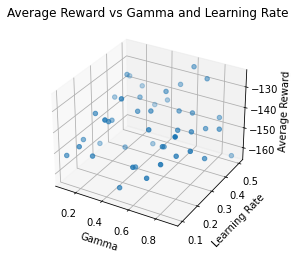

In [9]:
import matplotlib.pyplot as plt

# Extract the gamma values, learning rate values, and average rewards from the results
gamma_values = [result['gamma'] for result in results]
learning_rate_values = [result['learning_rate'] for result in results]
average_rewards = [result['average_reward'] for result in results]

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(gamma_values, learning_rate_values, average_rewards)

# Set labels and title
ax.set_xlabel('Gamma')
ax.set_ylabel('Learning Rate')
ax.set_zlabel('Average Reward')
ax.set_title('Average Reward vs Gamma and Learning Rate')

# Show the plot
plt.show()


Episode  0 / 1500
Episode  1 / 1500
Episode  2 / 1500
Episode  3 / 1500
Episode  4 / 1500
Episode  5 / 1500
Episode  6 / 1500
Episode  7 / 1500
Episode  8 / 1500
Episode  9 / 1500
Episode  10 / 1500
Episode  11 / 1500
Episode  12 / 1500
Episode  13 / 1500
Episode  14 / 1500
Episode  15 / 1500
Episode  16 / 1500
Episode  17 / 1500
Episode  18 / 1500
Episode  19 / 1500
Episode  20 / 1500
Episode  21 / 1500
Episode  22 / 1500
Episode  23 / 1500
Episode  24 / 1500
Episode  25 / 1500
Episode  26 / 1500
Episode  27 / 1500
Episode  28 / 1500
Episode  29 / 1500
Episode  30 / 1500
Episode  31 / 1500
Episode  32 / 1500
Episode  33 / 1500
Episode  34 / 1500
Episode  35 / 1500
Episode  36 / 1500
Episode  37 / 1500
Episode  38 / 1500
Episode  39 / 1500
Episode  40 / 1500
Episode  41 / 1500
Episode  42 / 1500
Episode  43 / 1500
Episode  44 / 1500
Episode  45 / 1500
Episode  46 / 1500
Episode  47 / 1500
Episode  48 / 1500
Episode  49 / 1500
Episode  50 / 1500
Episode  51 / 1500
Episode  52 / 1500
Epi

Episode  417 / 1500
Episode  418 / 1500
Episode  419 / 1500
Episode  420 / 1500
Episode  421 / 1500
Episode  422 / 1500
Episode  423 / 1500
Episode  424 / 1500
Episode  425 / 1500
Episode  426 / 1500
Episode  427 / 1500
Episode  428 / 1500
Episode  429 / 1500
Episode  430 / 1500
Episode  431 / 1500
Episode  432 / 1500
Episode  433 / 1500
Episode  434 / 1500
Episode  435 / 1500
Episode  436 / 1500
Episode  437 / 1500
Episode  438 / 1500
Episode  439 / 1500
Episode  440 / 1500
Episode  441 / 1500
Episode  442 / 1500
Episode  443 / 1500
Episode  444 / 1500
Episode  445 / 1500
Episode  446 / 1500
Episode  447 / 1500
Episode  448 / 1500
Episode  449 / 1500
Episode  450 / 1500
Episode  451 / 1500
Episode  452 / 1500
Episode  453 / 1500
Episode  454 / 1500
Episode  455 / 1500
Episode  456 / 1500
Episode  457 / 1500
Episode  458 / 1500
Episode  459 / 1500
Episode  460 / 1500
Episode  461 / 1500
Episode  462 / 1500
Episode  463 / 1500
Episode  464 / 1500
Episode  465 / 1500
Episode  466 / 1500


Episode  827 / 1500
Episode  828 / 1500
Episode  829 / 1500
Episode  830 / 1500
Episode  831 / 1500
Episode  832 / 1500
Episode  833 / 1500
Episode  834 / 1500
Episode  835 / 1500
Episode  836 / 1500
Episode  837 / 1500
Episode  838 / 1500
Episode  839 / 1500
Episode  840 / 1500
Episode  841 / 1500
Episode  842 / 1500
Episode  843 / 1500
Episode  844 / 1500
Episode  845 / 1500
Episode  846 / 1500
Episode  847 / 1500
Episode  848 / 1500
Episode  849 / 1500
Episode  850 / 1500
Episode  851 / 1500
Episode  852 / 1500
Episode  853 / 1500
Episode  854 / 1500
Episode  855 / 1500
Episode  856 / 1500
Episode  857 / 1500
Episode  858 / 1500
Episode  859 / 1500
Episode  860 / 1500
Episode  861 / 1500
Episode  862 / 1500
Episode  863 / 1500
Episode  864 / 1500
Episode  865 / 1500
Episode  866 / 1500
Episode  867 / 1500
Episode  868 / 1500
Episode  869 / 1500
Episode  870 / 1500
Episode  871 / 1500
Episode  872 / 1500
Episode  873 / 1500
Episode  874 / 1500
Episode  875 / 1500
Episode  876 / 1500


Episode  1230 / 1500
Episode  1231 / 1500
Episode  1232 / 1500
Episode  1233 / 1500
Episode  1234 / 1500
Episode  1235 / 1500
Episode  1236 / 1500
Episode  1237 / 1500
Episode  1238 / 1500
Episode  1239 / 1500
Episode  1240 / 1500
Episode  1241 / 1500
Episode  1242 / 1500
Episode  1243 / 1500
Episode  1244 / 1500
Episode  1245 / 1500
Episode  1246 / 1500
Episode  1247 / 1500
Episode  1248 / 1500
Episode  1249 / 1500
Episode  1250 / 1500
Episode  1251 / 1500
Episode  1252 / 1500
Episode  1253 / 1500
Episode  1254 / 1500
Episode  1255 / 1500
Episode  1256 / 1500
Episode  1257 / 1500
Episode  1258 / 1500
Episode  1259 / 1500
Episode  1260 / 1500
Episode  1261 / 1500
Episode  1262 / 1500
Episode  1263 / 1500
Episode  1264 / 1500
Episode  1265 / 1500
Episode  1266 / 1500
Episode  1267 / 1500
Episode  1268 / 1500
Episode  1269 / 1500
Episode  1270 / 1500
Episode  1271 / 1500
Episode  1272 / 1500
Episode  1273 / 1500
Episode  1274 / 1500
Episode  1275 / 1500
Episode  1276 / 1500
Episode  1277

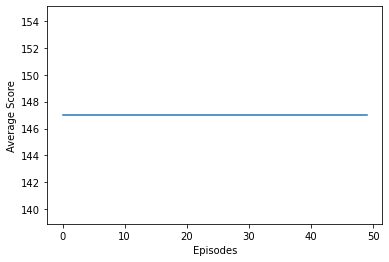

In [12]:
# Play the Game
env = TrafficGenerator(0.3,0.4,0.4)
action_size = env.action_space.n
state_size = env.observation_space.n
qtable = np.zeros((state_size, action_size))
train_model(0.3,0.1)

def test_model():
    rewards = []
    total_penalties = 0
    total_big_penalties = 0
    total_full_clear = 0
    for episode in range(total_test_episodes):
        total_rewards = 0
        state = env.reset()
    #     print('='*40)
    #     print("[*] Episode", episode)
    #     print('='*40)

        for step in range(max_steps):
            env.render()
            action = np.argmax(qtable[state, :])
            state, reward, done, info = env.step(action)
    #         print(reward)
            if reward == -10:
                total_penalties += 1
            if reward == -25:
                total_big_penalties += 1
            if reward == 25:
                total_full_clear += 1
            total_rewards += reward
            #print("total time: {}", env.totaltime)
            
            if done:
                rewards.append(total_rewards)
                break
    print("[*] average times exceeded mean delay:", total_penalties/total_test_episodes)
    print("[*] average times popped from empty queue:", total_big_penalties/total_test_episodes)
    print("[*] average times cleared all three queues:", total_full_clear/total_test_episodes)
    print('[*] Average Score: ' + str(sum(rewards) / total_test_episodes))
    plt.plot(rewards)
    # Show the plot\n",

    plt.xlabel('Episodes')
    plt.ylabel('Average Score')

    plt.show()

env.change_arrival_rates(0.3,0.4,0.4)
test_model()
env.close()

